# Regresión simple con PyMC

In [48]:
# Para usar en Google Colab
# El '%%capture' hace que no se muestren los mensajes. Pueden borrarlo.
# %%capture
# !pip install pymc==5.16.2

In [49]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

from pymc.model.fgraph import clone_model

print("ArviZ", az.__version__)
print("PyMC", pm.__version__)
print("PreliZ", pz.__version__)

ArviZ 0.19.0
PyMC 5.16.2
PreliZ 0.9.0


## Contenidos

* [Problema](#problema)
* [Análisis exploratorio de datos](#análisis-exploratorio-de-datos)
* [Modelo](#modelo)
    * [Determinación de _priors_](#determinación-de-priors)
    * [Implementación en PyMC](#implementación-en-pymc)
    * [Diagnósticos](#diagnósticos)
* [Modelo centrado](#modelo-centrado)
    * [_Priors_, nuevamente](#priors-nuevamente)
    * [Implementación en PyMC](#implementación-en-pymc)
    * [Diagnósticos](#diagnósticos)
* [Respuestas](#respuestas)
* [Respuestas _a la_ PyMC](#respuestas-a-la-pymc)
* [Visualizaciones](#visualizaciones)
* [Ejercicios](#ejercicios)
* [Referencias](#referencias)

# Problema 

El conjunto de datos de las alturas (`heights`) contiene las alturas (en pulgadas) de 5524 pares de madres e hijas registradas en un estudio realizado por Karl Pearson y  Alice Lee en 1903.

Obtenga la distribución _a posteriori_ del peso medio de una hija cuya madre mide 58 pulgadas.

¿Cuál es la probabilidad de que una hija mida más de 65 pulgadas cuando su madre mide 60 pulgadas? ¿Y si mide 65?

# Análisis exploratorio de datos

Comencemos por lo primero, la carga de datos. El conjunto de datos con el que vamos a trabajar es una tabla en un archivo de texto plano separado por espacios que contiene dos variables:

* `daughter_height`: Altura de la hija (pulgadas)
* `mother_height`: Altura de la madre (pulgadas)

Cada fila identifica a un par madre-hija.

In [50]:
local = True
if local:
    url_heights = "../datos/heights.txt"
else:
    url_heights = "https://raw.githubusercontent.com/tomicapretto/introduccion_pymc/main/datos/heights.txt"

df_heights = pd.read_table(url_heights, sep=" ")
df_heights.head()

,daughter_height,mother_height
0,52.5,59.5
1,52.5,59.5
2,53.5,59.5
3,53.5,59.5
4,55.5,59.5


In [51]:
df_heights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5524 entries, 0 to 5523
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   daughter_height  5524 non-null   float64
 1   mother_height    5524 non-null   float64
dtypes: float64(2)
memory usage: 86.4 KB


Se puede ver que efectivamente contamos con 5524 de pares de madres e hijas y los valores fueron correctamente leídos como flotantes.

Para facilitar la interpretación de las cantidades en nuestro análisis, convirtamos las alturas de pulgadas a centímetros.

In [52]:
df_heights["mother_height_cm"] = df_heights["mother_height"] * 2.54
df_heights["daughter_height_cm"] = df_heights["daughter_height"] * 2.54

In [53]:
df_heights.head()

,daughter_height,mother_height,mother_height_cm,daughter_height_cm
0,52.5,59.5,151.13,133.35
1,52.5,59.5,151.13,133.35
2,53.5,59.5,151.13,135.89
3,53.5,59.5,151.13,135.89
4,55.5,59.5,151.13,140.97


Una forma sencilla de evaluar la asociación entre las dos variables bajo estudio es a través de un gráfico de dispersión.

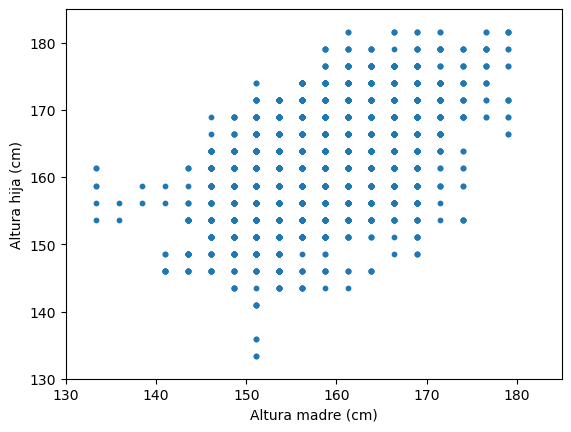

In [54]:
fig, ax = plt.subplots()

ax.scatter(df_heights["mother_height_cm"], df_heights["daughter_height_cm"], s=10)
ax.set(xlabel="Altura madre (cm)", ylabel="Altura hija (cm)", xlim=(130, 185), ylim=(130, 185));

Las conclusiones que se pueden extraer van de la mano con lo que uno podría intuir: las madres más altas tienden a tener hijas más altas. Sin embargo, esto no implica que dadas dos madres cualesquiera, aquella de mayor altura tendrá irremediablemente una hija de más alta. Si se toman muchas madres de una misma altura, se obtendrán hijas de diferentes alturas. En otras palabras, la altura de la madre no explica completamente la altura de la hija. 

Debajo podemos ver un gráfico que señala esta variabilidad:


<img 
    src="data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAjwAAAGxCAYAAABmyWwBAAAAAXNSR0IArs4c6QAAZ/J0RVh0bXhmaWxlACUzQ214ZmlsZSUyMGhvc3QlM0QlMjJFbGVjdHJvbiUyMiUyMG1vZGlmaWVkJTNEJTIyMjAyNC0wOC0yMFQxMyUzQTA2JTNBMTAuMjQ3WiUyMiUyMGFnZW50JTNEJTIyNS4wJTIwKFgxMSUzQiUyMExpbnV4JTIweDg2XzY0KSUyMEFwcGxlV2ViS2l0JTJGNTM3LjM2JTIwKEtIVE1MJTJDJTIwbGlrZSUyMEdlY2tvKSUyMGRyYXcuaW8lMkYyMC4zLjAlMjBDaHJvbWUlMkYxMDQuMC41MTEyLjExNCUyMEVsZWN0cm9uJTJGMjAuMS4zJTIwU2FmYXJpJTJGNTM3LjM2JTIyJTIwZXRhZyUzRCUyMl83djN1VDg4TUViTnZIam50WWdwJTIyJTIwdmVyc2lvbiUzRCUyMjIwLjMuMCUyMiUyMHR5cGUlM0QlMjJkZXZpY2UlMjIlM0UlM0NkaWFncmFtJTIwaWQlM0QlMjJ1RUttWE13TU1VbGJPeDQtUXVTcyUyMiUyMG5hbWUlM0QlMjJQYWdlLTElMjIlM0UxTHpIc3F2TUVqWDROSGZZRVlBUUVrTkFlTyUyRk5ETyUyQk44T2pwdTBwNzclMkIlMkZlJTJCN3ZvaUI1MDlJbnREc0pVWldWbHJwV0dmOTJZJTJGdVRuZUtyVU1jdTdmMkZJZHY3cjl2b1hocUUzQWdPJTJGNEpIcjU4ano4Znc1VU01MTludlN2dyUyRlk5U2YlMkZQWWo4SHQzcUxGJTJGJTJCNjhSMUhMdTFudjc3WURvT1E1NnUlMkYzVXNudWZ4JTJCTyUyRlRpckg3NzZkT2NabiUyRlR3ZnNOTzclMkI1Nk4lMkJuYTNWN3l6dXlMJTJCUEMzbGRWbjlQUnBIZlQlMkZyNDclMkJUZkEwc1ZaJTJCUHhINGR1N0w5dXpEeU82ODlmJTJGY25rSFJUZW4xeCUyQnJ1UCUyQk41JTJGJTJCTTdBNUg5YiUyRkp4ZXdYc1lFMWVQT09OZWRpMXFiRTNIOCUyRiUyRnE5eXg1MzIlMkIlMkJFZndlN1huOFNBT09lNEo5MSUyRnhVVnZlZnpXZ01CS1hHU2Q4YTQxR3M5RHVEelpGelhzUWNuZFBBRE9rN2JjaDYzSVdQR2JwekI1MWxleEZ1MyUyRnNjZHFLNHU0WlhyT0lHajhUTDlMR0JSbnprWU0lMkYxOUlQVjNGUGs3QW04VnIlMkZHJTJGYnRUUGZ6RnVHc3AlMkZZVXp0MGJwMUlESmZqaFQ0cDlsdXhib2wlMkJLdFp3QSUyRiUyQllDZ1IlMkZINVI4a2VYNFFsVW9Oa1dJbEx6Z3FlRVNZRlBhY2xpT1RlbmhIVXdWNFJ6JTJGZmo4TEpKMnNSWGRWampEczVwc2lHR3IxcFN1dkdaeGZKWWozbGJFRXhkSFRBc2pWJTJCcyUyRjFpa1lkSFZQRkhHOE9nMnhCS2ZSelRBRm45UzZ3NHVpYTVaV2R6OU5wYlc0RkF3dVZidVJPbHNXVjl1WVZmYVlJamtzUUIzQ0xUTHNGanpBNUxaJTJGWVhTa29sSGczVzVva1lBamIzQUUlMkZFS2Q5YjVzZGhvS05FdFIzMjlLcGt2YUZKMUZFdjRPc1JKVCUyQlVvcGdnbXk4SnNhVllwamx1TmVkbmxaVWlJWWcyZ3EzUEVLS1lvQkFtSW9rNmZzeWclMkZWdzlrcDglMkJjZUlsM2pGcENxUmNGdjhVVko1cXd5b1hRckphb0d4JTJCcFhTYXZlTzRIYWQ4dGZsOWFFcUFaR0tmNXp6NnRNRTk0YXdlY0NRajd5UiUyQmZuUTB5SHdrZ0tSNWwlMkJSMmFxMUVTJTJGanJ6QndLMGUlMkZPbEdZdHM4VSUyQmNTeVBBUTBwOEppR3dmbVlHTmFjM29nOVBpJTJGbTFMY2olMkI5MDI2dTVKTDlHeUZIS1V1aEUyeHdCQkZySnJLaGNzYWZSTEtHRU1LTmxTbno1N0dzNkZJY3U3bDlTQlYlMkZBMDdBREpWWFdBeVUlMkJ5TUJtdUVvMmxJNnFhZUVDODRZZlBjSDR6SUhKdHdQN3ZlNVptVlNybjIzbzVKJTJCUXNHQ2IybWhPbXJSS2lDTmxQNyUyRiUyQlJNWjNIbSUyRkRsUERHTHpWT2FDRDlIdnp5TTcxb1oyaE16N0swWFMlMkJSalRoNzVqRUNremlHMUVYZUMlMkIweTNMJTJGT2ZiajdBbTNtTVBuem4wY3g2dFVkREY2RWNSRXNBOU82UXFpM3g4emV5NEtwNnluWnB6MUkwc1czRkhhaEExOUpXc3hYcm1PeGd2RFhmbHdBcHJaejdGN1A2WGpnNHM2V0hFOFpJbDJJZHl5USUyQlk1Q2pvTDlmT2VxNmJVWWV0WFpjekRjc3p2THJLNFFPJTJGbzFMdk1KcUpmekt1TUQxR3BnUUdoSjNWOXc1bUJQNFhWbm9HdVJ0M2RzeWNqMmlJdjkyJTJGU1c3ZHFpejU2dE1HaVpaNXNLd2hrb2gxNVUxbDFNeEVXY1NSUDAyWk1obXZBeGZMOUhxemM1VnZvcGRhcXdRSkhGb2JnT0U4WTcxc2MlMkJ0dmw1ZnY0T2lUYXhCbndUUGNqdlhwakRUTndEb00zV0JDRFlhdXpzTUVQMFlvcEpMJTJGeVdVbWw3dWRCVThMc0VNWjVMSzlPZFo2YnRWaFZ1Q0tPd2V3aUFhNGZrZVRJNVNqQ3Mzd1V3WEl6bEUwNTRPRzBkOWlYNXp2N1REVWEzN28zOTNkVEdLZGVTamRqOUtEYURDZWxNaiUyQm1vVVFvbHRaUGIwYUplM2FsZ3dSdVhzeG9lOW5USk50c3JqWHB6ZmpnT0E1Mzl2bk1ibzlzUWpHRnJ1YkhEZU9id2NQV2Q5eEZyc2VkYWNCWnZ0ZE9TdjBNR3ZFZDR2S0RLaCUyRkU2QkYlMkZPeE14NiUyQlA1NkhZVXJickk5eFd1UnQ1S2ZmZmxMRTcxUU51MjNQZXZaWlpkSXRQdmVkQlZvYzhsR2ZIMFRUN29vellTemglMkZMR0Q1VGZTVVhNczdrOWxRZGRwMURUT3Mwck5JdmNJSk9MViUyRjlCMExScVFBS2hTVFFtalhIOTJtTlo3alluOCUyRm5ybnoyeCUyRlAlMkJJWXRkcUU5RjNZQkZRN2FPMkk2Rm8lMkI2ZVJ4YkNPY1olMkJkOCUyQmRiaUtVaEdwSWJlUTYlMkIzZlhsS0lkNnRrblA2MzVzVjczOEpuclJtRDBIODJmdlE4WUlJNkx4a2pvSlpuZjduanRkWndWdXExdEl0b3JkSm8zeHpkQTBOZkZzTk9xeEdEa3QwY083S0lkeVhFJTJGemFKdiUyRld4OWlqS1pObVRFZWdpNmElMkZJRVllalk5bTF1UWZKbUs3d0FqeUZjRXZ4MGw5TG5hQnNlY3pwSnQ5dEd2TlN0aktmb1N2cHJKMG5LNEpCT1lsN21kJTJCZ3NWN0lXNSUyQiUyRmV1JTJGTmVWZm1KbGo1UVJsY1gwUGM5NDA4azIzMURlSFc5djRZam11V3p1d1hHRUk5ZDA4UmVWMWJqMTk0d2dza2M5ZURmMHkwSTdIc1ElMkIlMkIwa0Zuc1lRajNKMHVlVHJBYmNrd1MwOCUyRjFJc0pXTTVjMWZnOGFiekVNNHQlMkJPR0xHZk1YOHUyUFJiTWFpUEc3S1NJSFJUOExkZVZYVVlBUnRMNUdhbUIySkhKazBWR3FqdnpnOUYxTnNneUV6eUdvNXZIRHIxbmg2N3N3eHJ1WCUyQlg0NmdmVWNRd3Job2RUbUYyUTMyUFg0ZkF3N3pMNW1zUW1iQm51UVU5d0g4WDZSOFA4dFNkMnhzeGRaVTJLSjJZUnNZUmtEODllN2x2U0V4VVlDTmZXOXVvbmVyJTJGTmIyTGVDR0Yza2NHWkRoeG9rd2cxdHIweVklMkI1JTJCbnI3M2V6QnZkaEh4WGglMkJWZUtqeXIlMkJFem9kdDYyNiUyQjcydUZiZHhzMFdZdGEyaWlmayUyQlNrNGJISW41VlpseWowaG9TOTZRNEVQZXFueUloTXZSaUNoQWhobUEzd2F3eVhOa2xkNnMxRGU2YndnVXJISkc1QklSQUVxZDlDRzlxNEladzgzeHZ1eUROdEpzTkJNcTczUDNma29kMTI3R0U4NFAxdXhZb053WWpJN0w3dlRZM0dhOEJsV2VKM2J6QWRxUTR4RldpUjdyUjN6UmclMkJ4UHB5TyUyQiUyRkE3eVpxMVlLb1UwJTJCcU83QzJlZ20xc20xbTVHZE9mQ0hSVnV6ZTJaNUxKaE14NG5QWFdFdWRGUVlMUDh6a2UzeXF5V3d2ODcyb2c1JTJCRjB2WHolMkJYaG5CUjBnc2R5c3pIRGdHbjVSSlZEUnJRY0M4S1dRY1BDUnpiMGhYSXhzZjJ3ODZiRTNoVU8yNTF1c1RWU2dhM0NiNTk1T3preWhlU3pVNjFrR3k2V2Q2M3VnJTJCWHQlMkZkNnIwQUtlc0NqNUkyZ0wlMkJtaCUyRkdVbEFQRGwlMkZjS0d0ZmxGWktLVFNuWTNBZWplOXI0OHo0eTFLWnJXdmZBTnFsUW9DbndHUSUyRlM0ZFhkZlhBMVBXOFlZdEFrQUpxemNyNTh1VGJNNyUyQnlaNlpYdXhhR0g2SEVBVDdUeFpUcWlNSTZYendUSFQ3YVhYSE9wV1lNN3VuQmUlMkY2aW9aenFxZ1pMMVd6RXhSJTJCWFRaY2RwYnFYWFg1VzAlMkZ6QmN3JTJCR3BjNUVGblFrJTJGTU1FaDEweXdQYWJJUWF3M3ZjNnJYcFI0dFM5YnJuS2xEOTJQWlJNaWxPWFVVMU00ZWM2NXFnT3lyMU9JRWZhJTJGUnZEU05tMTclMkZvUzhGTyUyRjExRlBXcFpDOHZaaTMzOW0xRFVCa3BBTkZxRnhscHBFc0JIVHBmRWV3Tmh5eTJ0QlZrNjV6VGxUS2dmOXdkJTJCV2FHNDNxYmNEWUVOd05BZ2IlMkJia1puJTJCV2FmMUFFS281RHdDZkNWZ2tMd1ZjZHV3OUk1QyUyRlg4T0VBdEhWWUNYZzhLWW5ZT0xLWkxTeXpxRGVYMWQ4bFRBNlNqeU5VYXJQN1RVYnZ4JTJCTHJ6UmIzYmF2dU1nQ2E5WXV5THNyR0U5cTg4bVY0eUJCcFpKTHRPOHhRcVBPN2JxSXVmQWZBVFlFQnZYV0VQNFpvc29FWDZzNyUyQmZJeldReThCb2slMkZUdWc1a1I2V01Ia2dMYzdRalZDS0NmTW8wRmtZM0JYVzY3S1lEOFJCV0gzU2UzR2Y5dlhPandUZTNCVE15Um9pQWlaJTJGT3ZSJTJCTnN4QTlQeXMxbGxKOElLZURDU0tybXhVZFhVSWM2NkpjbWZrQjJxa1R3NXQ5QyUyQkhtdmw3bDYxRDg1S2FJeSUyRnVNblh2endiNXdBbUNHVHpNYVZZUmxMJTJCdVdCOFo0WmxIN0tnM0FDQUFtTG9YNWRSY24lMkJVS2VNbEhIaVFOd0VLWFVDS0poeHBMR0YxRWNvWFg4clRnRlY1enlxdkVmVFdGVXNPS3g5bnl4eU4lMkJLVTNERktmMUElMkZnQ21Tdk1RZFVLend6VXglMkZlZWdWSGJrU2o2VTJlbnZ5c2EwUyUyRiUyQlZNQ2RKJTJGZUpWa1dkWTVueXBOT09ldjlkWkM3Zzl0MVFpdUYzMXAlMkJrdm1xSENxcWVxT1B5N0VtTkh1c2JNc2pDUFZUT2xUJTJGWklhOENaYVBsemxCVzdHdllqTVFlUjFqOHJwTVVZZDZMS0NzMjFmaU5JMUIyZVduZG1KMkhCSTkwVWdVZHVSNGklMkJMQ2FzUDl1SlNqVTcwOEtyREpGQWRLcm5vSDNRVDNIbEFHb2NueDJQWmZiY3ZPNUVKM2xjUFdweDdZUXRxc1k0dURPYk15Znl2TTlZdWczV2J2S0ZFM3FndnI3RG9QZWwxJTJCb3A5VHJ6YkZmSjVHWWdJY1lwcDNTWmVzQXI5JTJCUWR5RkhhMSUyQjVyUE1jNkhNRFNFUjJHQmpxNEREMk50OTUwRXh1dUViV2tkc3JkcWs0NiUyQkdWSkhNVHpPayUyRlBUQ3drY3pFOGdQa3hJcFVKRmg5bzdJS3ExS2tmZzBrJTJCaE9XV29YcVhCNW9ac3BiaVpHZXZVOUElMkZEQkdtdjk5ME9IZ3N2UWUwVTc0TXBuJTJGdmxLUjBhMXdnS0Y0MXRBb1VhSHFpcGpjeGkybEhqRkxTdiUyRnpQWkV4MjlPcWNTdW54bDNKUUp0UUkwdzZaWlB5bEhJSUZZT1hzTVRhVDB1VWZNekVoTXpIcmtFciUyQm1Na0FUZ3NIbDJIa2pQNVZKSERhaTJON3M4YXA4RWN0V1dxZ3djWWV6QmNUJTJGd0VpRjV5bXNEJTJCbm1YJTJGNHRhVmxMaHhLZ1lwJTJGYVE0Z3dkTDNOS3JIUmV1aTExdEdXRnUyMiUyQmlHb2ZqVTRzbGxNeEk1M1RreGxUcUFlT2FFREJ6aklNV1lDN0ZsQ1RXYktsdjA2am4xc0VxTFhiWFB5MUkzNFpLNkQzRkxzUWxRQiUyRnBoTmFzME9lNXJZY3lCSXdZelIlMkJ6WHlNajJpaEdyUERQQXN0U2pjcjA1cTNzeHRaU0hCM2dVbGlrMnVOWkFpUEpCdGRLWlNaQkVvNVR6b0t5dnY1cFNINHgwVTgyT2kxenFYbG5pMG9ISEhsZ21RQ2RmRVcyWmlJTkVPd3BocE53alFnMEtLTWZET3VmT0Rxc05kWktHUTE0aUNvZzQ3ZlBhMUR2MEclMkJpZnFyOUtiNmNzZDh2Y2xLRWJLeTFWUjdHTURlaUwlMkJuQjVHUnJtSm40bmZGVzliNUxXMUVEUU9oQWo3cUVzN2lMV3ZzcEFSVlJaNmlvJTJGNVZiM2VxTHo2N1BsTnVvQXpySFVxanB6VGFuOElrejE0REJqekdxNjBORXlxNzVyRFBBaWs5V3pQM2ZZbzUxMDV3Y3JCYk9FZExidHRoSmxhNU5ScjhIY09mbzZ4MWpVZzcwSEtRV2dGbE5zdHhBaEklMkIlMkJ0b1pxZGFZWjNKWlMlMkZlUElGOGVSbnd6NmVEekJQTkxhJTJCVW8lMkJiNG9VVDJ1eHpDMUZoTGxTaTQ2SnIlMkJNWmY0a2VGSzlEZ3QyTEJkQTdicmt6ckp6dnN0Y1pIbDZpJTJGUnNLOFdkbndaNVZPUnFEQVJDRzFzayUyRkdqTUY5T2NLJTJGWiUyQkIlMkJhdTlJMTRJMmdId29VejR2Q20zcThiWFB4MU43MmNpdUVFVVNQJTJGZUZVWUxWTmRVJTJGQTluJTJGY0pJVjdjOTluOSUyRnY2NTV0bGVseVRMUEk5ZmlXMk80ZDgyVXBBJTJCN0ZUNzdUSXFwdXh6eTZKc0dFTFVYemRHc2IxUnpYVW9uNjEwcVdMUGlxdUhqaEFFZ2xkWURvQ2IlMkJ6YkM1eE9jb1VxcnZ1SW5jWlFDJTJGeGt1bTVFNlF0ZVQlMkZlUVZXNk5ySkkyZyUyQm5NWDNLWnIzM1ZabDQxa2UlMkJhNDNjelBYTmhCS0EzNlJJJTJCM0lYS3E0SnNKUmZIRyUyQm1Ka0tuWiUyRlltODBmYTJoSDVBJTJCbnFycG9MTWpBemlldDZENnNFUyUyQmxZOWpkUVpmYUglMkJoaXk5U0hZTFdrSUg2MSUyRnFhaWVGM0w5bGl2eDdad1Bzcjd5WFg3ZFIlMkJyNFN1dFRSJTJCV0VpYWoyeVlJZkExOWJFajlvZlJONGFBYSUyQkFsZCUyQnZBRnBlZ1BCYVZsUm9DaG5mTlJQJTJCZ1FlekZsdmo4RiUyQjNDSjFjSjZKODdEaG52ZzBGWUolMkJYRmNBOTdKeGdvQjBKZXhWQ0dQMzNlcXZsRiUyQlpiT3ZOeWx1MWhnV2ZpeWl3SiUyQjZraXg4cGNWcUk3dlVCJTJGRnlyend1RzZ0TEI1SzFvNzFmdXpCbHVDdkwxTFZOekU4VXJkRlBWZUFzbGE4QXhiRVgxVTY2WDJVdEpZWkx6UVQ2RTlwNTduTlVDNVFFYkQlMkIlMkI3S1U0SCUyQlFMemFDRDRaayUyRmRhZTVRckxQOUxvdllGR0llTSUyRng1a1JKbWVWQ05GQVBZMDB6VjU5emZzeFcyaHIzd0tmOWg2cnNaOWtZdjFZV2JDY1FaSTJQQTcyR2VmUURBNEpEMzlVTGVXRTA5ekhuc3JqbDBVaTFGM3k4NXJvRzVJbk1rNlRUWGU0UTl3TzFKTmtTMnh0WmhScGl5aXJ4c2Q2bFI5ZWR6WUpHeUNIS3BrUUVvS3VxaUdCMHlaT1VmTkVIYllmejF3SGNVT0REVXNhN0xwdkZSemRFa3Y0SFpBQzZrZ0YlMkJTJTJGZklqc3Y1YzN1djVydUxKMGw4WXg5WkhwYTdzd1N2WDZZVlclMkYwU01GeCUyQlMwUzFUck0yMHRsakIzcVd2RUNVekxUM2pNOXBreXNQVkIlMkZJWVQ5cUVwOGZZQm14bERyN1B2WSUyRjlUZERoM3NlcWZpUWk4aXBPOUEwRFAyaDl6ZXA3UGZzcWp3JTJCa1FaRUs0bjlJQlYlMkI5UnQlMkZHOUxNU2ZKTWRnNDhEYTBRdndjVnpZNkt4QyUyRk1wNiUyQm1TbFB4TmxFaDJqSUJ6bjJtZmM1SEpnQkZxQUNEY0hqd1glMkZYbXFDSWZJNkJtbm92JTJCMzhSOUhSUzNCUiUyQkNtNk5mcldUakVOOCUyRllsUHklMkZlTnlNTjVRYVhJSzNobjhlRkdkYnFsNThSJTJCb3YlMkJ1ZWtCbTlLZ09SdjJSSmE3YzlKSWpWUUFIZzU5JTJGZEIlMkYzcEdITGdtbCUyRmtVUyUyQmgxZnhHWW9ZVG83SnlPNnRmTGlxOGRvck5DVGYydVJXemNrUDFwNkRqVTAzenZpYyUyRnZKcGxvdzJNTVV2VWp1am5QOGFGc2Q0RlZnZU84SSUyQlElMkI4TmQ0QVBTanRYVHdTZ2MlMkY0cnhHMENhOUZIQm4zdHBNQ05OVnFkVW95WnBhclRTNnplJTJGeUVacWMlMkY3NlhGUmkzTDByTVNpbWt0SDVjRHl4Q0x0Nm5SdzA4U3hIZW5vdnFGOXJpM1UlMkZNUjl1ZzQxRzVSdUxBNzZkdDJoMyUyQmJLemdIZXJoRTQ3a3VVcmUlMkJsNWt2Vkd5bW55cHN4OHh6OHpsM1FKUWdvZmUzcU1nSHVTR0E3TTYzN0tkZVpudVdLMlo3QlRBa1ljYWpOQVJKeXFaRFE0aVlUZWdRZFRDVlRmNjB3TW5HbzFtTEtkeXpURlg5ZkY5c0RHZVFXcm93TE53bFlkb3hUUDBTSzBFSGprS0pzRWlQNExiYzU0Y3dVaiUyQnJONWZ2TVl6JTJCQ0t4TVJuNyUyRkE2dFVEZTNwRmpjU3ExeWxOZWRPcXNYeTBCTk9zT3R0VHlmSEYwMVJIS2xQa29IWUxUNUc0akYlMkJYcHpIJTJCdE1xYiUyQklqR29CbTZ1Qjk4SW84Y2ZBR2xRR3NmMkRiQmkxckg4VWluMENIYmlBSzJHVm41TmVWQWI0bzYlMkZjRyUyQmE1JTJGT0hzSiUyQk5WM3F3bSUyRkxrSE13b2pXQVFoNjQ2RWZLMHVmZHJRRUxXUmJFUFB2Y0FzUUdGTU9NUVlzOEVCNmg0bmhjbiUyRnFQVHJFS0QzN3dzeUo2NVA5TFVGdmFNT2FpTmRpRXpUcjg4RHg1WHolMkZqeERRT3VBZllZcGhXMmU5dzNZY0psdjdzJTJCYzU2b1JocmRxUWlqYmJEUXo4cWxHZnhxOHdCamlwMU9XWUw0OTlwdnJJaVFNZ3UzRGdJM1VGanlJWjV6cGZab2IlMkZPeTlVWHZZJTJGYzhuV0JqanRyekU4UFhIb0oyUXlUNW9MMmNGVEZmUzdsMUF3Vlh1cGZvOE1LNHJYNlkzbCUyRjJMblBJd2N1cUhjNmVkNmZwYWJCMlJBWFFEU1BoWDZzbVBSd2V1TW95ZVJDcmI0OXVmViUyQndCRWR2VWtDU0F2bUNFYkRPOU1nN0xWdEdoaWF2NEVtZEJ1UTNGdGRXdnBWMGM4QzFFVVI1cmk5SnhEbjZNbTd1JTJGSm9ObWJnUnVVJTJCR3VBcWRGVzVjaXAydiUyRjJHR1VJODUzTEs0Tkw3Z2dmZlRHbVlEeFoyNnlieiUyRmo4ZUN2WXJqakFBQWhBRUV5SnNCWkJFblNKUkxmT1dBT09kSmFCNHRvaWxjM0U5VkJTeEV5MHpmNTVUZGVmUnVGbTdKeDJIblElMkJuNEgyeiUyRmNSMjlWcFczS2EyOHNuak5XZEdtSGlSciUyRm9rc2lrN3RIZm9NMGJNJTJGeUQ5NEFpWHVoU1c5dzRsWk5Bdmw2UXNPZlNDZjUzc1BNeG10WnQlMkZvNThiaEg2YXZJOFRJM3lieVg5RXc5eSUyQlFZc2RlMnJvTDNpTTFGd21JWFlNRTN2VXglMkJqZmpENVFZclpxeDU1eXY4dWRpWlBoaU1WWkNKdHRRNmtsUlBYNmRGT0c5ZE0lMkZMQTlIbSUyQmVVWWZqTkN2TmtrbkJSbkxqVmY0T3REQ2NlSmwzcUtidDlNbVElMkJMcHZQclIwRDRUeDFka3I5eDRFJTJCN3ZGJTJGSVlJRmF6WjJQNDNDOHlXWmNUUW9ldXZWMzR3OXdHTk1UWmtvcXZ3M000ajNrWnBxc2dPTzd6JTJCalRQRnFYN3pwQ2ltSXhtaWE4TmdKT0tyU05od0Y4NnFGU1lGbjJJZDVObGlvcXUlMkJkTHUzJTJCMnRlOUZiSmN6YzdDZ0txMWF0bWh5VlRKVjBtSjVqRHJaMXNubml5TzBKem1lZm16dWhzMkVZMVdLempiUmdDaU94VjVFWE9mS0pNN0hORDdVWkgyRFhxU2dnVnlrMVZKNzdNVDBKa1NmQ2hMNXk4VGtZbTNJbyUyQjRzUGduRDJSaVEzeUh3UG1ITVpkRVNxYm1IVSUyRkhFMnVWU1dRcjZESHpQMkNQWUZlJTJGRmVFTEE2WnZFeWZxWFB2MnhiU0d2bCUyRmFabE5iZ05BeU5FMEFMc01LQVpIV1NEb3gxV3ZVS2llblAwUHlFRSUyRiUyRldWa3VZYmZDUFZZYzhDamFyZFFTSXlTMEMwSDJRcDQ2ZU9LRVZqN3NyZmlBcXFQNTZQZGp1ak9UdkNmQiUyQkplRjFzRlVtc01QdEQ3MUQ5TG1wSVNWU080c0p3UWtKNHJjeElKdVlmZnpnWUhQQ0hhN01mbkQ0MDE1VHZTbzBwWERNaFJMYlVTNHNtUUpjNVgwdk44cyUyQlJMMyUyRjdIZTR2aUVxJTJGNE9weFZzY1JFc2VJSkJwQ3BMckViMHNpcU0xSzglMkJlSCUyQmlleUFnanNqeHg5QXNmRHBEa2hCSFhHNzY5aVByJTJGQjJUdlNoR2dITEIlMkJtaiUyRkYlMkZ4RWU0SDhsV3JnTW1SbXZZTiUyRmh0d1ljUExjQ21kRFBHeWd3Y28lMkZnd3F5VTclMkZvbkF5RHlqQUo4S3ByaHRmMEZ5JTJCdlpBM3lpY3hwcTRFJTJGWEkwZFc1SFFkbE9CUHl2TjNGWXVkbk1QaVh1R205NENEZEdoV0QxUWRySUQlMkZmUnV6Q3JQeWNESSUyQiUyQnV0MHc4SnRIbXZzRDdVZzUwaEFHQm04blNPOXlidmFmb2lOOGhDcDllJTJCZGxhbW5EbDVNZVF5VDRYWlVzcVE2OGFQQk4ycmJjOWUlMkYyY1BNeDRqNEZ4WDZieUIlMkZ4em0yNWFLWFZEN0ZkREcybjlaeWppb0ExVGJjV25UbGx2YSUyQk5mUjBqbld3cW80djhIQXdZTmJKRFVKT2NNdlJVZmZMN28lMkJuM2Ryb1ptZDM3aXJxalpPRXFYSDNoSkhsJTJGQ0xlbUxHMVA2YnJybVhOczZtNkglMkJDbDZ5Y2xxNU1iRlBqQmRYVzZwczVKN2U3QyUyQjlUcHklMkZWdUV1YXVKZiUyQksyM0xlRkhtRWkzM1Z2VWU3dVNkUjZrcXhub21EZHRtV0NWaTdIYnRLYk1TR1NidllzY3pLT3RNbjFiYnR1U3lDbHglMkJjRVRGaHMzRGtGaGtoeGw1YUhONnVWbkswZ1VIZHBNeDRNeUJsMEo2cVFtNXowWHNaRmQ0WjlhSEtVZTBFY2JVZmNtVUhYYWlpWGt6SEI1b3UlMkZNb3U5WVRJdGtlTmMwYW56SndmVmVWOVFEbjQ0ZVI1YUJITEVBaDk5UjdBbENWNFprREhRbSUyQktNcGcwR0QzeVJ3VHlWeG1QWENWUzZibUlBZlVKbWhOYWk2eFdVeUxUaE14MCUyRmFSZXUyTkZuRWdFeWc1JTJGVnVqZDBlZUlUTUJBcm41T0Jxb0c5NjN4VzZBWU5YM1cwMG0wS0dKV2JYJTJCdEhhSHZQU3hydnRxUzgyRTB3SWR5MGxIM25WOGxNZllpenJnJTJCM0RXQ2pkSnBoWkQ0WUwzVFpSVEduJTJCWThtayUyQmtYdkYzcExPZGJYVlZJYkFCJTJGbHd2TnZUcEclMkIxb2EwV29WdGxsMXNSS2dRN0tRUlFkb2Z1eiUyRmwyZ2VUWTZmeUd4MDlUN2JWWXFOckdkYXNCQ1I3SXpBTzFwJTJGRTREZE5aOGtxYjNlYUx4enVVZWJYNzRyU3NhTFBQNVFSa2xyelgwWERFNGNJNVVUa2hXYiUyRkhUUXJqMzRrRkxiVHJMZGw0cUY0Nm50ZHREdWdXOUMzM2REMTU4dHVaQ0pqOEprakZMajJ6Y3dZTHVjQ0xPd01QZFZYSDRmQ1lUaUtuTDdpMU1vczRYOGV1JTJGOFpabmx5d3FCZ2JmUzRIMDY4d244emdMQTNWZHVSdmJZc3hYY2ZJcjlMb0R3aTF4VGNWTUJiellhdUpnbmptZkpuRDJRdCUyRlVkMVoxN2JnQXpCb0xQQ2J0SEdUJTJGNGt5cjVFdUM4UFYlMkZEaXZYbHhTT2VLaXNJdHdjZUJyTFAwV1BDbzhqbUFZZzhlcElUb00lMkJDcjZZNDZPNDZQNVFyZ0FjSVZ2cmVQd1VrbFFSc201cHc4a2J1RGdMRU1FY1JIRXltOVdqOElBbnl4SUZodiUyQkhIREdUUk12WTB4anlkMGdjYWQ1YnVsUGhkRWdNZlhlTSUyQmhqbGk0N3cweWUwMGglMkYzMEN2V0xoVTJHc2xtV09EOFQ4b0JSSjQ5ejNMN3g1dmQ3bTdzTFRiaEt0SjhiTHdqUDl4Vnd0TW5TZU81MG1tNjNRSnhxWGNaMzYwcDZZaU0xMWVEWVZXRWM5eWY2d3NIb2l3N1RTJTJGdEUySkhVZjZLSjAlMkJXNG5ZQk82cGslMkJoeTBHWUVxdzNaUyUyQmxleXViRnpQJTJGQXVaTnJWQU9RbXJDeCUyRmltV1FibGhHOVViUUpVc1RIN0JGMzRJV1Vic3Z6WENTeG90am5pYkhVSG1EQUJSWUlaVFJTWmNaS3FxTkxoVUFKR0xwa0VzcE11SGVNclVKampSNEw1c1JYWSUyRnpjMUlGVWM2T29DU1JjJTJCc3NRSHMlMkZjbUtYNmJEOVJYU25LRmtnMUlkY2lJTHhZb2czUDNPYUtwUnFaTDVlVWFXZGtYdUhYSiUyQmY5TkgxOTFRZUhxeVMydHZZZ3R5UFNzRWY2QUtCWFJ3TG5Cb0F5dFA2YTBOWk9OMCUyRkI5U0FlWUE1cDFqMTNGTm9INFFYOVhLSGY0dFhucWpEWXNRZkhMNUVmOWElMkJxUEVLOTBBZWZ1RUhVb0xSWFVCTzdaNGp4ZjBqTVRBU3dMVVJkY01iMnVrbXF3NTZhRTk2dUozbGJWJTJCZzJjamsyNUd0NUYwYUZBNzNMQiUyRmx4eXd2RDBJNVFGVExvJTJGbUtnSFdCZkclMkYwbnRWeXd4eFd2aTN5d1NaYUl0OXAwVUM0Q3JOa1Y5em9EJTJGQUVNSGJ5NXZQcGw5eGtyTHNBd3plOGl5YiUyRnUyJTJGWFdSSDd1MThjcG9KMkFPJTJCRlpYNFd1c0hYYWlEYkxNWkdiamFmYm5iZDZIJTJCZCUyQkdZMnRPbEVVaGNCaEpkbEFGME0lMkJjc2pqZkxEbFF6NmhSUldLNlM0b0VLVmJwV1ZzM2NhZ2d3JTJGWUtlRWpkJTJCeGhENlJXcURMeHpwZDV1aUE3aG96cEVYZWIyTElFdXB1ciUyRjRPT2l2Y0FoelFPOTRoVVA5R0l4dER3SWtTdzN4N0RyVzNkakFmV3VyS2x6OEt3eU1OT1NLQ0VPRmxMdVNmWWdoUnpROFFHcWxYN09udktvdnNSdmVZV1ZpaER6cHFXWHpJZDNYRXBKYnQ2aEV4Znc2b2F3V0RJOWI2bmtTeDVLTTE0aWZMRkhuTDkzSlVMMzdyZXY2OXpCTTh5WGtBJTJGMlFxU3p2ZTdIbG5HMHJQUjZRZmFBclRvdkFXbWNUJTJGcUVrQzRaVTNEWXdUbWtCQXI0SW1UOFNGYld4eHJzcUpVOVRYU3JuUmFBUHF4MVJySjhqTDMxZURJRjNLdlBBODVRM3RwVjIxV0hOYTJJMTVCN2drMkc5OFJ1WHRIUG5PRmU2UDUlMkZxNm4xZUF0SVZieE0wMUNUWEVlb3h1Z1ExMlNrTzhPVWVsbFRzMXpBamRXMTN2WGJ3aWlqQlp4eHNCMUVNUGxjJTJCVkVYSnZIdWtnVSUyQkIzNnBLSXVCeXVCeHc0JTJCblRXd2JaJTJCNjl2UkVIQWRBTUxYYzN2VUJDV29GWnNEd1hCVFJibnN6SHVPeGQlMkIlMkZsVGF2MjRqVVlEcHVVNnpMTGVHM3VnJTJCeUZ3R0JQMTNzemtHYUdXOUNJYnpzS3hWZ0lYUU5jQnlsQ2xMVEhHcXdxSEtKYmc0bUV0NXJYYlVqUGh4TFV6SnZzcDZVa2tIanhTV3FEQnVzJTJGMW04ZWl2TWgzdnFnNUNUUDdHQjRnJTJGNXdQTmlaMmxBVWhxNHA2dmFCMnRpbzBHcmlLa1BEZUFCWkpnQW1NbklDTXhuUFcyM280ZTJlR2lyJTJGS2QlMkJ6MG02Vzd5VllaWjZOaFMlMkZ5cCUyQnpHdmx6ekh3WmZtR3kyTndjZTE2UDhRdFlpeTNraEZ2WnolMkZIZThhaSUyQiUyRlZVM1o5UTVuWU42REcwSEUyZE53b25kallaWHJyJTJGJTJGT1d3TnZrSDNGRkE4d0M4YTBMYXFBZ1htJTJCbXY3VlFUTHNCcmxBVkslMkZCVk5nbkhRSWZLb3UxazFMcUQza0JobzdhVGpBNGVYRmFCSkJGS2h0dFdqOUs1TGM2a2RPWjVQWFJMWHQyY1hyOGk3JTJGalRNb0l0RE8lMkZpUjlBa3U5TlZVRzRnQkpuNm5QdlpHbDREeW11cXppWHQ0N0kyZXY0JTJGQ1pmS1ZxQVQ1ejdUZFBBN0VoWWYwVSUyQiUyQkh6Zml5aTJnY0dOdHZtRnVHQ1ByNlhsejd5NiUyRndaMnFCMyUyRiUyQnZ1dE1tZTllUlBiT3R1d2FpSWklMkJZWjZtTk5UZiUyQlhxWDN3bmhhT0dHZyUyRmpLNXUyciUyRmV0QkQ3WkFHNjQxMm4lMkZMdzRrZjlmd3BkJTJCQjZzT1E2TzEydXolMkJ4Skh0UExwRTk3NFRyd2ZxcVE1eTlwbiUyQjJZVjJkd0dRR2R5VHFIdDYxeTQyM3ZQSTFsdXFucXRnYkdvWFklMkZJSUo0M2FUWm00cllkbEhOZEJtJTJCVVF5cFRsNlJ6emV3SnpGM292ckh4NjJaZ1dzMVhEbkdjWTVjQkZjeVVtZkxWM09mTFpHcERCaUdIQTduc1lMMWxHTmhGN05uQVA1cFhjeTE0T3FBTWFFOHklMkZJRUM3QlZWMk1YeXpJaHJRQWtXYmJpcVElMkJKdEZ5Vm5VV1RkMWlGZnR3UiUyRmw4QnVPVTdrT2RLNzVxdjU4c1p2VHA1SldKdnElMkI0a1A3UWp5NkhmR0I0Ulg2cSUyRmM3WTdYSVBXcFRONyUyRmhLQmNBTllLa3JaQlRMZiUyQlRsSjMlMkYyTjVHeVpwUTBGTEEyczB3ZzBsd1NNRFZHc1IxcmV0Ym9YckR5NEN2Tjd0NVl2Q2RBckFqM3VPQzE3aHpod0F4MiUyQjVtMWpHdWQzJTJGcEVKUHNaVGFWJTJGYkZoN1lPMnNIblQxR3pCOFBBUWdTTHhndGhINGV6SmNUZjU2QWtVUGZlWlJHTENhdUhTMTF2cGhyUlVtM2UlMkZQcEV1dVRlQlROclp2JTJGcW96eDBPJTJGam5SV09MZkR0bEpnNWROUmNVanlpZzNkdmFXc04xWDZiOFRlTmRudCUyRlE5aWgwVlM5TU9reDNmWVVCMnpORXVGQkJDamRMek5DekF6QWF6QlhQMm5OZGdVQnVhYjQ0V1ZneElBcXVGaWNMRHNYMVZVWHdYak1tZks5SDhGZHl4ZFFzNWJEMEY1aU1JZFB1NW5lV2lkZWNXWkpiRFVhMkVvNzJSNzR2ZWFDckZIQnNaSlNCbTZ4aCUyRnglMkZSUmNjOHBVelB1JTJCYnd6UUp3ZTU2d0xnJTJCN0ZSYkRlJTJGTUliMU5tSEdmVG9BalRZJTJCOTVMN3EzYklGNkFmTU9hbFpObTZydlBqUWJ6cmp3SWpheEJQZXdRSndVQ1IlMkZmT2tQQjNveiUyRndaJTJCUE1RQ2ZNNnFZUDYzZlk0bGY1R0hYZ1k5blM3QSUyRkQyMUNQSnRSdVclMkJpajBRR2toVGlKRjQ1YVBVV2tSalVDdDc5JTJCWjFhSXBNajhSb0JFQSUyRjlPdSUyQk1aN280Qjc5NWdWQVVEN2h1U0d0ZG1uSHlVUmE4NjFwQjIlMkZLWWZYMkZIVVgxU0xBMUIxdnVINHVGMEtRMmJiYk4wZTVQMXpYMDdKaHRBUjJlZU1oJTJCRmdqYWNGZ240V0tqWCUyQjVnMW85R3UzQU1CUU91THBjMlNoUE5jcnYlMkIyUHVuSm5RR2pzWWZoY1Z3aGclMkJyYnJhU0pRemZSUzJCZkElMkJuOFY1UWR3QVJweEQ0ZmJqN2lLTk5INkE0Zm9qRWlGMjRGcWglMkZrd0J4VkR6T1czQ3VVRlR2dGpWVzN2M3RVR09NanJoNEdTQ3RSUHZjMWFJQzJuMXJJZW44JTJGeWl0Zkgyamw1TjZ1cm1PeklPcDJyMXliRHN4VHpyeWNrWGdXdTQ1U29mQmk4a0xhSjcyYWp1b2hjM3hETkltTXEyckFFcW94NDQ5RnZ6V0FVcTZuWXZaN0glMkZJWXVmNUJ5TjNFOUI1Y3JnSE1BWTVlWGZ3ZFpOc0p1TFFCd29YM2FJRERpcU16SUJRdlZxaWREaXNod3dyeGQ0ZkxmeUlWaWlmcW92NThwWU1DbHp5dlhzMEcxJTJGano3cE4yZDZZV0UyemRPaDVMcnV0OXVuOCUyRkhCOGpwamIzZnpjUVdwbGxkUUdNSHlhZ1QycW8lMkZBMW1Rbk9SN1lCUzJFbUZFWndYcEVNVkczbzUzNUlnb2E2dlZpWCUyRklwWk5pOG1CVHQ2UDNqUVlEczY5dFo2eGd3TU94MFEzMWVJYyUyRmtVMjI0WHhDejR1WDUlMkJHJTJCbGFmalZUJTJGUnFPQkNFQkxRc1MlMkJVRzJPbWFqeG93Zk93emNaUHBXNzZvenRWWDlFTGlGQVJkN2pOSGFzMzFOSFYwQktMd3ByUEVHdFU5U04lMkZTMzB6NGdDTyUyQlIlMkZ4RGNQbkVGVThEUlZlQ2YlMkIwdGhDbVZhNHR1YmdJeUg2U01QSGlINWs2diUyQjB4R2N5QWtIJTJCaVNuRWdCQWNycHB1T1NKY1RHQVNHOXdvN0dEJTJCclFvZ3UybzN2dDF3aVUwV00yR0RoeElmNjF2OUY1d2t3RjI1WkFEd0QzMm9yb1lleDd0ZnJPY0VLJTJCZmZ0dmo0QTlabGFvN3gxdkJjc3Q0aDcycUxJMzhjT2JXa244JTJCNTQ4SktvUjIxTUJhUU4wZSUyQnFlV1VLZ2JqN3dGZkdmWmoxJTJCa3JCRFFEbHNtUlVPQjdoT3RDZSUyQjZ3TGVZSXhDWDA1eEtFSzNFOUQ1RnhtWGslMkZ2VzNCQmNQSWlrUG5nejk0SzVjMWFyR01NRFVZMkc3eTVQY1F3NXJtbmd2aFhVeWlWelE5T3NCU3RZTTd3bWZlTzFObEJSMnp2dVpoYkdxc0M3MTRGZjFZdVZvR1ZHOUtHVjZSbCUyRjV6biUyQlRRRVozYmZETVNMTWZ5aEkyeiUyQk91cmpEOEhjb0NWSU92bTg4WSUyRmJ5eW5TUTBPRDlBQ1dKM3AlMkZhZyUyRiUyRlJSZmZ2TzhmdWtCdjclMkJVMmZPN0E2eGUzRzF2VGdqUEJiTk90JTJCTkM1aFZuJTJGeTlnR1hBOXdUbG13VU4wQUhjWUd4NXZSRlZpeHc1ZTZDcXRFOXNHOGZuT3dwWXRMa0tVcFMlMkZET3FQUHh6ZXhvNmEyaDhKOWdyTXdVMU90bngwcnVCaXolMkZ2c0lFaG0xMkYxa0VzOVF5SHRxRWQ2REdJYWFIZnZuYllzTzlvQVVLSktENndMb1YlMkIlMkIzTDR1eVJ1JTJCNXBha1FQT3U5SzF3eiUyRnNrTUdaUkl5WjRsMnVnUE9uYzBaTlBpQThCQ0k0MkxkMmxyQTRZWlYlMkJYdiUyQmkyWmh0a2xIdTRiTUFZUEhnRDk2QXdidnZxczdUTGdWTUVvRThJJTJGNVd3OEJnNyUyQmZWd3VyJTJCcCUyRnhjaG5JTGFtUFJKb3BuSUx1ZSUyQmVzeDFPVWJPUk1ScExNSTIyVGolMkJ4U0lVTzRzYzYwQ2Y3YXdkc3NaVkJEQktmQ2ROM2JtOEpDY3hCMHFjOVBudHlpaCUyRkVocyUyQnVUR2MwM3dYTjZCcUxseGRjTzB3YUh6WFIxUU5NTHBxUXg1djdBenclMkI1YlVZU3JYem5lSjd2R1poV05rOWZielVrZ1BzWE5VcTladDNtTlpTQzI2RDF6WHozM2E2dzBsMGRraWxiSk1BNUZJQlI0NkRZd2NRV29rRGQ1UFlBOEk3dThVYjdrQTJSUHBzVTVjdnVhR0gxVDE3NzRvVGZnQ2NMQyUyRkF2eiUyQnBFSUJFY1VPNkFmQjVNU1RCMlBjdDN4ZnJJR0VMb1JEdHJLajFadzJSWnFlcG5qRnp4aWd5RUtSUGpXejlUQzFEVnhhJTJCWlhXbElhWk40TyUyQmk3YWtxenZvOXUwQXdWa3p2NGZCdnRUclhHNmJmYTRmcHc4VFl2SWJJOHNWYUlXSDlPeG1mRVUlMkIlMkJ4SGFzakp0UDhHNWV0T0hGUk51N0FUT21NT3NLN3BqN0t2emF0Z1NIeEMlMkY0VU01U1RqRFJ2Z1FtQTIyMGswd0hybGdydUFFWDFiSzBhZGJLSVR1Z0tINnczMW8yQ3F4VGFsVzlkbnA4ellLZkFvQkgxeSUyRmU1U2dBJTJGeHA3eXVDYVlJWDU2NkVkakc1OWZwSVNiWUh5cGs0OGFGeCUyRko0dCUyRnA3WGxjSENWTmp4ZHR3THJUYVVwUlVrQVd1RFczQ1c5d2YwdEQ1cTJDWFV3Y0tOZnNJckZONzZ5RXZIRHdQWUVBTmsyVm9JMmxoc3AzVlYlMkJ1cGZoOVc2a0syckwlMkZZb0NQcmpyOWFVbTQ2NWFzdHhIQUw3aU5xTDBPa2hXVDdIU0FFYUk5Y081eTIwNmliZFlqYVhoWWJReEZudHZwSGMzbXVKOThEOFk0dWRQMXVraTI4WjNETCUyRm4lMkZGTEdoVWglMkJZJTJGUW9uWkY0UWE3V3BEaVJaJTJCOFlTNXlLNSUyQmYwWSUyQlY1WG4lMkJFcTElMkZpRzFyTlA2b1B6UVclMkJQUURueE5tcmtqM3FwelRmOHRmaTZBTGszbG10OFo4UGdyWTh1aVo1dktNU044Wm01JTJGMmFkTlFEalQwQ1JMZ011bXBHbXo2ZkdOJTJGYm9mSEVzZUdRVUpCT2lCeDk4MFZoOERkOWVQNzNmV3FZQXUxTmRtemtxek4xemdFMUNvZDBMbXZTUjlPZ3F1YzhyYiUyRjc2UnQ0STNRRjA5UnZxTkNsemtiTndoejVoVUhpTXdNTU1ZQjBZUUVpbnVMcG5kUWF4YXI3RFBNc01KTHB0cVI0WW9uMHMzd0NyN1UlMkZBazlOUEMwZmlMdElkODdoTG9nUDhGY3o3Uk04d3JUbHhCNDloZjNvT0o1dVNVbGRtanZYeFhOcWhPWkdITlNyRDJOVUElMkI0Qm54djQzTFBhNGR6V2FzSlhxV1BnUkltQUY1V1c5VEplamM2SEVlV0NENzdFTkZ2dFNYOHJFeTc2dVRiN1A4RDlyS0dhVTdIUHk5bjczc3o2OFlPT1AwSndqbW14QWY3NkI3V0d6UyUyRjlUT0F1V3FMQ1hCOSUyQjAlMkJqOWlyeDJTWTFqMFUwYzElMkZhcUZ3MHBRbCUyQiUyQjM0cnhMM3lhM2RmOUNLd2VPOTJuOVdGa2toOFNYeTdIMTI2djFjOUFRQVQwJTJCRzVtYnZjSSUyQnZkdVRmOUhBYiUyQnpkNVVjRlJIck1Ldm9ZTGRpS3glMkZKJTJGM1h5OSUyQlllOUZWcktIZmNHTGJFeGZKSUg4TFR2ZTdZUmNUdEpMOElwRiUyRlZNcGdOM0pkWlNyU1I1SU4zMVVLNDc2MWx1eE5WUFdPVjNJbVR1OHNZRnVFVXl0dGRmaHZHaWZtTW1ZVmgzNXpyN2FCZlpMc0h4JTJGN3QlMkJsamV4YmNsd2Y4ZDVEcWpERzBqcjdmRmVkeSUyQiUyQnlVbFlLJTJGbnNhOFg1MzlYVlNRVXNjS2UwbjJxSjBzWmxFajUlMkZ4JTJCWlpQbDBqNDROaCUyQnUzTktaUU9WbWVRJTJCU09EZThlN2JvSGpPUGt3RVhGbURGZUl3YXdFekY3QWNreWdCazE3MXgzQzA5c21ucW1tZTNtOG1QNmhDWWJ0WDBQNkFUUmNnOUhWZE96bkZONjAwJTJGQ1J2d052S0REVXpmTUx1b0gwUWlTUzRXb3pHQm8lMkJkQm1KOFlSZXg1dWxiZzhralBmY0ljdXM3OFo3JTJGa3dPViUyQnhJUk5uU2ElMkIlMkZzQmllM2dLblVQVyUyQkhUMU0yTHZiSG91V1RjSVloMGQ5emp0U01NNkJvOHhqQTF2TTdWcVA1VSUyQndCZGQ1bUl2dTUwMllPcUdVJTJGTjBldmJzOXB6bjFTREpDVTdVdFl3M093ZzglMkZpbnZDdUhNa3ZIWmxBenc5TWE1bSUyRnlQdEtZaHAxVUp1V3hZeWY4Y1N5eVh1QSUyRlg2V1h6d01yRGh1REh1aHVEakZCQ2J5U2VuMmRNWHJSS3lTbDFDTGlVV2lTbDBCVlRxMERMZ0slMkYlMkZDJTJGQmJqWnlKV2Z4Vkx2SFlhODVnQVc0YkFwWDdxWGF1ekV0RjF5RlFwUk5XZjklMkZTRTl4S2k0YXhZTUtEekk2Uk9tVXBjZ1EzR2FqU0pZUEFVcnk2V3hlVyUyRkZvU1VEMm9uUDVVSzclMkJuM2hEeVVmRllqYzVER0ZRUUhlWkU1OVdmd3JOZTMxWlQ3NEJSRTBIWlo0d3VxbzglMkZpa2NEZWlqcUxjMlBPanVrcXhmSGp5bjVrS2g1V1QyNHVwSHBnZTNicmQ1a2lCbG1EZnM3alEwcVBTMDZEM1A4Ym81TXNreDVpenJiT0Y1Z1NxbG9KbjFObzlURTNEWUxwM0JWTkZ0UklkYnBUUzU1TVo1dzVYT3k1bWZ2aXAlMkZLMGl6elFKRiUyQm1mVW9YVUtYbnhuZ3VpeFg5elNpVmV3em84VkhCcSUyRndjJTJCSHlvTDYlMkY3MG9idFklMkJzdjFaVjBzWDF5NldvaFklMkZTREk5RVhCZm91WGRPYndDT0RTVEFOcjhJUVhRQ0slMkYzVUVDZTFEMUZwU1g2NDNmYmExVEk2eTJ0eEJrS0V2MnU5WG9VNmZDcHNQVEVlUE8zaTNPN0s4RmpneTNBZjFHcmUlMkZOVDRrQ2phdzJrNmNDMTF5cXZESkExODB6Z3ZyaTklMkJJNUVyaXJlM1dsQXN4ajZQTDdtMUk0QTQlMkZIVktwN3Ywcm1mQzBCQmN2eldJYmFXYzJRbyUyRnBsd21EYkolMkZUbG1mVTkwM1ElMkJGVjZHZ1loZVk5cHd6UDRCdnBPT3hlT01BOWIlMkJ2TGdwanpaU01XV3NCRUxsbVd4NzclMkZUejNuMTlhUVF0d3lwSm5TaExYUlNYUThPY0p0cGxydnRSRThIR1c5bXJUM2JEYmdiTWQlMkZTbGJiVWRKbmRaZ1Q1cUNVZ0d5RVdJbVBRMk9vb3hUamRGd3phN0RmdHNvTXlUVnJma1hZMXc1eWlYdTNsS0clMkJLSnlPR1Q0M1gydUxob0ZQQzl6NUFMcDFMaTZIMFVDS2hKc3I0clRBJTJGSHhyQjd6V1FBMUZDeERiR3Y5NDNKSHlaYWxSVzFtSjhxN2M4RzlYN2tmdCUyQlVOcDAxbG9WUUM5OVVnV1BvJTJGQjJJSDVOOGNLb2lNMTU5ekxjbFBja3RveFhZOFhCTXdaRWRVaXFNdCUyQmJaZ20wcTNZJTJCdmR2WmdsM0doQURIVXdtck9DUHRsa0xJVlAzJTJCUjhmNEEwJTJGYXZuS0tPMzR3c1U4S0tRUHRLUjQxU2Y5aUV3a1FVN1NqM2NxQ2V6RyUyRndxUG4lMkY4bDdMUWExUlFlZjJGbCUyQndKWnNRaEVEemFtbFF0M21ZYXdpSDhFblJ1VXYxZFY3YVcwNkhxM0tuYzBwOTZ0Q096N01ITUpwd0NldlMzZDFNRFhQSjV5ajVQcDVISHJacmQyTnclMkZzVUtWSUpTSnV5Y1MyVVBmNWtNQ3F6MHQ5WlpCV2FUZlFOSEduYUJFUjI0SllLSGFmcEdtbVpEUHNGc2hDY0FoUzlZdVZkVHBJJTJCODZvTWtQSEh5Q28xdVVIN1pNRVM2c1BDeWJMRDBEVjExdFJHV0kzQzlweWZTaHk5UTdCTm95c2ZuQWlrU0F2RWFCVld0JTJGck92RHhBekNrNWtEYTg3aWdyUEZkRU5pMVEwamFlMjE3c01GNGJGYWVCUWpudXFJZ3dGZTdsRVJiakRpaDlPYVNPMzJWaVROa3hnaVpRcHduMyUyRkw0T2VWVElWcnAwa1lQcnJuOFU1WGh3Z0pMTHlWOHVvSHkybCUyQmxmN2VmQiUyRjFjVUlHSEQ5OWd2T2V6TyUyRjE0VzJ5Y2lSblpITlg5a1NaTXEwcFJqWGh0QSUyRnhVam1JZ0Y3cTY0UVpsZGw4dGQ1WXh6czJBMTNQNmJhbnl0NVdKZGMlMkIwTmhudHB2SHI0VWNGaVhUTTRhZFcxVUZSWlAwa2tOQUplWVY1a2ZZQW0wNSUyQmNzUzlwV1g4UjJNMThxWCUyQk12U3E2aFhHcm4lMkZucXFQd0NNbGo4NzNIZ3daVEo4MkpxaHpCZDhzNFdxSGxmWVdQeGh2UE5XVFhnVFd5QnJKMkUzRVN5U3FpdlBvYXlESHVlZUQ1UEZERzE0bGFnaWZtRzRDWlY5aEdlMXZsOUFmMkRrZkFCb3ZINWtHeW83N1dORFlZYW5rTmkyazJ3dm5pQWRxQzBwMyUyRnF1ZTlZVHVpWSUyQkFDJTJGTHB0U3dpM25zSk5OdG50bkxHVHczWkl2UWhTYkVMUThHZG9PaUZKd1RySDE3OXNOamlvRTlRdU12OFlDb2RmTGRqakY3YVUlMkYyMjUzMDU1JTJGeURBakhhT1NSelUzMmFIdEhxdDFlbW1Qd1dENkwyRUo4ak52blR4JTJGd2lpN3ZONk9RcTdnYU9YOVJzVUklMkYxVUtBdUZiZ3VLT1ZHTmMlMkIlMkJXcEpZUDkyNlBNVk1zTmt6ZDdnaUtiWXoxMzZoRTl2S21FVXJrYVphJTJGcW5VJTJCdUxtS0YxR3IzaDIlMkJaQVdGS0wlMkZyb2UzNHU2ZnVCZ0JQciUyRlJaVUd4NSUyRkIwRlFWWkFQeUdzekU2TDRKcGhSZngzT1E0eFFJMzIwamprYXZwb08xQmtTY0ZzQ2olMkJteiUyRmclMkJ0RkJiQXVRSCUyQkcyJTJCZXlzMSUyRm9tZTh6Y2ZvNlNVJTJGS0c2MGNXTiUyQm4zJTJGS3RhNW92UjM1VDdMZUN3bVRTY3VCbGt0UWtCUWJZd2d4V0Z3Rzh6RlVqWUhtTUl5NXZHQkgzRUk3dzF0SkNhdFQ2cDlkTmFxbXZhSklVWXF2NUdGMWxRUFZ2NWREdEVXSFpnSktPQzZzM0RLR3pQTTV1cVJmNjAlMkZWQ3YlMkI3WUtPM2YxVk9ab0pSZzFlZ25EWXhiWXdFR3JQazdvTHBaZ0pLQjkwN2xwamg5TjNMYWozb3pZRkxwa1gyckJqY1MlMkI2blo1aEhvOHQlMkZCNiUyRmVOS1FDNUxOeFBCd29jeklSWGtwMFA3M3M5ZSUyRklDNlJuVVdreHJRZ0M1UlFDNVd5QWM0MDFPODR0c3JYamRHdnF2MjRvOXZ0MVdFJTJGcmtpdkROQ3pGblZIaDAlMkZsbiUyRjVpZGZhMTN5YWJHb0k3SSUyRnlzaUJ4UVYycDRLTmlQOVZteGtDbE9QZVVBQ1YlMkZxclQyUkpZa05wN0VyODlRTUMlMkYzNkNIM3drQndNWmZ2ek9Gc0E5d3dWMXQlMkJDZFRmQUlFdXJlYVpvYk1YNyUyQnpSUUU3WnJhRiUyRnRjbkRkQWY5R0VKVVlJUiUyRjFvallJdGM1b1RCU1kySyUyRmthUndCcDU0ZjVxUXU2djFYVmhRN3IyVTFuNCUyRkdWZ2g1OWVEUjRiVmZvM0V4eUtMZXk2dG8zaDMlMkZYd1BMU0pLMm1HRiUyRlVYUVZTZ0xlcDJRQ3lPMzFGb1R4SDZucW9hWDE5TUNHNEdHMGZPUkdaZmR5Uno1UDklMkJMOHVZQ296R1VMaEFRWFRKdkQlMkYzY29ZNklFNyUyRnclMkZ0V2RzRjUweVZQQSUyQlFHcmZxWjJxOFc0YVRSb0NraFl1Y3BaRHl2bzNPR3FtSWQ0bDJkNzJucUVUazlUVDl0M2d0clpEUjYlMkIlMkJIZGZzUmNqOTRNS0tCTEt5JTJGZXJReGFOV3ZSQlBlVjB2QjVVRHZOYUslMkZiNGllbE1VWGxjbWkzY2dvcFlObkg2U1RvREJHcHp6RmhZS2NQQUFUdlVBWkZtJTJCdlVuM2RpRDhCVzVPZ1lJJTJGMmZHdDg2cFU1ZzJOTHlFSDhXakM2JTJGbVBzMHNlemZmUThQNkdOdWQ2NHglMkY2TFlIdXhNcnZ0RlpwMCUyRlhueUR5S1M0ZElIU2Z6MWRIVUxwcVNOUW8lMkY5NFR3b2x6aDJVcFJuJTJCdlc3b29FM1lFejhsZXNuJTJCWmE4eTZLbVVKNkRJRkcyVzlCNmJiN01PNWNSMFRRcDRHTGJGVVpPMDlQS0cyNEFkM2RBVVdGVXcwZ21PRkthdEJTWm5LZnZnZ1E0NTNacSUyQlJoRnlnTEpuYkRhV2FHcHRMTVNtRG8xS1lRTUMxR3hKRTBOSnBLUXdQQUl6VWdYdml6ck05NXR3NHlNdlllOHZmNHlFbHNkOUtWQU4za1BkVkgwbWZLRWxjRGpoRWNxcDNqU2JEM2ZBNHVuSzhhdnJJZXpZcG9qRUJZRDBPN3NSQjJqRnV4NmFXYXRmZWRJSFR3RWRYdFNlMCUyRm5mNGo4VmtxTlVmN2ppNjlmRVdDVWozeE5Lc3B6eUo4Zkp3YjMxQWVRSTRKaHYlMkJ6a3Z3RDJrJTJCeWZEbWolMkJaWGwwQyUyQnFGdXA0dnYxRyUyQmZlUVgxNGpXdFprV3B2JTJGVmVMblVHeW9JeTRzJTJCUUJTcUVVZ1JlM3NYRG43VU40ZHBheDJNMVMlMkZXWEhQRndIUmVxNCUyRlJmUHVkRCUyRlZZelhURiUyRmh4eW1GclNLMlhhTHUlMkJoS2J6SlpHRWh2UTUlMkZEYUVONjA3N2RrTHpsQmlpaEFlWTBtZE0zaXZVWm52MyUyRlkxJTJGJTJGczVkck5vWXh3QTQ0JTJCc1RyWWl6V0FLalpwTHJ6UlklMkJqblFWVCUyQkdhZEU2eSUyQmZpdEk5T3M4TWFrT0Y2SXdDQkp2cHo3aXJXZXhZNGJ3bW92RThBZDdnbFZ2OFAweGMlMkJ3OHFDWXFBdGIlMkZ3MkhDOSUyRjFZOSUyQlMwUlJlZ1Y0N292Y2piUDhrVzZNTiUyRnYlMkIyR25senVQOTUyTXhjQnpFbjh6emIlMkYzQlpNeXJZQThQSjQ4bURJOW9kWXJsQWsxNnlrcmNkVnRpWEI2Z3hhOTBjMzFxNTBVRVRSN2hINGZwNmcyRkpqUUdQZ1NZM3pwcSUyRlUlMkZ2eDduNFZvVTJMZUlEbVlVY0piazdJU29iVFdlNUREJTJCbDRTSmNod2xSaTdMZjd5NmpSOTRLa3JIRyUyRjVDd25BQWRpUzZhNyUyRlE0OHJ3YjclMkJyQ3V0U3BsaHNpV0d5VmtPSkpjYndqY3FoQ0J1YmhqN1BCNGklMkI5cmgyaEl4JTJCaiUyQjglMkJhYnlsYUEzWUwlMkJwMUE0T1FlbzlMR01XTjJZbERUbTRxakMxcDlRTUlSRGVXd1lvcnVBQzdsRnFORTNITHhQVGh2RTU3QW1XOVVETHNDRFNBTW5lcmZhWkc1U2lQTTZTNERKNmElMkZaSEJsMDJFVG1NQyUyQjZWUnhsRnZhSTM5UjQlMkZTbm1FTnZ1eVdWYyUyQmsyUnVPJTJCMlRCMyUyRjRJWDM5ZGMxU3UlMkJ6Y3VsSnBGcEp5bU1sRVJ3UnNwWktJYUdGZllZJTJCc2packZFTHAwS3N4M2I5YVQlMkZyNk5oWEVYMjluclB4TU1Bb0t2eHlwMzlySDRpdEdNSSUyRjZYeHVZTUJZd2lCWkpLd3ZCa0xkWWpuOCUyRlF1enJmJTJCbCUyQiUyRjRXYTlqZDJWZ3NGc2pSbDEyJTJCc2NFWDFseWhnNFdtcmklMkJlVDA1MldXN014VEQ4UEJ5Q2wyTzhYRzFuJTJCdk1PeFklMkJ0ZjNUVlRiUDhkZ2lxdDN1SWU0ckE4YmlYallIdzcwcFkxNHFVNkg0UU5nOHVoNU9kbkUyUFJPWUhoaSUyQjFZMzV6bXppREVpVTRQZ1dGUjV4YVc4R2Rjb3NtQ2YzQ0ElMkIxaWpNJTJGWHQ5SG5EendOSDBzTlQ1SHo2RU4lMkZDOUtiQjdkVkV0OGJmJTJCZ2ZJZ0tvR1ZKWTdKSGI5JTJCUW5nQ3J3TnpPQ0dPV1glMkIzbkFFNGdMYjRBemluVjclMkJJQlNNRlRTd05PSFN3Rzc1SUUyZyUyQlM5ZEVDMTlLVm5QTnlMUVRVVGdmWXNqQnYweWlRd0ZDcDE2czZzJTJGJTJGdW1JY2F0JTJCYnFNelNkT3ZYM2pEdWMzbDdNcTc3MXFCOUlLM1dEZVBFQ3dFbVZkQ1l6S29EajBseW5XWnhJQjFBMW1CaVF0RTZKbXJidzF3eXhIdWxTdDFPdG51cUQlMkIxWENRZzBsSnJvWUMxZ0Q3eTdZR3FLQTNIaWNIdHMyRmJVc0h1eHczVTZZNTNtZjE5eGZnMjdGWEd0Ymxaem9JemZQcjlwSzRiemFiT2RsUGpFbWdvdEo0WlBJdFdUSWswQnBZOXlmM0tKNG5ydUNuTXNJcGFRJTJCS0tJQ09VeWx4MExGd0VRWGlSNWxPeFhFOURDUyUyRnJHbE1BWFBpNDdMR0twQWFiQW5sVG5NaSUyQnplTDhwMkg4OUVYR1BsSmliQXNMZ1poeiUyQlQlMkIxNjlqTFp0dEtjQ0hubWdYZ0U1OUpZNDRuRHVod202bjhWOURQVVo3cEwlMkZiTlU1JTJGbkdQb1JteEVXSFUzZWtxMkd0UUFoMjFrSzhYVlI3NUVZUDdJMlVGVVhYJTJCNUgzUGtsWTExYmlNR0Y3SzV4Y1p0cUt5SWY1OWxqUm45NGZraUN3MjJkcVA5VjFUR1ZwaWs2cyUyRjU5cTRqOGglMkIwTEVtS1FESFBXeTRtdmZZcVkwNVZaMXF1bHpmJTJCS0E1eVJMNzJqRDNIM2ZKYldBdVNMVzk0VVNNUHEyUEF2RVIlMkIlMkZUcnVBaiUyRllocVA3dXVrODZnbGZOangybjc2eHU3UFk1eUJieXJDMmIwN3NrUnNHaEZtU1g1cTlaZ0k0UkV5VGIlMkZrJTJCd2g4cndvSHZmdXVpZnNxWnFXaUNUUFIlMkZSTm81QkljVWdjRmRNeldDbkFWWmoyTGJmVDNTWGZWNVN1ak5tS3Y2cjJldUd5UlFjM2ZQYmVueEZXcE52SXByaFYyd1puUW1BVERYTTFLZFR3NSUyRk01bHEzdFlVUkd0Y2JyWjRFYzZCRHdWaDF2bEZkZmluOVBUQlI3VUYwJTJCS0k5Sk00eHRTRmFNSklzRXNlbmt4aU1ETHVua1RFazVKYjdwcXklMkZqU2g4YzlJRnUzZ1h6aSUyRm56WmpXbHhTQkV2YyUyRjN0STFoTHMyMEZOZ1o4SkhhVDNsWCUyQmRKJTJCS2MlMkJWcWN5SGZpMUFnMXJoakFoJTJCZlhXYjU3M1JVT01kcWIzdTRRbzJYZ2E3UTVQQVFrZ1JyQTF1azFvcEpVdGFkOUwlMkYzZHVWYlN1cUpkdXZPWTlWUXdRRUhnVkJFRlNrRWZRTnBBZnBRZlRyS3dMZE96UHI1TGxWTmNZWmQlMkJkTGlrZ1RhNjJJT1dORjB3M1B5U1EwVDlyenRuY1pCem9Jd3pRSHFnNElJUWY3ZUFEckNxU1UzMjVkcnFWaWE2MGJ5NFFGVzdKNTByZGh3eiUyQlNBOFdDVkFpUWhsd09RM2hUaWdaR28yeUZaRjN5NWdWVW5VWXclMkZkUFl3YXBkcVY2JTJCZXhTc3BCRnY5Y3JJS20zbXZTWmNMRmt1eDY0c3gwR01mTyUyQm0wUE9zU01UcFV2RldWY2hXOHFoY3ZiRyUyRlE5M0c1YXRqQUluY1c0VTVIN010RTR0Q2JIbldWQ2t1SWlHTkJTNHNQWlZVNmVuVmFrWEdhMDlOOSUyQjYlMkZaeUhZdExRUElqbXR2T2NBcW12T01iNTJEJTJCU1VoYklEbmFGaUJOWkxlM2FWa2xEQVZsVXozMjF4U2FtbmJlem96TFdyalAzOXVKYmFsMkhyNko2U2hMVFJ0V2tNSHVLNXNJJTJGR3BsMElIaGklMkZLQnlhR3ZlN3NOcmclMkJYeDFzbmxuN08xa1FhM1VqMk1oQ2dCSnN1d1dpeGhWemJPTDk4eTdFaVJaYm1rWEhTWXNlJTJGTW5pbzNjdGxqNFV1TGRTWWtndWNFMXhCTlJsUFMyYXRUTXhUd2JQcWlUOEhZUXJzZHlrNlNUa21GJTJCd3N6WCUyQlFFcndlSUllRnc0dEFUSjdJaGNpSXE5Z0p5d1d6cTdWYWVjdVg3ZGJxNE9xWGIyczd0c3RXZXpVUkppeGJzYXpUcHVQcnlHbiUyRmJUSW5ONU9GRmJxbmEyJTJCNUlZeDdHOGt5VGxNVUZEZUlBcmxUR1g4WVg4SlRmSmROanczSVhiS0U5MjBESmxBc1g5ekplUFc1a0IlMkZubDF5MUQzJTJCJTJCJTJCQnBnRXVYd0pZSHRVWFZtMDJyJTJGWE9CQ3NxclR2Q2RLVFRwOHBUSEs3ejlkNVdYMlVoRTIlMkZtZmdxeFNJRWlrcWdPMXUlMkJRRjBXMWdFRzF4JTJCTXRzQyUyRkkwJTJGazF4UVBqaWQydzNFdlptOThuUjR3cXBYWVRhWHg4a3JGOVE1NUYzUjZlUG5zVWdBMGprWTlMUFJRdGU3YlNQRSUyRnhxdVRITDhCYnM0OUdrZVBkR3ZoeVI5TUdaNFNDa0k2bSUyRmlNeUZQZW0wQkZ3RTZwTGc5dFJrMzJXN0tPOHVST2p6OXhDVGdaQnVoSEQlMkJNRnI3N2pCOXB3ODFzaU00djFkTk1YTHJ1VkhrbUZPQzJsVHlJR1Q3Mmx5QXZnYWtRekJCS1RTS09zR3ZUUEU1U1puaCUyRnZta09mUFN4WFV1Qk5mTGJ3OWdPcXBJazlVQiUyQmlpZXhMcnpsMzd2SGtVcG1taUdhckt5NkYwMjNNUnVLaTUxWExQMFBVVXRWOHBuY3JKWWwwUHR5JTJGcUtoaTk1V2lPdHhIVTNIU3p4TVYlMkJlZlNzJTJGaTRnbW1LN3FxVlk3N0RuYnU1bzgyc0QlMkJIdDlVb1VUdnJrMVlDQld2Q0JKb0NXNHZQVTRmckNENDZzaThQUG5XS2ludGlTQUxCM2VvT3g0T09aZGNtY0JsYjBkYlJLb0czTEYlMkJVcUhrTkNzMVJ3V1FKb2ElMkI5TElEWkUlMkJScVhMSkk5TDZPJTJGdndEcFlUTFl4TnVMU3ZHQ1FobXphQm44V0RuTFdQeGVlc2IlMkZHS1ZWVll6WXpBUlowcUpKanhHZDh1b1h6YzFhZ1Z5ZFFpR1c3V08yMktCcUhhTHdGeVNRVFJjZlRaYVZtMWF5Y0dLdHZpZVk1SXNaZkFXVzZyNEp3Nkh1TzhYcG5kSCUyRkVhJTJCSlF3Tk5mbFZ6MXVVWWM5RTN5WUhXQUhVd1lhWGxoOWk2TklUa3dvcCUyRmMxRlZhTmJLY1RjWFpPU2RLRmh4bGNueCUyRnc4MThvaDA1aFdEd3I0Ym5RZjJIaExIWHpFVnRXSmlQJTJGM3FSSkxsOVg0M24lMkJvSDAyeUE0SEE3M1Z6RHE1UmZ5bFhRNEMyMTM3ekFoV05TUHJIVlpudllxYUJlcU5zJTJCNzNqZVhOY1prV1B4eGZhbUxiVUt0ZUhQWUhBNGNlenVTWHFmdFlmNUdVWWhzNTNrZG10UkJScWNWOURXSXN1cSUyQk8wWlJWak9nRzglMkI2dE0xZ2xHUnBZbTkzQzR0ampPMXFEcm8lMkIlMkJnZFFJVWdYV20lMkZaMTY1YjVvVW12THJYaHc5MmslMkIlMkZNZ1RzdCUyQnBYdFFqVnhVNTRNZTZkM1hlbDE2N2VsaFRFbjdnY2JwaHpIVWRybWdlaHVzc09XcE9tNnglMkJxd21KY2NSWkZsYUNRenBjVDc2bXdkSU9RT1M2dCUyQjdsT2xwaW1xdW1QVjFQZlgxOCUyQmdnSTdTQUsxcWRkQSUyQnF0UHVMU3klMkZiMWIzZW5CaDN0eFJsQ3pkN2NTbjM1RUF2aEN2d212MWFaVXFSeG5RMHNGcnA3MGhYc05lbzg4R0F0ZUxJeVZIcTF1QjlHJTJGdkMwYVdSV09KSHNsdEN0MFVVeVc3a0J6enpWY1k0T3JaU0E0QjZuYUFsaGUlMkZ4aVR0MlJ2cyUyQiUyRjc3dkVKRHkzRGRPJTJGcVdCVVVqZ0NFcXhuR3g4ZyUyRko0JTJCSDNqaHJ6R0pGWlNjazI5U1R1d1IlMkJCYmNuQ1Y4d3pqT2lUbXd0Z2tLdmUxWmFPZnBQdVR1cG91NjU1Y2VlcndFMkZzZyUyRno4NHRoU0ZJZlhkdm1hdXRaYXhXJTJCOGJPNTAlMkZndTZPT3c2MVdhYVd3RzgyeHpJQmtNSEhuczVRMFFsSHBqJTJCTjEyemJjbjhnbzBkbkhwUlolMkZaSVFsUjhwMks5Y3pHbXJxVW0xMEJwRW9TMkRoUlhXc2theHozMURwJTJGWm1vS2lLSlJTZ0drcUp6RUxnZURCZFpsSjVhcjExc1NMRVlrdUoweGNSd2NOZkZiODZoajVnZXF6Sm5KU2E5Q1hKJTJCTVBlNEUzVzFQem1KcFYySHdVNDZ6R09Sd2RWR1poOEIxVmt3MzNYdWppJTJGeUJ0UHRIcnptRUJoaVIwMER5MVhESVF0SnB6JTJGZ3JoRDZjMTBlNUQ0cE1uaUY0azFhcXJGNXlXbjkxNk0zbk1oNmRER3dYWjdSd28zcXUlMkZ5eCUyQmtCVUo5amFRamNWWk1yQ2V1V3lCTGQ3NUJXWUp3d21IRDNzMXhockExT3RhTk5PakE3Qm1heVhqQXlVQTRTSjJjZXRGNDJydCUyRkk0ZXA3clNIaFlFOTZtcHRTU2VXejYlMkYzdWRkY2d2anNIQlhJblRWNHRZbVdMZDFaJTJCZnBhSzlDWFNoMmkwYmFKSXNzd3l4UlhTZXhWd0YlMkZPdkZZOFFUMzlJd3FPTWFYUEk2QUxTOEdFM09TeFFsanlrUmpBY3hub1JacGNqSEZVUWRHJTJCYlR1alJwalFFWkdPNEZyRTBmJTJGREJ5dm9VQ0JIYmF2ejdiS2NDOFIlMkZJemZHaFQ1NWM2eTJlSnFGJTJCdWVJbmV2RzVab1pzc3JweHVMT2dnTGt3NVdYTmdTdUFnbDlqcEdNRUtoTHYlMkZJQWlqTXM3bzFGOFRoQ21BQmpuaFRob3NQRTBVeFl1b1cxaHVOMHBWQkJ5Mk1rRTE3UG84eXNrM1pMQjBUVndabjdGcERJRGJGbEZDSDZ5RjlYRURQdDZaNkFKN1BMOUMzciUyRnBHNWVpeEdHVSUyRlBibkVjQU9RUU9DTlVVNXpTZnk0ZGtBVW5QcWNTc2JKTnNSQVhrenlFdlBlU1I5c1c3ZWNMdXd0TjhOYTZhNnFsY1BNNWFSdGNYWG5YVEY2blp4V2o0cEl3U0FLdTUzWUY1c3cxTGVaYlU2RnhFcnBWWWUlMkYlMkZYNjhlYWtVZG5PazNsM2JpZmQ1TDRlOVoxYlhrRElvUUJzWXp1bEV2MU5MQWpKYU5DdiUyQk9EbDE3Ym1BUURjOXlhU241WiUyRmV5NHhyOVFSOGlJajZ3cWNmMUEwbVBzTUY5VG1EZHdUbXRTM1JQTDhsSHZZNGZoSzVkQWpncU1pODNSZkZLckQ2U1FiUWJRZ1lsVnNPNTBlZ0JwZFBGdnhjbmtlT3VKVDBjWnFDVG96dXdJUXdEVGN6ZlBsWXZ0aElUcWlQdW1QWVpkOTZBWWduWU5PVEFoSUE2OUhnU3NBZHV1ZTE4ZTZWS3NRSklHNU56S2JySElubmJXVTVWZlZrZ29mZmJtaDJPQU9ZWWM3V0lMWXQ4M2dpSzdBTDd1b1l1YmR0S2phTTVEYzc3aDFORW81WDU1U3J2TldaRlZDR1kxWk56bllTSHFxeUZZN28lMkY1WTMwVUxJWXdFcm5tTU5pSlp0Q2ZSd0FWVmZzRWNlcDBPWGE4NzE4dDUySFJSZ21Hcm9ON01oeEp5NGN3Tm9qUmpHeUhYUTZVaGdHcmJDeGRLVEN5MlJPR0E2SnRPREdPQUhtcFJPSEUzellwdW1yc1kyMThQOWNUbktmR3lJMXBkMWo4R3VYMDdUV1FtRDZjR0dNbzlSZjBIQUxjOFkweVBwZ0tMQmRIZkQ3aG1VbUhtSiUyQlV1WUgyU0p2ZmFldmMlMkZYaXpoVlY2a1l2QzFZSWdXNGhaY25OZFZvNmZLUHI1akZ5QWMwdzRkZ25Ma25HaW8ySmRUUlpVUWtVcXdPUEpOUjklMkJ2MWlGRWRHUFM3MDhSMXJLNEJoNkFMU1ZLZXg3VzVHa0YzNEZZaHFwWlEzNWZTdG5vQ1JqOXBCUHE2OTd3dW9OY3olMkI5aEJYYyUyRko1NGM1N0Y1OGpQT000V2hFajJmSGU2aDBzNGtCYjl2Q1k3UWxZQkFmaDYyQ3FMb1NySFVkZkRaMFRCYTdWSVNYcmFCJTJCeGZTZXhMbk1KJTJGQmE2bXYlMkZqY0klMkJDUHRPa3lTVCUyRnk3VnZoYlVYU2prRCUyQkhieXpmdlBibU5FQXZmUHU0MVBnTyUyRmU5akQxJTJGNWJpUEVqa1NMd1olMkZzcmoxTEFlbTF6TWRkMSUyRmxWUFY0c2pWZ1lGNDhYcHdtJTJGa3VUZkoyclRQUjBPbGhZdWlZSk1Wa3YlMkIwWVFuYlBweiUyQnNyOEw4ZDAxNWo1dHclMkJvZTlpM0lidkhkYSUyQmZUYU9iVGFZZGdQcDhmUCUyRnJXME16bnNzbFBQV3NvOHRQMHhmdjB5b20lMkZyJTJGMmpuUXlxbjNkSG1mJTJCaHU4enl2JTJCOHVjOE1pQzN6cjNmSVFXOFE4a3JRUHpkcTc0WGVQMXNNR01VbCUyRmg3dHZDUGp2M0ZnR204VE1uN3ElMkJyZkx2OWp6azk1R3Z6ak4lMkZMRWxwTnNaJTJGajZDcEJmMVAlMkJoZFJ3NkUlMkZpZnFyN2MlMkZQa3Y0JTJCJTJCTGRMbXZ6UGt2NVZadjlCd0g4dHdGJTJCRmpWMTVvclFBNXZPJTJCVDFjViUyQkp6enNkJTJGOXVvSTdwajJLYmJuNG0wWmolMkJkJTJCTUJrRjluZlQlMkZNeDdVYjhaak5UYyUyRkFtQyUyRml2djUzZDhIb2dwZUZCdFlmVWxyMVF6ViUyQndTU0N2RGZ6NGQlMkJHdEd2ZzNpQmYzUno1NncxbkVCUTlmUyUyQiUyRlBlUDNqYzhlMjNxJTJCU2tNa0FlWFhKU0EzUmJoVkJmcHpRczhsRG5jSDBSUjlFRGRzR01YUUlwRjRjMnRySUkyJTJGSHBjTkJQekUlMkYlMkY2Rm4lMkZNR1hoZnglMkY1dDZzSG85diUyRlglMkZDcXJNdnp6cEJIbVAlMkJ3TTlla1RkWU1wRWJhJTJGYVNCMVQ0TUE3JTJGWGJXZjFqM3YlMkZWWlAzemxQNGI1dVdTJTJCVlVkazh2ZnpFcnlOMHBpOWIlMkZQU2ZqNG80JTJGWSUyRk4xUDNkaEk4VjglM0QlM0MlMkZkaWFncmFtJTNFJTNDJTJGbXhmaWxlJTNFlLtVkQAAIABJREFUeF7snQmYVMXV/g+MIIowgA6fAgOyBTeWGRU/0QRQVsmnwCQQiYoYo4AJKktA/FSIghIEjApRNEEFQTEwRARckE1wQUAWDfIHRBnABWQJOwj8n7fmu0NP357pPn1vTfftee/z8Ih03XOrflV96+1Tp+qUOXXq1CnhRQIkQAIkQAIkQAIpTKAMBU8K9y6bRgIkQAIkQAIkYAhQ8HAgkAAJkAAJkAAJpDwBCp6U72I2kARIgARIgARIgIKHY4AESIAESIAESCDlCVDwpHwXs4EkQAIkQAIkQAIUPBwDJEACJEACJEACKU+Agiflu5gNJAESIAESIAESoOARkZMnT8qOHTukUqVKUqZMGY4KEiABEiABEiCBABDAUYL79++XGjVqSNmyZYutMQWPiGzbtk0yMzMD0LWsIgmQAAmQAAmQQDiBvLw8qVWrFgVPtKGxb98+qVKligBY5cqVoxXn5yRAAiRAAiRAAklA4D//+Y9xWOzdu1fS09MpeKL1CYABFIQPBU80WvycBEiABEiABJKDgGb+5pKWiGiAJUcXsxYkQAIkQAIkQAKa+ZuCh4KH3xgSIAESIAESCCQBCh5lt2mAKU2zOAmQAAmQAAmQgCUCmvmbHh56eCwNQ5olARIgARIgAbsEKHiUfDXAlKZZnARIgARIgARIwBIBzfxNDw89PJaGIc2SAAmQAAmQgF0CFDxKvhpgStMsTgIkQAIkQAIkYImAZv6mh4ceHkvDkGZJgARIgARIwC4BCh4lXw0wpWkWJwESIAESIAESsERAM3/Tw0MPj6VhSLMkQAIkQAIkYJcABY+SrwaY0jSLkwAJkAAJkAAJWCKgmb/p4aGHx9IwpFkSIAESIAESsEuAgkfJVwNMaZrFSYAESIAESIAELBHQzN/08NDDY2kY0iwJkAAJkAAJ2CVAwaPkqwGmNM3iJEACJEACJEAClgho5m96eOjhsTQMaZYESIAESIAE7BKg4FHy1QBTmmZxEiABEiABEiABSwQ08zc9PPTwWBqGNEsCJBBK4PVPt8qavL3SNLOKdL+ydmDgjH7nS1n1zR7JrlNVBrW/yNd627QdVN626j1g+uqC8TemWzNf+zGRxih4lPQ1wJSmWZwESIAEpPP4pbI6b18BiWaZ6TLrnmuTnsyVI96TnfuPFdQzo1J5+fTBtr7U26btoPK2Ve+LH5onh4+fLOi3s8qVlfWPdvSlHxNtRDN/08NDD0+ixyufTwIpTQC/2AfPWOdq46icxknt6YH3ZfzCza5639O6vmdPj03bQeVtq97w7MxYtd3VjznZNSUVPD0UPMrXpwaY0jSLkwAJlHICQ2eulanL81wUejTPlJFdmyQtnZsnfiQffbXbVb+r61WTaXdd7aneNm0HlbetercZs0g27Tzo6q8GGRVl/oBWnvoxGW7WzN/08NDDkwxjlnUggZQlYOuXu21gNr0wNm0HlbetetPDc/qbQsFDwWP7vUn7JFDqCYTHZmRlpktuAGN4qlcqL8stxfD4aTuovG3VmzE8+a8gCh4KnlI/GREACZQEAVu7b2zX3eZOKpu2g8rbVr25S4uCx7wrNGuAtl8utE8CJEACJEACJBAbAc38TQ8PBU9so4qlSIAESIAESCDJCFDwKDtEA0xpmsVJgARIgARIgAQsEdDM3wn18CxZskRGjx4tK1eulG+//VZyc3Olc+fOBVgOHDggQ4YMkVmzZsmPP/4oF154ofTr10/69OlTUObo0aMycOBAmTZtmhw+fFiuv/56mTBhgtSqVStmvBpgMRtlQRIgARIgARIgAasENPN3QgXPvHnzZNmyZZKdnS05OTkuwfP73/9eFi5cKC+++KIRO++++6707dtXZsyYITfddJOBCPEze/Zseemll+Tcc8+VAQMGyO7du42ISktLiwm0BlhMBlmIBEiABEiABEjAOgHN/J1QwRNKokyZMi7Bc9lll0n37t3loYceKih6+eWXyw033CCPPvqo7Nu3TzIyMmTy5MmmHK4dO3ZIZmamzJ07V9q3bx8TbA2wmAyyEAmQAAmQAAmQgHUCmvk7qQVP7969jacGS1o1atSQRYsWyY033ijwDF177bWyYMECs4QFj07VqlULwDZt2tQsjQ0fPjwibCyD4Y9zARhEEgRU5cqVrXcQH0ACJEACJEACJOCdQMoInmPHjgmWtV555RU544wzpGzZsmZ569ZbbzWUpk6dKr169SokXvDv7dq1k7p168rzzz8fkeawYcMiiiEKHu+DjxZIgARIgARIoKQIpIzgefLJJ+WFF14Q/LdOnTqCIOcHHnjALH21adOmSMHTtm1bqV+/vjz33HP08JTUqONzSIAESIAESKCECaSE4MGOq/T0dCNuOnXqVIDwzjvvlG3btsnbb78d95JWeH9ogJVwX/JxJEACJEACJEACRRDQzN9JG8PjNALBxx07dixo6t133y1btmwxO7acoOUpU6ZIt27dTBlsb8eWdAYt8/tBAiSgJWDz+P2g2v5s6x7Zsuug1D2vomTVPh0rqWUbqXyvScvlix375NIa6TKpV3M/TBbY+MVfFsi3+w7LBelnyZI/XeerbZt92XXCMtn4w35pWL2SzOx7jW/1tpWywrcKxmkoMIIH5+xs2rTJNDMrK0vGjh0rrVu3lmrVqknt2rWlVatWsmvXLnn22WfNktbixYvNNnSUc87iwX/feustsy0d9+FMHpzZw23pcY4e3kYCpZSAzQSLQbX9xLz18tzirwpGRO+W9WRIx4t9GSH1H5gjJ06dNpVWRmTz46e9+V4ecuGQOa7bv37CH9s2+9JWvcOTkjbLTJdZAUheG8sYCIzgwa4rCJzwq2fPnkbAfPfddyZmB94c7MSC6Lnrrrvk/vvvF2xjx3XkyBEZNGiQiecJPXgQu65ivTTAYrXJciRAAsEhgF/sM1Ztd1U4J7umjOnWzFNDgmobnp0uEz50tT23bwvPnh54dhZu2Omy3bpRhmdPDzw7W3cfdtmuXc27p8dmX8Kzs2rrXle9s2tX8eTpgWdn8Ix1LrujchpL9ytrexrbyXCzZv5OmiWtRILTAEtkPflsEiABOwTajFkkm3YedBlvkFFR5g9o5emhQbU9c9U26T99javtY7s1la7ZsZ9kHwle8xHvyQ/7j7k+ql6pvCx/sK0n3g0fnCPHT7hNlEsT2TjCm5fHZl82Hva27D/irnilCmmybliHuJkMnblWpi7Pc93fo3mmjOzaJG67yXKjZv6m4GHy0GQZt6wHCSSMgM1f7kG1TQ+Pezja7Et6eOL7+lPwKLlpgClNszgJkEBACNiMzQiq7fAYnj4t68lgxvDI4eMnC0b1WeXKyvpHT2+s8TLcSyqGJyszXXIZw+Olq4J7LwVPcPuONScBPwnY3H0TVNvcpRXZ07Mmb680zaziOcYr3Dp3aem+0Zr5m0taXNLSjS6WJgESIAESIIEkIUDBo+wIDTClaRYnARIgARIgARKwREAzf9PDQw+PpWFIsyRAAiRAAiRglwAFj5KvBpjSNIuTAAmQAAmQAAlYIqCZv+nhoYfH0jCkWRIgARIgARKwS4CCR8lXA0xpmsVJgARIgARIgAQsEdDM3/Tw0MNjaRjSLAmQAAmQAAnYJUDBo+SrAaY0zeIkQAIkQAIkQAKWCGjmb3p46OGxNAxplgRIgARIgATsEqDgUfLVAFOaZnESIAESIAESIAFLBDTzNz089PBYGoY0SwLBI2Az/UP2n9+VPYeOS9Wzy8mqh9v5Cic0B9PXT3jLCB5esUYPzpWjJ07JmWllZMOIG3ytt03bo9/5UlZ9s0ey61SVQe0v8rXeNseJLduvf7pVnHQY3a+s7SuPRBqj4FHS1wBTmmZxEiCBgBCwmeDTVlJIoKVt9wC7csR7snP/sYIPMiqVl08fbOvLSLQ5TmzZ7jx+qazO21fQ/maZ6TKLyUN9GQ+BM0LBE7guY4VJwFcC+FU9Y9V2l82c7Jqek0PCs7P70HGX7Wo+eHoiiR3nQV49PY73Jbzifnh6bNqGZ2f8ws0u3ve0ru/Z02NznNiyDc/O4BnrXDxG5TSWVPD0aOZvLmlxScvXiYPGSCCIBNqMWSSbdh50Vb1BRkWZP6CVpybVHTJHTkWwUEZEtnhcfrIpeIJq++aJH8lHX+12Eb+6XjWZdtfVnvrS5jixZXvozLUydXmeq909mmfKyK5NPPFIhpspeJS9oAGmNM3iJEACASBg69c1mk4Pj3sA0MPjZmJrDNLDc5o1PTz08ARgOmIVScA+AVvxE6g542zc/WeTSXgMT/VK5WU5Y3gKOiErM11yGcNj/6WSjE+ghycZe4V1KhUE5s8XWbdOZOlSkW++cTd5xYoSxWBrh4zj6eEurcLdyV1akT09zm6qMd2a+Tb+uUtLhB4eenh8+0LREAmoCLz2msiTTxZ/ywcfiBw4IHLiROymzzpLJD099vIsSQIkEFgCGocFBQ8FT2AHOiseYAJz54o8/HD0BsycKXLQHUxc7I0//SRSuzZFT3S6LEECgSdAwaPsQg0wpWkWJwESiETgxhtFduzI/+Suu0TatBGpV69wycOHRTZvFklL0zOsWlXk/PP19/EOEiCBQBHQzN/08NDDE6jBzcqmAAHE7QwZkt8QiJzp0yM36uRJkfXrRcqW1TeagkfPjHeQQAAJUPAoO00DTGmaxUmABMIJQOxA9ODq31+kRw8KHo4SEiCBuAho5m96eOjhiWuQ8SYSiJvAFVecvhXenfClLOdTenjiRswbSaC0EKDgUfa0BpjSNIuTAAmEEti1S6RDh/x/KW45C59T8HDskAAJRCGgmb/p4aGHh18oEig5AojJufXW/Of9/Oci48YV/WwKnpLrFz6JBAJKgIJH2XEaYErTLE4CJBBKAOfq3H9//r906iQyfDgFD0cICZBA3AQ08zc9PPTwxD3QeCMJqAngXJ2RI/Nv+81vRAYOpOBRQ+QNJEACDgEKHuVY0ABTmmZxEkhaAgk5an7iRBH8wYXzd/CnqKuIJa3/eWZpwR2z/3ht5Lvj3JYemt/pa4+ZzMMrRtvurrKZWsIm716TlssXO/bJpTXSZVKv5r5+x22mN/G1okliTDN/08NDD0+SDFtWoyQJdB6/VFbn7St4ZLPMdJlVEskEPQqeULHjVD6i6IlD8NhMZknb7tEdVCb1H5gjJ06dbk9aGZHNj3fy5etrM4GtLxVMQiMUPMpO0QBTmmZxEkg6AvDsDJ6xzlWvUTmNpfuVte3W14PgiSR2ihQ9SsETafJ1bHv19NB20Z6d8E/OTCsjG0bc4GkM2uQNz87CDTtd9WvdKMOzpweenRmrtrts52TXFD+TiHqCm4Q3a+Zvenjo4UnCIcwq2SQwdOZambo8z/WIHs0zZWTXJjYfnb+cFeeSFgVPbF4SCrU5RY5hr+K1+Yj35If9x1z2q1cqL8sfbOvpu9NmzCLZtNOdN65BRkWZP6CVJ9upfDMFj7J3NcCUplmcBJKOAD08FA6xDEqbnhIndocentME6OGJZVS6y2jmb3p46OGJb5TxrkATCI/hycpMl1zG8Lj61KtHwDEY1HgV1tv9NWcMT3K9+ih4lP2hAaY0zeIkkLQEuEureE+PX2Inkuih7Xwq3KXlHoPcpaV7ZWrmb3p46OHRjS6WJgEvBDzE8KgeqwxaVtlmYRIggaQhQMGj7AoNMKVpFicBEgglQMHD8UACJOAjAc38TQ8PPTw+Dj2aIoEoBCh4OERIgAR8JEDBo4SpAaY0zeIkQAL08HAMkAAJWCKgmb/p4aGHx9IwpFkSiECAHh4OCxIgAR8JUPAoYWqAKU2zOAmQAD08HAMkQAKWCGjmb3p46OGxNAxplgTo4eEYIAESsEuAgkfJVwNMaZrFSYAE6OHhGCABErBEQDN/08NDD4+lYUizJEAPD8cACZCAXQIUPEq+GmBK0yxOAiRADw/HAAmQgCUCmvmbHh56eCwNQ5pNdgJdJyyTjT/sl4bVK8nMvtf4Wt3QHEyF0ij4sEsrNGv67D9eG7necZ60XGS9faBD226IQWXSa9Jy+WLHPrm0RrpM6tXch9Fx2oStlC+pmrKCgkc5/DTAlKZZnASSkkDCkkJ6FDyhYscBG1H0xCF4EsbE4whhvYsXUs6nfuUvs5k8NDypb7PMdJnlQ1Lfix+aJ4ePnywAdVa5srL+0Y4eR15y3K6Zv+nhoYcnOUYta1FiBODZWbV1r+t52bWrePb0RJp8C004HgRPJLFTpOhRCp6o9fbQO7QdmyDxS5jY5A3PzsINO10Nat0ow7OnB56dwTPWuWyPymks3a+sHfcIhGdnxqrtrvtzsmvKmG7N4rabLDdS8Ch7QgNMaZrFSSDpCDQe9rbsP3LCVa9KFdJk3bAOnuobdbKh4CnE16vXISpvD71J2254zUe8Jz/sP+b6oHql8rL8wbYeaIsMnblWpi7Pc9no0TxTRnZtErftNmMWyaadB133N8ioKPMHtIrbbrLcqJm/6eGhhydZxi3rUUIE6OFJHY8DRUnJ9iU9PCX0klI8hoJHAQtFNcCUplmcBJKSQMLiPjx4eACSMTyxTfBePUfOUxI2Tjx+a2zWuyRjeLIy0yWXMTzFjgbN/E0PDwWPx1cLbw8qAe7SKl48+CUaIokH2s6nwl1a7jHIXVq6NyoFj44XPTxKXixOAnET8Ojhifm5yqDlmO2yIAmQQFIRoOBRdocGmNI0i5MACYQSoODheCABEvCRgGb+TuiS1pIlS2T06NGycuVK+fbbbyU3N1c6d+5cgKJMmTIRsfzlL3+RQYMGmc+OHj0qAwcOlGnTpsnhw4fl+uuvlwkTJkitWrViRqoBFrNRFiQBEnAToODhqCABEvCRgGb+TqjgmTdvnixbtkyys7MlJyfHJXi+++67QlhQ/ne/+51s2rRJ6tWrZz7r06ePzJ49W1566SU599xzZcCAAbJ7924jotLS0mLCqgEWk0EWIgESiEyAgocjgwRIwEcCmvk7oYIntM3w5oR7eMKZwPuzf/9+ef/9981H+/btk4yMDJk8ebJ0797d/NuOHTskMzNT5s6dK+3bt48JqwZYTAZZiARIgIKHY4AESMA6Ac38HRjB8/3335tlqpdffll69OhhIC5YsMAsYcGjUxVBiv93NW3a1CyNDR8+PCJsLIPhj3MBGEQSBFTlypWtdxAfQAKllgA9PKW269lwErBBICUFD+J2nnjiCePBqVChguE2depU6dWrVyHxgn9v166d1K1bV55//vmIfIcNGxZRDFHw2BiOtEkCIQQoeDgcSIAEfCSQkoLnoosukrZt28ozzzxTgKoowYNy9evXl+eee44eHh8HFk2RgGcCFDyeEdIACZDAaQIpJ3g++OAD+cUvfiGrV68WLFc5V7xLWuGDRQOMA40ESMADAQoeD/B4KwmQgJf5OxAxPLfffrt8/vnnsmLFikJtdYKWp0yZIt26dTOfYXs7Yn0YtMwvBgkkIQEKniTsFFaJBIJLQOOwSKjgOXDggNlijisrK0vGjh0rrVu3lmrVqknt2rXNv6MxF1xwgYwZM0Z69+7t6hVsS3/rrbfMtnTchzN5fvzxR25LD+74DWTNP9u6R7bsOih1z6soWbVPB9D70RgkLPxixz65tEa6TOrV3A+TxkajB+fK0ROn5My0MrJhxA2+2YWhIlMG+CB4QvNpzf7jtZHrHedJy0FNdcB6u4dBk0felv8cPSGVz0yTtcM7+Dq+f/GXBfLtvsNyQfpZsuRP1/lq21ZqCVt2fW18HMYCI3gWLVpkBE741bNnTyNgcE2cOFHuu+8+47lJT093lT1y5Ig5hBDxPKEHD2LXVayXBlisNlmu9BB4Yt56eW7xVwUN7t2yngzpeLEvAGwlKrSZXLFY2x4FD5OHuodVwvrS4whnvd0AO49fKqvz9hV80CwzXWb5kDzUll2PQ8CX2zXzd0I9PL601gcjGmA+PI4mUogAPDtdJnzoalFu3xaePT3w7CzcsNNlu3WjDE+eHsezE27YD09PpEnMeY5JmOlB8EQSO45tl6dH6eGJWm8PY5a2YxNphcaJB96OZyfchB+eHnh2tu4+7Kpd7WrePT3wwAyesc5le1ROY+l+Zf6KRzyXLbvx1MXGPZr5m4KH2dJtjMFSY3Pmqm3Sf/oaV3vHdmsqXbNjT28SCVjzEe/JD/uPuT6qXqm8LH+wbdyMEzoBU/AU6jevWdMT2pdxj8DCS57hZpKZScMH58jxE+6Gl0sT2TiikwciIkNnrpWpy/NcNno0z5SRXZvEbduW3bgr5PONFDxKoBpgStMsnuIE6OEp3MFRJ2AKHgqesBgvvwUPPTyFidLDc5oHPTz08KS4JLHfvPAYnj4t68lgxvBEntg9CB4YZAyPezwzFiZ1mITH2mRlpkuuhRgev+zaf7tGf4LGYUHBQ8ETfUSxRFQC3KVVtKen0BKFR8ETLnq4SyufO3dpub+i3KXl9vSsydsrTTOreIoJivoyLOECFDxK4BpgStMsTgIkEErAB8ETE1Bl0HJMNlmIBEgg6Qho5m96eOjhSboBzAqlMAEKnhTuXDaNBEqeAAWPkrkGmNI0i5MACdDDwzFAAiRgiYBm/qaHhx4eS8OQZkkgAgF6eDgsSIAEfCRAwaOEqQGmNM3iJEAC9PBwDJAACVgioJm/6eGhh8fSMKRZEqCHh2OABEjALgEKHiVfDTClaRYnARKgh4djgARIwBIBzfxNDw89PJaGIc2SAD08HAMkQAJ2CVDwKPlqgClNszgJkAA9PBwDJEAClgho5m96eOjhsTQMaZYE6OHhGCABErBLgIJHyVcDTGmaxUsJAZupJQZMXy3OkfBjujXzjWhC0hH4sC09NJ8WU0vkD4eE9KUPI9FmvRs9OFeOnjglZ6aVkQ0jbvChtsE2gSSiTC1x6tSpYHej99pT8HhnWJothCcP7d2yngzxKXnoxQ/Nk8PHTxbgPatcWVn/aEfPuBOWcNKj4GHyUHfXJ6wvPY7CoNbbY7MTcnt4UtJmmekyy4ekpAlpTNhDNfM3l7S4pJUMYzawdYBnp8uED131z+3bQrJqV/XULnh2Zqza7rKRk11TvHh6Ik00zkMKJfqMo/ZRbXsQPJHEjlNFl6dHmUsrar3jYOHcQtuxiTS/xqDj2Ql/amn19MCzM3jGOlcnjMppnBJJRCl4lC8nDTClaRZPcQIzV22T/tPXuFo5tltT6Zpdy1Pr24xZJJt2HnTZaJBRUeYPaBW37YROwBQ8hfrNusCMe5QUXiYLN1Na6+0BZ8JuHTpzrUxdnud6fo/mmTKya5OE1cuvB2vmb3p46OHxa9yVSjv08BTu9qhiioKHgics5shvMUUPT2Gi9PCc5kHBQ8FTKoWKn40Oj+Hp07KeDGYMT+SJ3YPggUHG8MS2POTVA+M8JahxNjbr7ee7o6RshcfwZGWmSy5jeEoKf3I9R+MSS66aszbJQoC7tIr29BSafD0KnnDRw11a+dxt7nYKqm3u0nJ7erhLi7u0hIInWWQD65HyBHwQPDExUgYtx2SThUiABJKOgGb+5pIWl7SSbgCzQilMgIInhTuXTSOBkidAwaNkrgGmNM3iJEACoQQoeDgeSIAEfCSgmb/p4aGHx8ehR1MkEIUABQ+HCAmQgI8EKHiUMDXAlKZZnARIgB4ejgESIAFLBDTzt8rDs2/fPsnNzZUPPvhAvv76azl06JBkZGRIVlaWtG/fXlq0aGGpSXbNaoDZrQmtk0CKE6CHJ8U7mM0jgZIloJm/YxI83377rTz88MPy6quvyvnnny/NmzeXmjVryllnnSW7d++Wzz//XFauXCl16tSRRx55RLp3716yLfb4NA0wj4/i7SRQuglQ8JTu/mfrScBnApr5OybBU716dbntttvk9ttvl8suuyxidQ8fPiyzZs2Sp556Sn7961/LwIEDfW6WPXMaYPZqQcskUAoIUPCUgk5mE0mg5Aho5u+YBM/OnTvN0lWsl7Z8rHZtldMAs1UH2iWBUkGAgqdUdDMbSQIlRUAzf8ckeEqq4ol6jgZYourI55JAShCg4EmJbmQjSCBZCGjm77gEz/bt22XZsmXyww8/yMmTJwu1u1+/fsnCIeZ6aIDFbJQFSxWB7D+/K3sOHZeqZ5eTVQ+387Xt9YbMEXzLyorIV0908s12QlIG+CB4QvNpMbVE/nBISF/6MBIbDp0jx0+KlCsrsnGkf2MbVes6YZls/GG/NKxeSWb2vcaH2p42gYScqZimwVdIJWRMM3+rBc+kSZOkd+/eUr58eTn33HOlTJkyBc3C37/66qsSaqZ/j9EA8++ptJQqBGwmKrRl25bd8MnX6eOCfFoeBQ+Th7q/NQnrS49f4KDWOzwRZ7PMdJmVIok4PXZpQm7XzN9qwZOZmWkEzwMPPCBly+I3Z/AvDbDgt9ZbC7Bjj5eIk4Lu+cWb5TB+ooZdZ5UrK3e3rO8J1V/nb5RTESzgJ8a9bRrGbfup+RuLvPc+hd0aNWq47ESaxAqJHg+CJ5LYcWy7PD3KXFpR6x037cLel3AzXrOaB7XejmcnnIcfnh54dlZt3evqsezaVTx7euDZGTxjncv2qJzG0v3K2h5GCW+Nl4Bm/lYLHnh1li9fLvXre3uZx9s4G/dpgNl4fpBsQvDs2LEjSFVmXS0QuOCCC4SCJzawQRUlQa1342Fvy/4jJ1ydU6lCmqwb1iG2Tiui1NCZa2Xq8jzXpz2aZ8rIrk082ebN8RHQzN9qwfOnP/1JqlWrJkOGDImvdkl4lwZYEla/RKtEwVOiuJP2YRQ8sXdNUIWDzXrTwxP7+GHJ4glo5m+14Dlx4oT88pe/FJy707hxYylXrlyh2owdOzZw/aMBFrjG+VxhCh6fgQbUXFGCB80pNjbDw5IWbDOGxz1gghoLE9R6h8fwZGWmSy5jeBL2JtPM32rB8+ijj5rTlBseEazoAAAgAElEQVQ1aiT/9V//5QpaXrBgQcIaHu+DNcDifUaq3EfBkyo96a0dxQmecNFTKE7Fo+AJFz3cpZXfj9yl5R7P3KXl7TselLs187da8FStWlXGjRtnTl1OlUsDLFXaHG87KHjiJZda90UTPEW21gfBExNJZdByTDZZiARIIOkIaOZvteBBLi0kD23YMP5dIslGTAMs2epe0vWh4Clp4sn5PAqe5OwX1ooEShsBzfytFjyPP/64YNJ7+umnU4arBljKNDrOhngRPHPmzJEVK1bIFVdcIZ06FT5kbPLkyeYMJ/w7Ptdew4cPN8lsEVQf7fr3v/8tb7zxhlx++eUmHi3S9dJLL8k333wjffr0EeSSC7cf7Xlff/21vPzyy3LppZfKr371q2hVivg5nlGxYsWkzEtHwRNXl/ImEiABnwlo5m+14OnSpYsgTgfb0/EyDw9anjlzps/NsW9OA8x+bZL7CV4Ez5YtW+SVV16RSpUqSf/+/QsaevToURk9erQ5tRv/fs4556ghPPnkk3L22WdL3759o94bi+B5/fXXJS8vT3r16mXGerjAifY8Cp4iuoFLWlHHJwuQAAnETkAzf6sFDyaA4i6cxBy0SwMsaG3zu75eBA8EDYQCdvjdeeedUrNmTVM9R4DUrl3bCAzbVyyCJ7wO0Tw64eUpeCh4bI9j2icBEhDRzN9qwZOKgDXAUrH9mjZ5ETx4zptvvimfffaZXHvttXL99debR+fm5sratWulQ4cOctVVV5llr48++kj27dtnUphgR2DHjh3N3+fOnSuffvqptGrVypTDv8Gr89hjjxVa0sJy1HvvvWfyvSHlCcQVlsvgrXEED45VwInJGzZsMF6lNm3ayCWXXGLqpF3S2rNnj2nbtm3bzDOaNGlinu8saUHsvfPOO+bZEHx4HpbuwAHX8ePHTdvw+ZlnnmnYzJo1q8glLSz/YRnwyiuvNPfiPni4mjdvLldffXVBl65evVo+/PBDQf3wTJRv0aKFpssjluWSlmeENEACJOADAc38rRY8WJb46aefXEHLGzduNMtbF154oQ9NKFkTGmAlW7Pke5pXwbNp0yZ59dVX5bzzzpN77rnHCA4sZx05ckTuu+8+MzFDbGDZC6d5b926VXbv3m0EAMSBI3iQ1gQn/WLXYNeuXQstOWGJDDsJITIgltC/sAN7t9xyS4HggRBCED5srF+/3ggjxOygblrB8/zzz8t3331n6lS5cmUjotA2R/AsXrxYFi1aZI5ygFjA81DP3/3ud1KrVi15++235ZNPPjH34juE+/F5UTE8juABh5/97Gcmzmjp0qXmmX/84x9NmyAIETeF7yUEH+oHzj//+c/luuuu8zS4KHg84ePNJEACPhHQzN9qwdOyZUu54447pGfPnoWqO2XKFHnxxRfNSz1olwZY0Nrmd329Ch4cXIllLUy8mJgPHDggWAbFpI/JH4IH4hmTPiZx/H3q1KmSlZUlN954Y4Hgadq0qXTu3LmgeaFLTrD95ZdfGo8HxMCxY8fkiSeeMCIAz3Q8PPDEwDsE0bBw4UJZsmSJ8TDB06QRPPDq/P3vf5eMjAwjmCCc5s2bZ1KwOIIH8UDwOsE+BAi8P/C8ICYOniZsBoBA69evnxE9EETTp0+PKnhw6jmEI9rwz3/+U7744gv59a9/LRdffLHgENCDBw8arhA8YDthwgQjigYOHCgVKlSIe3hQ8MSNjjeSAAn4SEAzf6sFD17Gq1atkgYNGhSqMn65w0W/d687aZuPbbNiSgPMSgUCZNSr4EFTnSWstm3bmgkZEz/+7iy1fP/990aUwCsDMQGPIpaIIA4cD0/4bq7wGBsIqXXr1hmRATtYRsLYvf/++wsET7NmzeSmm24y9J2Aahy30KNHD5XgwXIc2oTlohtuuMHYg4fmtddeK7RLC98RCDjUB22E8ICIg+cJHikIJifoGt4diLRoHp6LLrpIunfvbp7piCx4vCAgsZMSou4Pf/hDwQhD0Djaih8sXryxFDwB+tKyqiSQwgQ087da8KSnpxsvDn5xh14rV640cRX79+8PHFoNsMA1zucK+yF44H3BLqjMzEwjRHbt2iX33nuvVKlSxXg2sGUcW8wRT4MJH8tBjkfHETyY1OEZca5QwQPRjSUmCCUsaUFQzJ492wgeLJs5Hh5HRMGGE2SM8r/5zW9UggfCCrsTET+DWCNcjmfK8fA4S1ZYLoNIQR0///xzI7hQP3hj4NGChwgX4nJGjhwZVfCEbnt3ngFhiADwv/71rxQ8Po9/miMBEkguApr5Wy14cG4JlgqmTZsmaWlppuVYpsCvTPxax6/MoF0aYH627fVPt8qavL3SNLOKdL+ytp+mrdnyQ/BAiCBuB5M6vBzwFtx1112mzli+glhwPBCOOAoXPDk5OXLZZZdFFDzwGGHJCMuvEOFY4ho1apRArIcKHgTxwvuBIOH333/fxMDAywRvk2ZJC0wmTpxo4nd+//vfmzo59hxB4ixZIekuvjeOOIHggacJ3hx8j+CBwvdr8+bNgmXiaB6eogQP2DhLh+FLWqgflrTQ7nivaB6eIlMd+LAtPTSfFlNL5PdgUFNL1H9gjpw4JZJWRmTz44XP5op3bDr32Xy/2rTttd2l7X7N/K0WPPh1/Itf/ML8GkfwIy6cvIyH4nye0EkoKOA1wPxqU3gCumaZ6TIrAAno/BA8YOjEm+DvTkAy/u4cTgjvDZaXEFuD2BPEpHTr1q1gSas4wYM4FthHQDLGKLyPCPJ1DiZ0PDyIpYGgwFISlpsQBwMBhLGtETyoN+KQsFSFmCHECuGZEHaOIBk/frzxZKGt2FkGQYbP4RGCZ8iJIUJQM2xg2fjQoUNG/ECchF9O0HJRggfeK0f4oZ1Y4kLfQfxBBEIMermYPFRHL6iJMoNab5vvV5u2daOKpUFAM3+rBQ8esGPHDnn22WdlzZo1ZhLByxUTBQIog3hpgPnRPvw6GDxjncvUqJzGSe/p8UvwOKIEEBBI7IwdeAkRDwPxgMkecWEQ1AiwhffDWdIqTvDAawRPI5aanF1M2OkFm3gWdith2QyTPsQUltGwK6xdu3ZmCQyXVvBgDGFbOmKG0BZsDf/Xv/5VIHgQi4RlNTwPn2NZC0t1EHZYnoN3B14fxAPB84IdaRAsEEXxCh60A8Lp448/NjvdsKSHoGn88XoVJXgiTZDOs0wSUQ8enkiZ0h3bLk+PMpdW1Hp7AEbbbniOZyf8Ez88PTbfrzZtexhipfpWzfwdl+BJNboaYH60fejMtTJ1eZ7LVI/mmTKyaxM/HmHNhl+Cx1oFabhECFDwxI6ZgsfNyiYTm+9Xm7ZjH1EsGUpAM3/HJHjwyxhBkLFe27dvLzhFN9Z7EllOA8yPegb5VwIFjx8jIPg2KHhi70Obk3tQbdPDE/v4YcniCWjm75gED+IKsH0WAZmIN4h04VRcnBuCnSF33323WToIyqUB5lebwteBszLTJbcUxfD4xZF2EkOAMTw67kGNhQlqvW2+X23a1o0qlgYBzfwdk+DB+j+2yP7jH/8wh6YhrgI7UhBXgZgEBIEiJgP//r//+78FW3OD0h0aYH62KYiR/vTw+DkCgmsr7l1aTz4p8tpr+Q0fOlSka9eiIZw8KbJ+vUjZsoXKcJeWGxl3abmZ2Hy/2rQd3LdCYmqumb9jEjxOM7DDA0GjCCLFuSU4QwXniuBMnvbt2wdyh5ZWISamS5PnqRQ8ydMXiaxJNMFTZN0eeQRb8fI/HjdO5P92ekYsX4TgiandyqDlmGyyEAmQQNIRsCZ4/G4pjvLHeSzYwouJFLtzQtMF4HnYQTN48GCzowVH72MbLpbOnJginEiLXSw4FwgCDNt+cXw+tuHGemmAxWozVctR8KRqz+raFbfguf9+nGOR/7DJk0UuvrjoB1Pw6DqFpUmgFBLQzN8qD4/fLLF1eNmyZZKdnS3YZhwueHD4GmKGcHDazTffbA6OgwDCEf44lRYXTqbFdl9sI8Yx+gMGDDBbcCGinIMRo9VbAyyarVT/PIiCJzztRPj/+91nsF/UgYF+PytR9uIWPMjB98UX+dV++22R886j4ElUJ/K5JJACBDTzd0IFTyhrJFwMFzw44h8xQ5PxSzDChUBpHBqHz518QjgjCCkLsPSGZbZYLg2wWOylcplUEDw4gRhn/Dh5q/zuLwqeYohiCevw4fwCK1YUj54eHr+HJu2RQMoR0MzfSSt4sHwFj86f/vQnc+T/Z599JnXr1pUHHnigYNkLJztjCQseHZxu61xOGgJMPJEuLIPhj3MBGEQSBBQOZ+NVNIFUEDy2+5eCpwjCGzeK3Hxz/octWog8/TQFj+3BSPskkOIEUkLw4DRcuM3xS/yxxx6T1q1bm5Nohw4dao7hxym5yLvUq1evQuIFfYsTcyGOkEAy0jVs2DCJJIYoeKJ/M2wIHuz0g0cOgfBIu4A4LfThGWecIU52bycxJ4QvTjSGZw/HHyBn1UcffWSOTcAyJrKQI6UE/h9lcEVb0sI977zzjuTl5Znn47TlDh06mL9DeOMz7EREjBjyb2E3Ik5CxoV8YKg7PscJyRDgs2bNKrSkhdOXkUrihx9+EHgya9asKcj2jiXY8Ovdd9+N2h7cs3r1anMSM9ihTljmdbLNO6kz8G84QwsvhFtuucXsrPTrimtJCz9AZs/OrwJieX77WwoevzqEdkiglBJICcGDpSlMDIjdgbBxLkxkiI9AkHJRggfJH5GB+rnnnos4BOjhif+b4bfggaD429/+Zrx0SLeA/FEQPo6XDlnFEYSO1Au33nqrSQkB4eEkxHQEAlJI4B6kYkBKCaRvuOeee0xqieIED8bCM888YxLfNmjQQA4cOGBSTyAnHOLKECy/aNEiwVlUmOQRQ4Z78HwExjtJQOEZvPDCC2XDhg3mcyeGB38fN26cEU4QUvhyQoRgfEKEFCV4imvPihUrTM4xLPfiO4L6Ygcl8oZdd911BdngIa6wixKxbDhDCzb9ulSCB1vLEaiMtBLONWmSSEi2+4j14pKWX91FOySQsgRKRPDgVyRe3MeOHSsEEoIknis8hgd2MWk88sgj5mwf58KOLSxxIdg53iWt8PppgMXTtlS6x2/BAwGBXXfwRsCrg+vFF1+UnTt3mt158LIgFxS8LJi4IXyQp8op6wgeBL7/z//8j7n/tddeM8IDcV0QUcUJHsc2nn/DDTcY+xBV8L5AOMPrAw8N8k9BYMBTA89Kly5dTB4sJwt6v379zHKo0x5H8ECIIOM7PJVICopxjczoWIKNdDhntPZANI0dO9YItPAs6Mghhh2LSCyKNiAJKuqF75bfV5GCB6LmjTdE9uwp+pFt2og88UT0KlHwRGfEEiRQyglo5m91DA9epnjZ41c0XqR4yeJyXqqYMOK5IgUtw0WPX8KhQct4NhKWwrvjBC1PmTLFZNLGhQkZv7wZtBxPL0S/x2/Bg6MJsEQZ6erdu7fxrGCMQQTB64cknxAKEB+4HIFw0003SbNmzcy/QQzPnz9f2rRpI9dcc02xggc7/JBgMzwZaWh9kEl948aNRuBj+Qv1gbDH2IT3BktnTgA0PDoQNKG7tOA1wvcFwgk24KGCOEIy1PArWnsuueQSefrpp40gQ8Je53KW/nr27Gm8ZBA8oZnUo/esrkSRgufuu0VWrizeGAWPDjZLkwAJFEnAquDBr2j80n7hhRekXr16snz5cvnxxx/NdnDsfoFbPdYLEwEmE1w4vBC/XBGrg+UInLODXVv4lT5+/PiCGJ777rvPLDE4MRTYlv7WW2+Zbem4D79wUR9uS4+1F3Tl/BY8EDsQPfCwNGlSOHEqxA6EDbwiGAMY2FiWwfIM4nRCBQ+8M7CByxFR8NBANBfn4XEED85/wpIYLsTlOILKWbLC0hC8RVhi+/zzzwUCC4IHYxZHJGAcOvfiVHJH8KA8Ysmw1AbvDO7BMyF4MJaLEjxFtQeCB+lbYhE8oV4vXS9HL12sh2fmTJFdu4o38swzIldfXXwZeniidwRLkEApJ2BV8ODFj6UkTE7YRQXBgxc5/g2iB0GlsV4QLhA44Rd+pULA4EI6CywbbNu2zTwHkxcmG+fCksGgQYOMxyf04EHsuor10gCL1WaqlvNb8EA8zJgxQxo2bCg9evQwsS74fyzHIAAYAgfeuk8//dQIWsT6YLKF6IFX0PGIIEgdMT74t0mTJhlPCo41cMYMvILY8YcrVAA5S1pYnuratasRJvCg4IIHZcyYMaZOQ4YMMULfEUCORwneHHg14a3BshXOjoLH0RE8WP7CMhiC7Fu1amVibUaNGmW+O8UJnqLaA074YQE74UtaqDMEP+oAD8/ll18uv/zlL60MRVUMj1ODTz4Rueee/P/r0kXkwQcpeKz0Do2SQOkhoJm/1UtaiD2A9wTeHfxaxVIDRAtespg04E4P2qUB5mfbgpiPxW/BA7EAgYE+wGQOwbFly5aC5RgIXYheCBYEIb/88stmtxNieBDL4wgeCB14ffBfLH3FGrQM4YDnQyxjFxOWpOAhdJaD4FnatWuXEV+IJ4J4QR07duxoDsV0PFTwRiFGB8tj+A5A/EB8IMfcP//5T1M3eD/x3cGycKgACx1TsbTHEVHwQmH5Fn2CdkBQQVg5u7QSKXiKzO303/8t8tNPIo0aibz6alyCh7m03NiCmkurySNvy3+OnpDKZ6bJ2uEd/Hy9yoDpq2VN3l5pmllFxnTLX+726wriu9uvtiebHc38rRY8eGnDk4MlAPwix7ZYBBVPnDjRvMzxiz1olwaYX20Lz7jbLDNdZgUgW/r0JWulfsXjfmEwdiAwcOo2vDLYio6lIwgKeFSw0w4BzI5HBTu4IHow2SNuBh5GbEvHZI8YGQgkZ1s6vJG4om1Lh2BAUPT27dvN1nJ4hXBoJQQO7GEJCuMcIgp1w84txyMEwQavz9q1a829WGqFIIEoguBBvA/ahhgeeKsgiuClQlsRiwSbkQRPce1BeQgreKdgC8tjCKrGH1yJFjzFZtju2FFk5878Ji9ZInL22UWPpQhLWqFix7lx9h/zjwgodMWRSyuomcFZb3f3X/zQPDl8/GTBB2eVKyvrH+3oy3srqO9uXxqfhEY087da8GBiwA4RuP/xSxUuc+xCQUzB66+/brbFBu3SAPOjbfh1MHjGOpepUTmNpfuVtf14hBUbn23dI9MWr5Xul5xjxX48RiMF+cZjJ1nuCUp7ilrSijT5Omy/fqKTSI8eIv/v/+X/E87JuvzymAVPJLFTpOhRCp6o9fYwQGjbDc/x7IR/4oenB56dGau2ux6ak13Ts6cnqO9uD8M36W/VzN9qwROp9c5Jxza2v5YEbQ0wP+ozdOZambo8z2WqR/NMGdm1cOCuH8/zy8bMVdvk4y82U/D4BTSCnZQXPH37iixfnt9yZbZ0Ch73gKGYcjNpM2aRbNp50PVBg4yKMn9AK0/f3qC+uz01Oslv1szfvgieJOcRtXoaYFGNxVAgqL8S6OGJoXM9Fkl5wYPA8QUL8imNGCFSXL67sCUtCp7UETz08Hh8UfD2AgKa+TsmwYPlK+yaQqwA/l7chWPuEfCJM1SwEyUIlwaYX+0JXwfOykyX3FIaw+MXU9opOQLF7dIqNqbkz38WefPN/IoOHSpS3PuEMTwxdShjeNyYSjKGJyjv7pgGUwALaebvmAQP8lVhJwsOfcPfi7uwywVBpAjqRM6jIFwaYH62J4iR/n7v0vKTJ22VHIFo29KL3DU0dqyIkyoG5xBFSK9R0IoizuHhLq3iPT0mVsrHy+YOMO7S8rGjSqkpzfwdk+DRcsQuERwCh+DmIFwaYEFoj806UvDYpBsc29EET5EtQeoJJ6fWXXeJ4E9RFw8eDM6AYE1JIEEENPO3FcGDrbrYnu6cXJsgDjE/VgMsZqMpWjBewRO+NRyeQIwRnBWTyMvZ5h5vGgYs9WI7PE5axonLyXiBfWiqCz/qSMHjB0XaIAES8EpAM3/HJHg0MTwzcax8wC4NsIA1zffq+iF44PnD+To4xPKOO+7wvY4agxQ8Glqny1LwxMeNd5EACfhLQDN/xyR4NDE8ONY/aJcGWNDa5nd9/RA8OLkYJxgj/QcFj9895LZHD499xnwCCZBAYgho5u+YBE9imlFyT9UAK7laJeeTihI8WNZB2gWkfcB5TDVr1pROnTqZAylxOUta/fv3lxHYjhxyIRcaTidGlnMkp0XSS1zPPPOMOUl48ODBJp/V6NGjTUoTnICMQy+RDR1LYjgME3FjSA+BXYJXXHFFQXLZcIo4MRnB9DhBGXVDTjjUO3RJC7axPRzCDDsT//u//9ukkYh0hS9pYSzNmTPHnKSM05ZxkjLSUuCE5fALbUMbkRAUpzQjDQVOkEZ6CDBEElQs/aGOSCaKf4tmH4lPkXsMPGATz541a1bBkpZzCjNi7FBH2LvlllvMchw4YpkRrC+88EJz2jVymkW66OFJzu8na0UCpY2AZv6m4BExL31sod+3b5+Z4HgVTSCS4MGkPG7cODNRIi0DeGIyRa41TKahggfpFl577TXZuHGjyTeFJJk33nijmdxjETyY9HEf+gmnfMMOktAilxUm4fXr1xuRgMSayDMVfiFz+XfffWfyZsHGhg0bTPoHR/Aguzm8T06Ki7y8PJP6wkltEW4vXPAg7QWWyRo0aGCEGeoDEQPRhtQSoZcjePBvyCOG+n/wwQemPhBuEFpIIYFyOTk5ctlll5m0GsXZd5Kbom0QLWgfeDgxPI7gAUek3kD6DiRihUjDs+rUqWOejXpD7CB/WXi9UV8KHr4lSIAEkoGAZv5WC57vv//e5Ah6//33za95vJxDLwQsB+3SAAta2/yubyTBg8SVSC8CIQJPxrFjxwRZxBGjg3xRoYIHGcsjLWnNnz8/JsEDW/369TO2cUGQwLuEPFIQFvDWwFvUpUsX4xkJveDV+fvf/y4ZGRkmyBiTPvJcIR+XI3ic///Vr35lxBu8RhBzEEh33nmnC2e44IFQOHDggNmliOuFF14wyUyRTT1cTDuCp0KFCgLPF+rvCDLEzeFoByebO3LYIW1LcfZxbMTjjz9uhCcY4XkoP336dJfggZhBGTBAslNkhYcAgvjBBQ8XMtT/9re/NeIt/KLg8fubRXskQALxENDM32rBAzc3fr3/4Q9/ML/ywtNJ4Jdw0C4NsKC1ze/6FrWkhUkeCTIhPjA+IBQw4WKij1fw4OwnLEGFLmlF2m20adMm4+nBcyHIIcLhNcrKyirUfCT4zM3NNWIES0S44AGBx8kRPK+88orJ1h5+QZSgHuFXuODBMhaWpmADLOAxChdpjg1H8OB7dNf/bc927OH/8e+rV6+Wf/3rXyYzPDLEF2cf3hqIMwg6JFbFBe8OxGe4hyd0CQ/cioq969ChQ0FS0tC2U/D4/c2iPRIggXgIaOZvteDBr0i43Zs1axZP3ZLyHg2wpGxACVYqkuDBpA7PBCZjeEWwlIUM4xA89+FwubCM5cV5eLBM5WxVHzt2rOzfv7+Q4EFMjOM1gl1nCQfeCWQyR10QhxJpCQqCDLsIEY8D4Y4LQmnq1KkFggcTPwQABBOEg3NhWQdenuIED8pPnDjRLJlhOQnLVHgm/v/ee+91xcM4ggfxTo73KFxAhQqetm3bFmsfggfMEI8DDxYuxPSMHDnSJXgQJ4V4KVwQZxB6WAJElvjQC54gLHGFXxQ8Jfil46NIgASKJKCZv9WCBwGWr776quvXc5D7QwMsyO30o+6RBA+WkLCUhGDbVq1aCZa4Ro0aZeKiIgkexMQ8++yzZoJFrA2uxYsXm1gcxwbiqeDhwfJMqIcHgcbwLjqXs4QzZMgQE4/iCKBIggd1hyCBcHGWbrA0u3Tp0gLB89Zbb8nKlSsF4qJFixZm+Q1lIOIQDF2c4IHgwxIW4mBuv/12UxTb7+F18kPwIIYnmn14c7CsDM8alhg3b94sU6ZMcQkeiEqIS1wQlfAMnXXWWaa/sLS2YMEC46W75pprIgYuU/D48W2iDRIgAa8ENPO3WvBgbR/r/fhFj1+xqXBpgPnZXiTj3LLroNQ9r6Jk1c6PSfHrsmU7kuDBEs4///lPOf/88wWxJhAM2OmECRQxO7hCDx7ERIodV1gOxT3du3cX2MXSEgJ94amBlwWxJYgHKk7wIMAYogS7kXAvhBeEBzw4kXZWOR4cxBohDgh1RXlniQfiBKIIdUMMjRO0jB1n0QQP2vvUU0+ZeuD5iN355JNPTPsjHUyo9fBgWSua/YULF5oAcARxo40IRAZHiB/E3jlBy6GCB/V74403zGe4D3/gmYKHDuISAdzhVzTBU2Q6Ah9OWmZqCfdbwmb6B5u2Gz04V46eOCVnppWRDSPyl5n9umy9A/2qH+34Q0Azf8ckeDAxhMbq4OA4TBJ4ieLXYOiFl3jQLg0wv9r2xLz18tzirwrM9W5ZT4Z0vNgX8zZtT1+yVupXPF6onoiZQbAvJkks/WCixTiAaMHyE5ahwk9ahnCG2IA4wDlPKAPvzGeffWa2U8OzgOUmeCiKEzwIRMbyGWJ9YANiCd4iiJVIiW7R19iWjvgalIeIQIxMaEwLngsPB4QUYl8gnODtiXSFL0Gh/hAdiJ3BUhW+OxAdodvtHTtawYMYnmj24d0BR8QrgeO1115rgrjxfS1O8KC+6BMEOcMGvG+Ic3KOFdAInmKTWXoUPJEyps/+47XurkFQ+/nnq75PTMJZvJByPvUrV5dN3jbfgapBxcLWCWjm75gED7bCxnr17Nkz1qJJU04DzI9K45dHlwkfukzl9m3h2dNj2/a0xWul+yXumA4/uNBGcAgU5eGJNIkVmig9CJ5IYsex7RI9SsETtd4euoa23fAcz074J354emy+Az0MA95qiYBm/o5J8FiqZ9KY1QDzo9IzV22T/tPXuEyN7dZUuma7z47RPNO27T/NQeYAACAASURBVI+/2EzBo+mQFC1LwRN7x1LwxOY58suDZPMdGHuvs2RJEdDM3xQ8CTh40OYvENu26eEpqa9xcj+Hgif2/qHgoYcn9tHCkloCFDxKYhpgStNFFg9fY+7Tsp4MthTD46ftSDE8fjGhneAQKC5omTE8sXk0ghALYzPOxqZtm+/X4HxLS0dNNfM3PTwJ8PA4w9DmLgJbtuNNHlo6vnqlp5XcpaXva5u7nYJqm7u09OOIdxQmQMGjHBEaYErTKVecgiflujSuBkUTPEUa9RC0rKqoMmhZZZuFSYAEkoaAZv6mhyeBHp6kGTGKilDwKGClcFEKnhTuXDaNBAJEwLrgQVJBHFSGc1ZwMFzohaP7g3ZpgAWtbX7Xl4LHb6LBtEfBE8x+Y61JINUIaOZvtYcHp+HedtttJpEhTrXFf3FQG/IFIUN1UUkIkxmyBlgyt6Mk6obTgyNdOJgSBxBG+m9oeZQp7vLj/uLshz4/2rMi2XHaWBKsk/kZ4BApt1jUOnNJKyoiFiABEoidgGb+VgueJk2ayN133y333HOPIJHomjVrpG7duubf8KsPJ+oG7dIAC1rbWF8SSCoCFDxJ1R2sDAkEnYBm/lYLHhy1j9xJyKOFDNU4Rh/H+ONI+uuuu87kRArapQEWtLaxviSQVAQoeJKqO1gZEgg6Ac38rRY8mZmZMnfuXCNymjZtKshSffPNN8tHH30kHTp0EGS5DtqlARa0trG+JJBUBCh4kqo7WBkSCDoBzfytFjw9evQwWaP79+8vI0aMkL/+9a9y0003mXie7OxsYdBy0IcP608CFglQ8FiES9MkUPoIWBU8yPB85MgRE7B48uRJefLJJ2Xp0qXSoEEDeeihh0x26KBdGmBBaxvrSwJJRYCCJ6m6g5UhgaAT0MzfKg/PTz/9JK+++qq0b99ezj///KBzKqi/BljKNJoNIYFEEKDgSQR1PpMEUpaAZv5WCR4QO/vss02Acp06dVIGoAaYn422lf4BdbRp208GJWmrySNvy3+OnpDKZ6bJ2uEdfH10EI/2T0idfRA8//PM0oK+m/3HayP3Y5wnLSeEiQ8j0WaKhvbjFss3uw9KnWoV5Z37W/pQ29Mmuk5YJht/2C8Nq1eSmX2v8dW2zXfggOmrZU3eXmmaWUXGdGvma71pTEdAM3+rBU/r1q3l3nvvlc6dO+tqlcSlNcD8akZ4crveLevJEEvJQ/207Vf7S9qOzUSFQbSdsDp7FDyhYscZQxFFTxyCJ2FMPH4ZWG83QJvv14sfmieHj58seOhZ5crK+kc7euxF3h4vAc38rRY8OGEZO7Puv/9+ufzyywXb1EMvnNMTtEsDzI+24ZdHlwkfukzl9m0hWbW9xUDZtO1H2xNhw/HshD/bD09PpMnGeY7XbNi2bNuyi3ZHte1B8EQSO0WKHqXgiVpvDwPXpm3HsxNevTPTysiGETd4qLUIPDsbvj/gstHov87x7OmBZ2fV1r0u29m1q3j29Nh8B8KzM2PVdle9c7Jr0tPjabTFf7Nm/lYLnrJly7pqFnpi7YkTJ+KveYLu1ADzo4ozV22T/tPXuEyN7dZUumbX8vQIm7Y9VSyBN9uccIJoO6F1puAp9E1IVlGMSl700Fw5ctx9MnqFcmXky0e9ianGw96W/Ufcc0WlCmmybpi35Wab78A2YxbJpp0HXW+zBhkVZf6AVgl8y5XeR2vmb7Xg+eabb4olG8TYHg0wP4aVzV8gNm370fZE2KCHpzB1Ch73KEwoEw9fCnp43PBsvgPp4fEwWC3dqpm/1YLHUp0TalYDzK+Khq8x92lZTwZbiuHx07Zf7S9pO4xziC56vHobnCcUy9qDhwf2GcMTm1grkb70+CW2+Z20+X5lDI/Hjvf5ds38rRY8r7zySrHVRWLRoF0aYH62zeYuApu2/WRQkra4S6to0ePXBBlJ9BSy7VHwhIse7tLKJ85dWpE9PVt2HZS651X0HBsZbp27tEryzV38szTzt1rwhB8sePz4cTl06JCUL1/ebFnHwYRBuzTAgtY21pcEkoqAD4InpvYog5ZjsslCJEACSUdAM3+rBU+k1m7cuFH69OkjgwYNMocSBu3SAAta21hfEkgqAhQ8SdUdrAwJBJ2AZv72RfAA2IoVK+SWW26RL7/8MnD8NMAC1zhWmASSiQAFTzL1ButCAoEnoJm/fRM8n332mbRs2VLw8KBdGmBBaxvrSwJJRYCCJ6m6g5UhgaAT0MzfasHz5ptvFuJz6tQp+fbbb+XZZ5+VzMxMmTdvXuD4aYAFrnGsMAkkEwEKnmTqDdaFBAJPQDN/qwVP+MGDOHQwIyNDrrvuOhkzZoxccMEFgQOoARa4xrHCJJBMBCh4kqk3WBcSCDwBzfytFjyBpxOhARpgqdh+tokESowABU+JoeaDSKA0ENDM32rB8+c//1kGDhxotqCHXocPH5bRo0fLww8/HDjGGmCBaxwrTALJRICCJ5l6g3UhgcAT0MzfasGTlpZmYnaqV69eCNSPP/5o/o25tAI/ftgAErBHgILHHltaJoFSSMCq4EEMz/fff2/idkKvBQsWSPfu3WXnzp2BQ64BFrjGscIkkEwEKHiSqTdYFxIIPAHN/B2zhwcnLCNAed++fVK5cmXzd+eCV+fAgQPSu3dvGT9+fOAAaoAFrnGscIkQaDh0jhw/KVKurMjGkZ18fWZoziE/U0DYsovGF2nbB8ETmk/L79QSlzw0Tw4dPylnlysr/360o6/92HXCMtn4w35pWL2SzOx7ja+2R7/zpaz6Zo9k16kqg9pf5Kttm2lqek1aLl/s2CeX1kiXSb2a+1pvGisdBDTzd8yC5+WXXxZsQb/jjjvkqaeekvT09AKaSCtx4YUXytVXXx1IwhpggWwgK22VgM0kiLZs27IbLnYc8AVCzaPgYfJQ91C+csR7snP/sYIPMiqVl08fbOvLmA9Pwtm7ZT0Z4lOS4/oPzJETp05XM62MyObH/f2x4AsEGklqApr5O2bB47R48eLF0qJFCylXrlxSQ9BUTgNMY5dlU5+A49kJb6kfnp5IosQlIOJAbMtuUWKnUJ09CJ5IYsex7fL0KHNpOZ6dcJx+eHrg2Vm1da+rp7JrV/Hs6YFnZ/zCzS7b97Su79nTA89Olwkfumzn9m3hORknPDsLN7jDH1o3yqCnJ47vdGm+RTN/xyR4NKcnY7kraJcGWNDaxvraJZBQ8RBn0xJa5yQVPDaZNB72tuw/csLVW5UqpMm6YR3i7MX8226e+JF89JU7YfPV9arJtLu8edxnrtom/aevcdVvbLem0jW7lqd6Nx/xnvwQ4pVyjFWvVF6W++Sd8lRB3hwYApr5OybBg0Dl0JidSCSw3IUy3KUVmHHCivpAgB6ewhCjCockFTz08Li/DPTw+PCCoAnrBHwXPFjGivVCPq2gXRpgQWsb62ufQMLiYTw0LWF19iB40FzG8Lg7PTyGx08vSXgMT5+W9WQwY3g8fPN4q98ENPN3TB6eWCu4evVqadasWazFk6acBljSVJoVSSoC3KVVtKen0M4yj4InXPRwl1Y+d+7SSqrXAStTggQ087dnwYNt6q+++qq8+OKLsmbNGtWS1pIlS8zpzCtXrjSHGebm5krnzp0LUN1+++2C3WGh11VXXSUff/xxwT8dPXrUnPw8bdo0wWnP119/vUyYMEFq1Yp9jVkDrAT7kY8igdQj4IPgiQmKMmg5JpssRAIkkHQENPN33IIHBw3+4x//kJkzZ0qdOnUkJyfH/MnKyooZCDKrL1u2TLKzs829kQQPDjmcNGlSgU1sga9WrVrB//fp00dmz54tL730kpx77rkyYMAA2b17txFROBU6lksDLBZ7LEMCJFAEAQoeDg0SIAEfCWjmb5Xg2bZtmxEWEDoHDx6Ubt26yXPPPWc8O5dccomnJiDgOZLg2bt3r8yaNSuibXiXcOLz5MmTzSnPuHbs2CGZmZkyd+5cad++fcT74BXCH+cCMNzjHKroqSG8mQRIoGgCFDwcHSRAAj4SsCJ4brjhBlm6dKn88pe/lN/+9rfSoUMH40HBeTw2BQ/EDrw6VapUEQREjxgxoiCPF7xMWMKCRwcnQTtX06ZNzdLY8OHDI2IdNmxYxM8oeHwchTRFApEIUPBwXJAACfhIwIrgOeOMM6Rfv36CJaSGDRsWVNem4Hn99dflnHPOMUtmW7ZskYceekh++ukns1x15plnytSpU6VXr16FvDWoWLt27aRu3bry/PPP08Pj48CiKRLwTICCxzNCGiABEjhNwIrg+eijj8xS1vTp0+Wiiy6SW2+91Swj1ahRw5qHJ7xTEdgM8fPaa69J165dixQ8bdu2lfr165vltlguDbBY7LEMCZBAEQQoeDg0SIAEfCSgmb9VMTyo46FDh4zggPhZvny52ZU1duxYk2OrUqVKcTcjUgxPJGPwLt15550yePBgiXdJK9yuBljcDeSNJEACIhQ8HAUkQAI+EtDM32rBE1rPDRs2yN///ncTNIzgYnhW3nzzzbiaEovg+fHHH6VmzZoyceJEue2220yQMYKWp0yZYgKoccELhC3pxQUtU/DE1UW8iQS8E6Dg8c6QFkiABAoIlJjgcZ4ILw+2hsProxE8Bw4ckE2bNhkz2M4OT1Hr1q3NtnP8QXAxtqtfcMEF8vXXX8vQoUNl69atsn79+gJvEmKK3nrrLbN7DPfgTB4II25L5zeCBJKQAAVPEnYKq0QCwSVQ4oInXlSLFi0yAif86tmzp/ztb38zO60+++wz4z2C6EHZRx991Gwhd64jR47IoEGDTDxP6MGDoWWi1U8DLJotfk4CJFAMAQoeDg8SIAEfCWjmb09LWj7WOaGmNMASWtFS8PDXP90qa/L2StPMKtL9ytq+tviqkfNl1/6jcl6lM+WToW18td11wjLZ+MN+aVi9kszse42vtm3VOzSfVqH0Dz7UPvvP78qeQ8el6tnlZNXD7U5b9EHwbPjuP7J97xGpWaWCNDq/cuTaxnnSss3x5wPWhJhAEtEtuw5K3fMqSlbt08d/+FEZmykx/KgfbSQ/Ac38TcEjIhpgyd/9wa1h5/FLZXXevoIGNMtMl1n3XOtLgxKWLNNj7W3V25ZdNLdY2x4Fz0sfbpEZK7cXUM25vKbc3qKum3Icgsfm+PM4DBJ2e3jy0N4t68kQn5KHhic9zahUXj59sG3C2soHB5OAZv6m4KHgSYpRjl/Wg2esc9VlVE5jz54eeEi+/8/pk7Wdh/xXZe+eHnh2Vm3d66p3du0qnj09tuodSZA4DfDq6YFnZ/eh4y4e1RxPjwfBA8/OwDfWumw/+esmbk+PUvDYHH9J8QWLoxLw7HSZ8KHrzty+LTx7euDZGb9ws8v2Pa3ry6D2F8VRW95SWglQ8Ch7XgNMaZrFYyQwdOZambo8z1W6R/NMGdm1SYxWIher/8AcOXHK/VlaGZHNj3fyZLvxsLdl/5ETLhuVKqTJumEdPNm2VW+bgqfukDkSAbWUEZEtT3TytC19wZc/yLj3/p+L6f1tfybXXVS98L8rBY/N8edpECTw5pmrtkn/6WtcNRjbral0zY49OXOkJtw88SP56Kvdro+urldNpt11dQJbzUcHjYBm/qaHhx6epBjfNn9h2/KUABw9PIWHDz08SfF18qUS9PD4gpFGLBOg4FEC1gBTmmZxBYHwGIqszHTJZQyPi6DXZScYTJUYnl9dXlN6Worh8XP8Kb4GSVU0PIanT8t6MthSDE/1SuVlOWN4kqr/g1AZzfxNDw89PEk1pm3ukrG128nx9HCX1umhxF1aSfW18lQZ7tLyhI83WyZAwaMErAGmNM3iJEACoQQ8BC2rQCpjeFS2WZgESCBpCGjmb3p46OFJmoHLipQCAhQ8paCT2UQSKDkCFDxK1hpgStMsTgIkQA8PxwAJkIAlApr5mx4eengsDUOaJYEIBOjh4bAgARLwkQAFjxKmBpjSNIuTAAnQw8MxQAIkYImAZv6mh4ceHkvDkGZJgB4ejgESIAG7BCh4lHw1wJSmWZwESIAeHo4BEiABSwQ08zc9PPTwWBqGNEsC9PBwDJAACdglQMGj5KsBpjTN4iRAAvTwcAyQAAlYIqCZv+nhoYfH0jCkWRKgh4djgARIwC4BCh4lXw0wpWkWVxJAMk5bKRp6TVouX+zYJ5fWSJdJvZora1Z88SDW22adGz04V46eOCVnppWRDSNuOA3Ph23pw9/8QjbvOiD1zztHHrnx0sgdE+dJyzbHyOh3vpRV3+yR7DpVZVD7i3wdfwOmr5Y1eXulaWYVGdOtma+2aYwEkpmAZv6mh4cenqQZyzYTWtZ/YI6cOHW6qWllRDY/3smXtgex3jbrXKxtj4LnpmeXysmQfixbRuRff7jW3Y9xCB6bY+TKEe/Jzv3HCuqZUam8fOpTosyLH5onh4+fLLB9Vrmysv7Rjr6MbRohgWQnQMGj7CENMKVpFo+RALwNq7budZXOrl1FZva9JkYrkYvhV/vCDTtdH7ZulOHZ0xPEetuss+PZCYdd4OnxIHjg2VnxzR5XP15Rp6rb06MUPDbHCDw74xdudtX7ntb1PXt64NmZsWq7y3ZOdk16ejy9NXhzUAho5m96eOjhSYpx3XjY27L/yAlXXSpVSJN1wzp4qmPzEe/JDyG/rh1j1SuVl+Uef2UHsd426xzJu+Pw/vqJTiIeBM9t//hE9hw87hoLVSuWk1fuuKrwvysFj80xcvPEj+Sjr3a76n11vWoy7a6rPY3tNmMWyaadB102GmRUlPkDWnmyzZtJIAgEKHiUvaQBpjTN4jESsOl1sPnrPYj1tllnenjcA54enhhfAixGAnEQ0Mzf9PDQwxPHELNzi824EpvxGUGst806M4bH/f0Ij+Hxw7voPIUxPHbeR7QaDAIUPMp+0gBTmmZxJQGbO4ds7sAJYr1t1pm7tCJ7erhLS/lCYHESiEJAM3/Tw0MPD79QJFByBDzE8KgqqYzhUdlmYRIggaQhQMGj7AoNMKVpFicBEgglQMHD8UACJOAjAc38TQ8PPTw+Dj2aIoEoBCh4OERIgAR8JEDBo4SpAaY0zeIkQAL08HAMkAAJWCKgmb/p4aGHx9IwpFkSiECAHh4OCxIgAR8JUPAoYWqAKU2zOAmQAD08HAMkQAKWCGjmb3p46OGxNAxplgQiEJg5U2TkyPwPfvMbkYEDi8Z08qTI+vUiZcvqUXKXlp4Z7yCBABKg4FF2mgaY0jSLkwAJhBL44AOR++/P/5dOnUSGD6fg4QghARKIm4Bm/qaHhx6euAcabyQBNQF4bG69Nf+2n/9cZNw4Ch41RN5AAiTgEKDgUY4FDTClaRYnARIIJbBrl0iH/0sG+7OfiUydSsHDEUICJBA3Ac38TQ8PPTxxDzTeWDIEBkxfLWvy9krTzCoyplsz3x762dY9smXXQal7XkXJql3VN7swVGzaiiuuOP2suXNFqleP/OwiYniGv/mFbN51QOqfd448cuOlke+NM4bHJhObtn3tPBojgQARoOBRdpYGmNI0i5OAJwK2EkM+MW+9PLf4q4K69W5ZT4Z0vNhTXZ2boyYm/fOfRd58M784YngQyxPpiiB4bnp2qZw8dbpw2TIi//rDte674xA8NpnYtO1Lp9EICQSUgGb+poeHHp6ADvPUrzY8OzNWbXc1NCe7pidPDzwNXSZ86LKb27eFZ08PPDurtu512c6uXUVm9r0m/98//FCkX7/8vzdrJvLiizEJHnh2Vnyzx1X2ijpV3Z4epeCxycSm7dT/FrCFJFA8AQoe5QjRAFOaZnESiJtAmzGLZNPOg677G2RUlPkDWsVtd+aqbdJ/+hrX/WO7NZWu2bXitosbGw97W/YfOeGyUalCmqwb9n+xO/i0SxeRvLz8cnfdlR/AfHGYh+nIEZFNm0TS0kyx2/7xiew5eNxlu2rFcvLKHVcV/nel4LHJxKZtT53Fm0kgBQho5m96eOjhSYEhn5pNSFkPD7przhyRRx6J3nH/+pfIf/5jysXs4Tl1SuSCC0QgemK8bHphbNqOsXksRgIpS4CCR9m1GmBK0yxOAp4IlFQMT5+W9WRwScXwOERefbX4beko98knInv2iPz0k7nr56MWyImQGJ60MiIfDL6uMONzzhHBH+UVHmfjJxObtpXNZHESSCkCmvmbHh56eFJq8KdiY1Jul1ZoJ73zjsinn+b/2e6OV5IVK1xd2mvScvlixz65tEa6TOrV3Ncut7mTyqZtXyHQGAkEiAAFj7KzNMCUplmcBEiABEiABEjAEgHN/E0PDz08loYhzZIACZAACZCAXQIUPEq+GmBK0yxOAiRAAiRAAiRgiYBm/qaHhx4eS8OQZkmABEiABEjALgEKHiVfDTClaRYnARIgARIgARKwREAzf9PDQw+PpWFIsyRAAiRAAiRglwAFj5KvBpjSNIuTAAmQAAmQAAlYIqCZv+nhoYfH0jCkWRIgARIgARKwS4CCR8lXA0xpmsVJgARIgARIgAQsEdDM3/Tw0MNjaRjSLAmQAAmQAAnYJUDBo+SrAaY0zeIkkLQEbKWsSNoGs2IkQAIpR0Azf9PDQw9Pyn0B2KDoBGwlJY3+ZJYgARIgAf8IUPAoWWqAKU2zOAkkHQF4dmascifqzMmuKWO6NUu6+rJCJEACJFAUAc38TQ8PPTz8JpUyAm3GLJJNOw+6Wt0go6LMH9CqlNFgc0mABIJMgIJH2XsaYErTLE4CSUeAHp6k6xJWiARIIE4CmvmbHh56eOIcZrwtyAQYwxPk3mPdSYAEHAKBETxLliyR0aNHy8qVK+Xbb7+V3Nxc6dy5c8SevPvuu2XixIkybtw4ue+++wrKHD16VAYOHCjTpk2Tw4cPy/XXXy8TJkyQWrVqxTwiNMBiNsqCJJDkBLhLK8k7iNUjARKISkAzfyfUwzNv3jxZtmyZZGdnS05OTpGCZ9asWTJs2DDZuXOnDBo0qJDg6dOnj8yePVteeuklOffcc2XAgAGye/duI6LS0tKiwkIBDbCYDLIQCZAACZAACZCAdQKa+TuhgieURJkyZSIKnu3bt8tVV10l77zzjnTq1MmIHcfDs2/fPsnIyJDJkydL9+7djbkdO3ZIZmamzJ07V9q3bx8TbA2wmAyyEAmQAAmQAAmQgHUCmvk7qQXPyZMnpU2bNnLTTTfJvffeKxdeeGEhwbNgwQKzhAWPTtWqVQvANm3a1CyNDR8+PCJsLIPhj3MBGEQSBFTlypWtdxAfQAIkQAIkQAIk4J1Aygiexx9/XBYuXGi8O/AAhQueqVOnSq9evQqJF+Br166d1K1bV55//vmINLE8FkkMUfB4H3y0QAIkQAIkQAIlRSAlBA9icLCEtWrVKqlRo4ZhF6vgadu2rdSvX1+ee+45enhKatTxOSRAAiRAAiRQwgRSQvA89dRT0r9/fylbtmwBvhMnTpj/x/LT119/LfEuaYX3hwZYCfclH0cCJEACJEACJFAEAc38nbQxPD/++KPZqh56IQj51ltvNctYjRo1MjE3CFqeMmWKdOvWzRTFPdiSzqBlfj9IgARIgARIILUJBEbwHDhwQDZt2mR6IysrS8aOHSutW7eWatWqSe3atV29FL6khQLYlv7WW2+Zbem4D2fyQCxxW3pqD3K2jgRIgARIgAQCI3gWLVpkBE741bNnTyNgwq9IgufIkSPmbB4EMIcePIhlr1gvDbBYbbIcCZAACZAACZCAXQKa+TtplrTsIineugZYIuvJZ5MACZAACZAACZwmoJm/KXh40jK/OyRAAiRAAiQQSAIUPMpu0wBTmmZxEiABEiABEiABSwQ08zc9PPTwWBqGNEsCJEACJEACdglQ8Cj5aoApTbM4CZAACZAACZCAJQKa+ZseHnp4LA1DmiUBEiABEiABuwQoeJR8NcCUplmcBEiABEiABEjAEgHN/E0PDz08loYhzZIACZAACZCAXQIUPEq+GmBK0yxOAiRAAiRAAiRgiYBm/qaHhx4eS8OQZkmABEiABEjALgEKHiVfDTClaRYnARIgARIgARKwREAzf9PDQw+PpWFIsyRAAiRAAiRglwAFj5KvBpjSNIuTAAmQAAmQAAlYIqCZv+nhoYfH0jCkWRIgARIgARKwS4CCR8lXA0xpmsVJgARIgARIgAQsEdDM3/Tw0MNjaRjSLAmQAAmQAAnYJUDBo+SrAaY0zeIkQAIkQAIkQAKWCGjmb3p46OGxNAxplgRIgARIgATsEqDgUfLVAFOaZnESSFoCr3+6Vdbk7ZWmmVWk+5W1k7aerBgJkAAJFEVAM3/Tw0MPD79JpZBA5/FLZXXevoKWN8tMl1n3XFsKSbDJJEACQSZAwaPsPQ0wpWkWJ4GkIwDPzuAZ61z1GpXTmJ6epOstVogESKA4Apr5mx4eenj4bSplBIbOXCtTl+e5Wt2jeaaM7NqklNFgc0mABIJMgIJH2XsaYErTLE4CSUeAHp6k6xJWiARIIE4CmvmbHh56eOIcZrwtyATCY3iyMtMllzE8Qe5S1p0ESiUBCh5lt2uAKU2zOAkkLQHu0krarmHFSIAEYiSgmb/p4aGHJ8ZhxWIkQAIkQAIkkFwEKHiU/aEBpjTN4iRAAiRAAiRAApYIaOZvenjo4bE0DGmWBEiABEiABOwSoOBR8tUAU5pmcRIgARIgARIgAUsENPM3PTz08FgahjRLAiRAAiRAAnYJUPAo+WqAKU2zOAmQAAmQAAmQgCUCmvmbHh56eCwNQ5olARIgARIgAbsEKHiUfDXAlKZZnARIgARIgARIwBIBzfxNDw89PJaGIc2SAAmQAAmQgF0CFDxKvhpgStMsTgIkQAIkQAIkYImAZv6mh4ceHkvDkGaTnQBTSyR7D7F+JEAC0QhQ8EQjFPa5BpjSNIuTQFISCE8e2iwzXWYxeWhS9hUrRQIkUDQBzfxNDw89PPwulTIC8OwMFqSYtAAAFYxJREFUnrHO1epROY2l+5W1SxkNNpcESCDIBCh4lL2nAaY0zeIkkHQEhs5cK1OX57nq1aN5pozs2iTp6ssKkQAJkEBRBDTzNz089PDwm1TKCNDDU8o6nM0lgRQmQMGj7FwNMKVpFieBpCQQHsOTlZkuuYzhScq+YqVIgASKJqCZv+nhoYeH36VSSoC7tEppx7PZJJBCBCh4lJ2pAaY0zeIkQAIkQAIkQAKWCGjmb3p46OGxNAxplgRIgARIgATsEqDgUfLVAFOaZnESIAESIAESIAFLBDTzNz089PBYGoY0SwIkQAIkQAJ2CVDwKPlqgClNszgJkAAJkAAJkIAlApr5mx4eengsDUOaJQESIAESIAG7BCh4lHw1wJSmWZwESIAESIAESMASAc38TQ8PPTyWhiHNkgAJkAAJkIBdAhQ8Sr4aYErTLE4CJEACJEACJGCJgGb+poeHHh5Lw5BmSYAESIAESMAuAQoeJV8NMKVpFicBEiABEiABErBEQDN/08NDD4+lYUizJEACJEACJGCXAAWPkq8GmNI0i5MACZAACZAACVgioJm/6eGhh8fSMKRZEiABEiABErBLgIJHyVcDTGmaxUmABEiABEiABCwR0MzfCfXwLFmyREaPHi0rV66Ub7/9VnJzc6Vz584FWIYNGyavvfaa5OXlSfny5eXyyy+XESNGyFVXXVVQ5ujRozJw4ECZNm2aHD58WK6//nqZMGGC1KpVK2a8GmAxG2VBEiABEiABEiABqwQ083dCBc+8efNk2bJlkp2dLTk5OS7BM3XqVKlevbrUq1fPiJlx48bJG2+8IZs2bZKMjAwDsU+fPjJ79mx56aWX5Nxzz5UBAwbI7t27jYhKS0uLCbQGWEwGWYgESIAESIAESMA6Ac38nVDBE0qiTJkyLsETTspp2Pz5840nZ9++fUb4TJ48Wbp3726K79ixQzIzM2Xu3LnSvn37mGBrgMVkkIVIgARIgARIgASsE9DM34ERPMeOHZOnn35aHnvsMePhOe+882TBggVG+MCjU7Vq1QKwTZs2NUtjw4cPjwgby2D441wQTrVr1zZLZ5UrV7beQXwACZAACZAACZCAdwIQPHBy7N27V9LT04s1mPSC56233pLf/OY3cujQIbngggtk1qxZcuWVV5pGYcmrV69ehcQL/r1du3ZSt25def755yM2HrFBRYkh7/hpgQRIgARIgARIoCQJwGERLXY36QXPwYMHTUDzrl275IUXXjBenU8++cTE9hQleNq2bSv169eX5557LiYPD5RhnTp1ZOvWrVEVYkl2YKo9y1Hi9KTZ7VlytsvXsU7OJcMZTyHrkmEdRM6nTp2S/fv3S40aNaRs2bLB9vCE175hw4Zyxx13yAMPPBD3kla4Tc0aYMkMu9R8CjmXTL+SMzmXDIGSewrHdMmwTnXOSe/hCe/mBg0ayC233CJYlnKClqdMmSLdunUzReENgluLQcsl8wXRPCXVv0waFjbLkrNNuqdtk3PJcHY8PIjPwDufcZb2uKf6mE6o4Dlw4IAJQMaVlZUlY8eOldatW0u1atXMFnOcuXPjjTea2J0ff/zRnK8DcYMt55deeqm5D9vSEeeDbem4D2fyoCy3pdv7UsRrOdW/TPFy8fs+cvabaGR75FwynCl4yNkvAgkVPIsWLTICJ/zq2bOnib/p0aOHiddB/A4EEIKV//d//7cgaBn3HTlyRAYNGmTieUIPHkTUdqwXdmw9/vjjZpnszDPPjPU2llMSIGclsDiLk3Oc4JS3kbMSmIfiZO0BnuLWVOecUMGj6AcWJQESIAESIAESIIG4CVDwxI2ON5IACZAACZAACQSFAAVPUHqK9SQBEiABEiABEoibAAVP3Oh4IwmQAAmQAAmQQFAIUPAEpadYTxIgARIgARIggbgJpKzgWbJkiYwePdpsT8fZPLm5uSa/lnPhHJ/XXnvN5M8qX768XH755WYb/FVXXVVQBhHr2OY+bdq0QjvAoh1fHXdvBPDGaJxDm3T33XfLxIkTTdb7++67j5yV/R2N9e233y4vv/xyIasYzx9//DFZK1hH4wxT69evl8GDB8vixYvl5MmT5piM6dOnm5x8uPjuiA48GmcklI50/eUvfzE7c8k5OmOUiMYZx8MMGTLEpG3CkS4XXnih9OvXzxz54lypMp5TVvDMmzdPli1bJtnZ2ZKTk+MSPNjGjvQU9erVM2IGk/Abb7xhzgVCBnZc6PDZs2ebM36wLX7AgAEmUanmjJ/YhmRwS0Xj7LQMXyaIzJ07d5qXVajgIefY+j8aawie77//XiZNmlRgEGIe51M5F1lHZx2N8+bNm6V58+byu9/9Tm6++WaTjgYCCMdm4J3Cd0d0xigRjfN3331XyBDKgzne0Xhvk7M/nH//+9/LwoUL5cUXXzRi591335W+ffvKjBkz5KabbkopzikreEKHAn4phHt4woeKc4jY/PnzTQZ25xTnyZMnS/fu3U3xHTt2mKysmlOcYxuSqVGqKM7bt283nrN33nlHOnXqZMSOI3jIOb6+j8Qaggd54SAuI11krWcdiTOSGZcrV07wbiBnPdNId8TyjoaHHjmT3n//fWOC41nPPhLnyy67zMxxDz30UIFBrHjccMMN8uijj6YUZwoeETl27Jg8/fTT8thjj5lfD+edd55vebr0QzK4d0T6MsHd36ZNG/NL4d577zW/IEIFD5LBQmDCc1a1atWCxjdt2tQsQTKrfeTxUJTggdiBV6dKlSrSsmVLs0zreB3IWv/dCueM8QyPzp/+9CdZunSpfPbZZ1K3bl1zaKmzZE7O3jmHW4DnEqEEWLLFgbS4yNkfzr179zarFnh3IAEnDgRGhgN41K699tqU4lyqBQ9SUuDX2qFDh0z6CnQ43NK4isrE3q5dO/OCe/755/WjLcXviDQJ4wRruEvh3cHn4YKHnOMbFJFYv/7663LOOedInTp1ZMuWLeYX208//WReZjhBnKz1rMM5Y5kF74qzzz7b/EDCSfFvv/22DB061IxziExy9s453ALidp544gnjZa9QoQLf0XrE5o5I7w384Mey1iuvvCJnnHGGyTiO5a1bb7015TiXasFz8OBBE9CM1BUvvPCCUbJIZYFfxEW9tNq2bSv169c3qS94FSYQ/mXCRIslrFWrVplfDrhiFTzkXPzoimUJAGMb4gfB+V27duWYjuMLG84ZE27NmjVN7A7eEc6FX8QVK1Y0Gxz47tCDjjaeL7roIsE74ZlnnikwTs7+cH7yySfN/If/4n2BIGd4LBEGAu98KnEu1YInfLg0bNhQ7rjjDtPZdJd6/zI99dRT0r9/f/OLwblOnDhh/h+xUF9//TU56zEX+UstkimM6TvvvNPsKOKY1sMOn4jxaxjC5pFHHjF5/ZwLfLHEhY0S5Oydc6iFDz74QH7xi1/I6tWrBUvdzkXO3jljww6WaCFu8OPUufDO2LZtm/FephJnCp6QMdOgQQO55ZZbzG4iJyAO2dm7detmSuEXM9aRGbQc+YsWPjlgiyOYhV7t27c3rtJevXpJo0aNyFn/zopZ8IA/vBE4CuC2224j6zhYR/I8tGjRwnh5Q4OWu3TpImeddZb5Ncx3hx50cR4eBON//vnnsmLFikKGydk7Z2ezDua0jh07FhjEESJYFseOrVTinLKCB2cLIAAZV1ZWlowdO9ast2OLLraYI5gTbmisx2NimDBhgkDcYBkGZ2rgwhZexPlgWzruw5k8KMtt6ae/aMVxds4kCf1ahi9pkXPsL63iWGN8QqjjCAaMaXjPEFeydetWs2W6UqVKHNMxoo42pvFrGLtaxo8fXxDDg0B8BHsiyJNjOjbQ0TjDCiZkjOcxY8YIgmvDL76jo7OOxrlVq1YmrOPZZ581S1o4WwpcMWc6Z/GkCueUFTx4+UDghF89e/Y08TeI9Ee8DjoaAgjBynBRO0HLuO/IkSPmzBj8aoPrD7uJIIywHMMrn0BxnCEUw69IgoecYxtNxbH+29/+ZnYJYdcQtqZjksD4x7bS0PFK1tFZxzKm//GPfwgC8uH2h6cSuwmdM0v47ojOONZ3B7yTEJPwFGPpJfzieI7OOtp4RiA+wjjgzcFuWYieu+66S+6//34T5JxK4zllBU/0YcASJEACJEACJEACpYUABU9p6Wm2kwRIgARIgARKMQEKnlLc+Ww6CZAACZAACZQWAhQ8paWn2U4SIAESIAESKMUEKHhKceez6SRAAiRAAiRQWghQ8JSWnmY7SYAESIAESKAUE6DgKcWdz6aTAAmQAAmQQGkhQMFTWnqa7SQBEiABEiCBUkyAgqcUdz6bTgIkQAIkQAKlhQAFT2npabaTBGIg4JzKumfPHqlSpUoMd6RWEdvtRyLGvn37yr///e9CSXX9pIh0OA899JBJgROauNfPZ9AWCQSRAAVPEHuNdSYBDwQ+/PBD+fnPfy5t27Y12ZBDr/AJH+lBcLQ/0lWUhsu24Lniiivk3nvvNQl0bV7Z2dnSv39/kwyZFwmQQD4BCh6OBBIoZQTuvPNOOeecc+TFF180nobQJK82Bc/x48elXLlySU07muA5ceKEyS8Uj+cEQhMZqb///nupUKGCVQ7PPPOMSYaMfIG8SIAEKHg4Bkig1BE4ePCgSSz66aefyiOPPCKXXHKJPPzwwwUcQif81atXuxLw4h5kZcekj6zhSFjqXFgCe+qpp+T222832drr1q0rr7/+ukm4+/HHH8v/b+/sQnP8wzh+FaUoorxkdmKIMi9pzGhlE/JWIy/LkTlA2MlmI0dDMvMStUJJyEuYUDjhxDiRSOPAe16TlwPUQgt9Lv2ebk/Pnnv5768ez/eq52Db/dz3/fvcd/0+u67rd9+84HTu3Lm2evVqa25u9hcV5uXl+Vvdy8vL270WIcvEBF5VVWUvXrywmTNn2qFDh+z06dM+jo8fP3o2g+N36dLF98X2/Hz//n3r0aOHlZSU+M/9+vVLHOvixYuewWKfhYWFxsuFly5daqGkFz12TU2NPXjwwB4+fGg5OTn+suGjR4969mvkyJFWX19vvHm6vaisrPSXYJ46deq3Tc6fP28bN260u3fvuogWFxfbmTNnfBtetougclx+x4uO9+zZY0VFRf77K1euOOeDBw8a2aMQz5498+8+fvzYBg8enHX3uQYsAqkIKMOj+0IEsogAb/lGPBAeej3WrFljT548SbwVOSo83bt3920RIqSBYELm01HhYdLdsWOHjR071rp162Y/fvyw48eP29SpU61nz5524cIFfyvz9evXbcKECSmvBNLB25uRCaTi8+fPNm/ePBs3bpz3GSE8jGH+/Pl2+PBhW7Roke+HsSJ3vM387du3fpzevXsbkkMgOUOHDrUVK1bYypUr7ebNmy5UZGCiwsOxCwoKrKGhwYVj0KBBfj5I3datW23gwIEufwhQS0uL7zNVjBkzxsWutrY28WfGz1vWN2zYYIsXL7Zv3745EyQwCA/j3bJliwvbrl27XOQmTZpkFRUVNnr0aN8f1+fevXuJ68h3+/fvb9u2bXOJU4iACKikpXtABLKKABPlwoULvY+kra3NhSAICCA6WtLqqPCQUeFY6WLWrFk2YsQI2759e7vCQ9bl0aNHnhEikJQjR464nCBgxIwZMzyrsXfv3pT7QfLGjx/vwsR3kIqzZ8/+Jgrr1q1zqYoKD8cm24VcEGRNkJqXL1+67IRA4tg/cpIqkDNKTdH+HTI1ZGCQmFTBeOi3YqzEmzdv/JrRlExWiCB7NnHiRM8eDRgwILEb+niQKYRQIQIiIOHRPSACWUOALAClFyZq/vsnKC9RWjp27Jj/3NnCc+3aNc9GhKAHhqwIpa5Xr17Z169f/VNWVmYnT55sV3hWrVpllONCMIlTziKrEYJMBjITykG3b9/28huywhi/f/9ura2t/h1KeRyTjA+ZoBDnzp3zMl1UeJYvX25fvnxJZE8oSSGNlMmiwTjIPDG2VEGGC7FZsGBB4s9k0RobG72M1p7wMPa1a9f6n8mQ0T8Eq7Cfp0+fujTduXPHRo0aldgN3CdPnuwCpxABEZDw6B4QgawhQA8KZZnQ4xImUBqJyQ4w+XdUeJh0m5qaXBpCIABM3tEeHqSDUk4ISix8yPzk5+e7NNBD07VrV8+2pIpUK8UQGbZHZkJwXPpp+D1yRHZk2rRpng3q27evPX/+3KZPn27hnBCbPn36xApP8io1hGbJkiUuTlGWnAeZo2iWJToe+n4QNcphISiRkdlKJzwcn0+I5Oxa6JdKZk3WbNmyZVZdXZ0197gGKgLpCKiHR/eHCGQBAcpX9J4gPUhANOh9oZeHbE+y8JD5IcNB5iQaZIiYvHmmDEEj77Bhw7x5Np3wzJkzx5uGDxw44N8j68LEzKczhYdn0NDEi+Tk5ub6sciuUE4KYhBKWqxUC7F+/XrPQCU3LUeX5dNATF/Q1atXvdzU0Zg9e7YNGTLEZS/ElClTvAE6XUnrT4SHjBQ9UpcuXbLS0tKOnqK2E4F/moCE55++vBqcCPwigEzQzEvzbq9evX7DQsMsjbyIQLLwsJSa0sjly5e9h4USDB+abymhMFEjLTTOsvJq//79aYWHxmEyQydOnPCM0s6dO708w8TfmcLz7t07Fzz6h8jwsAKKshCyEoQHGaIXh5IRUock0bRMn0w64QEeK8JotA4N2e/fvzceKkjWihVkqYL+HVaW0RwdAt4ICQ3PNC0jpkgKYkqQpfoT4WG/yCU9TlwvhQiIgEpaugdEICsIMPkhJqwASo5bt275iicm/E+fPrl8RJ+0zAom+lY+fPjgWR3KSa9fv/YyDJM+jbu7d+92CUpelp5cZqGXhtVFLKdmIqa8g3iwrLwzhYcx0oxNFodyHQ28ZG9YFh89J1aqIWGs2KLhmDFxfnHCwzOFNm/e7KvC6EWiNEXjcF1dnUtPqmCfZHM4PhmiEPQcbdq0yZ+JRFaGZelI4X8RHgSO0ld7DdxZcdNrkCKQREAZHt0SIiACIvCXCJC5Qe727dv3vx2R7Nbw4cM9k8QzehQiIAK/CEh4dCeIgAiIwF8igOzQ2E0JMLnhubNO4caNG8bKrfA8os7ar/YjAplOQMKT6VdQ5y8CIiACIiACIhBLQMITi0gbiIAIiIAIiIAIZDoBCU+mX0GdvwiIgAiIgAiIQCwBCU8sIm0gAiIgAiIgAiKQ6QQkPJl+BXX+IiACIiACIiACsQQkPLGItIEIiIAIiIAIiECmE5DwZPoV1PmLgAiIgAiIgAjEEpDwxCLSBiIgAiIgAiIgAplOQMKT6VdQ5y8CIiACIiACIhBLQMITi0gbiIAIiIAIiIAIZDoBCU+mX0GdvwiIgAiIgAiIQCyBn2HKpvh9bQ6EAAAAAElFTkSuQmCC"
/>

Otro aspecto llamativo del gráfico es que la cantidad de puntos es sustancialmente menor a 5524, la cantidad de pares de madres e hijas.  En situaciones como esta, es común que los valores, originalmente de una escala continua, hayan sido redondeados.

In [55]:
print("Alturas de madres")
print(df_heights["mother_height"].unique())

print("\nAlturas de hijas")
print(df_heights["daughter_height"].unique())

Alturas de madres
[59.5 58.5 60.5 61.5 62.5 63.5 55.5 56.5 57.5 64.5 65.5 66.5 52.5 53.5
 67.5 68.5 54.5 70.5 69.5]

Alturas de hijas
[52.5 53.5 55.5 56.5 57.5 58.5 59.5 60.5 61.5 62.5 63.5 64.5 65.5 66.5
 67.5 68.5 69.5 70.5 71.5 73.5]


Efectivamente, se puede observar que todas las alturas han sido redoneadas al punto medio entre dos enteros.

Si se desea visualizar una nube de puntos que refleje mejor la cantidad real de observaciones, se puede añadir un ruido aleatorio a los valores observados. En este caso le agregamos a cada variable y observación una cantidad aleatoria extraída de una distribución normal con desvío estándar 0.8. Esto es simplemente una estrategia útil para la visualización de datos. No se nos debe ocurrir utilizar estos valores con ruido en nuestro modelo.

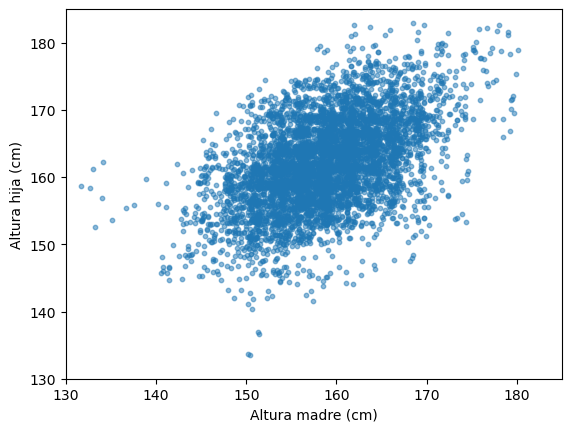

In [56]:
fig, ax = plt.subplots()

n = len(df_heights)
x = df_heights["mother_height_cm"] + np.random.normal(size=n, scale=0.8)
y = df_heights["daughter_height_cm"] + np.random.normal(size=n, scale=0.8)

ax.scatter(x, y, s=10, alpha=0.5)
ax.set(xlabel="Altura madre (cm)", ylabel="Altura hija (cm)", xlim=(130, 185), ylim=(130, 185));

# Modelo

Utilizaremos un modelo de regresión lineal simple para modelizar la asociación entre la altura de hija y la altura de la madre.

En este tipo de modelo se asume que:

* **Linealidad**: La relación entre la altura de la madre y la altura media de las hijas es una función lineal.
* **Normalidad e independencia condicional**: Para una altura de madre determinada, las alturas de las hijas son independientes y se distribuyen según una normal (verosimilitud de nuestro modelo).
* **Homocedasticidad**: La variabilidad condicional de las alturas de las hijas es constante, independiente de la altura de la madre.

En notación distribucional se puede resumir como:

$$
\begin{aligned}
\text{Altura hija}_i \mid \mu_i, \sigma &\sim \text{Normal}(\mu_i, \sigma^2) \\
\mu_i &= \beta_0 + \beta_1 \text{Altura madre}_i
\end{aligned}
$$

donde $i$ indexa a las diferentes observaciones (pares de madres e hijas).

### Determinación de _priors_

Dado que estamos trabajando bajo un enfoque bayesiano, donde toda cantidad desconocida se describe con una distribución de probabilidad, necesitamos:

1. Identificar cuáles son las cantidades desconocidas
2. Proponer un _prior_ que sea "sensible"
    1. Que refleje nuestro conocimiento del problema
    2. Que introduzca un nulo o leve grado de regularización (_priors_ no informativos o levemente informativos)

Las cantidades desconocidas son tres:

1. $\beta_0$, el intercepto. Es la altura promedio de hijas cuyas madres miden 0 centímetros (!!!).
2. $\beta_1$, la pendiente. Es el cambio en la altura promedio de las hijas por cada incremento de un centímetro en la altura de la madre.
3. $\sigma$, el desvío estándar residual. Refleja la variabilidad en las alturas de las hijas que no está explicada por la altura de la madre (asociar a la banda roja del gráfico de dispersión).

Si bien los $\mu_i$ son parámetros, estos dependen deterministicamente de $\beta_0$, $\beta_1$ y la altura de la madre, que es una cantidad conocida. Por lo tanto, no especificamos un _prior_ directamente sobre ellos, sino que lo hacemos sobre los parámetros "libres".

Que las cantidades desconocidas sean tres implica que tenemos que proponer un _prior_ tridimensional. Esto no es nada sencillo en la práctica, por lo que, comúnmente, se proponen distribuciones independientes para cada parámetro. 

Especificar un _prior_ para $\beta_0$ es todo un desafío. ¿Cuál debería ser la altura promedio de hijas cuyas madres miden 0 centímetros? Una posible respuesta podría ser "0 centímetros". Pero no es del todo satisfactoria ya que es imposible que haya alguien que mida 0 centímetros y mucho menos que ese alguien tenga una hija. Además, fijar este parámetro a 0 reduciría la flexibilidad de nuestro modelo. Una alternativa potable consiste en proponer un _prior_ muy levemente informativo, por ejemplo, una distribución $\text{Normal}(0, 30^2)$, bajo la cual un amplio rango de alturas son plausibles.

En el caso de la pendiente $\beta_1$, es posible imaginarse _priors_ razonables con mayor facilidad. Podemos preguntarnos: ¿cuánto es lo máximo que puede cambiar la altura promedio de la hija por cada centímetro que cambia la de la madre? No hay una única respuesta aceptable. Lo que sí podemos determinar es un rango de valores razonables y otro de valores pocos razonables. Por ejemplo, ¿tiene sentido decir que el cambio en la altura media de las hijas puede estar entre -50 y 50 centímetros? Definitivamente, no. ¿Y que está entre -0.1 y 0.1 centímetros? Tampoco. Un rango plausible puede ser entre -5 y 5 centímetros, o entre -10 y 10. Bajo la premisa de ser muy levemente informativos y, en este caso, también levemente regularizadores hacia cero, utilizamos el rango más amplio.

¿Cómo se puede plantear una distribución de manera tal que contenga la mayor parte de la masa de probabilidad en un rango específico? Hay distribuciones donde esto se puede hacer de manera analítica sin mucho esfuerzo. Una respuesta más general es utilizar [PreliZ](https://preliz.readthedocs.io/en/latest/), la librería para elucidación de _priors_.

Debajo, le pedimos a PreliZ que nos provea una distribución normal que contenga el 99% de la masa de probabilidad entre -10 y 10.

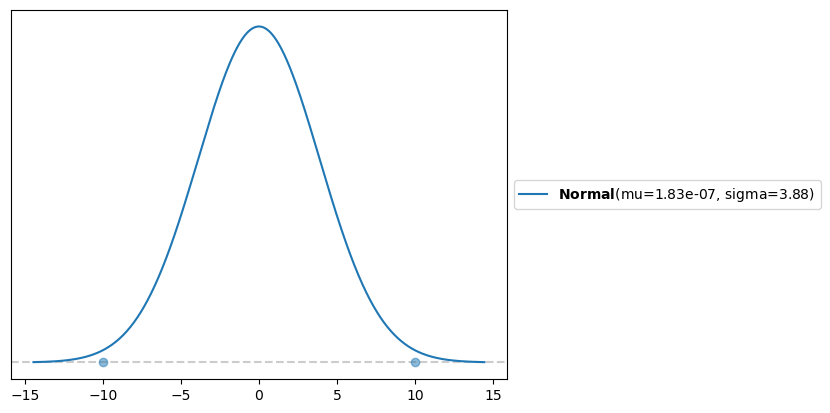

In [57]:
pz.maxent(pz.Normal(), -10, 10, 0.99);

En la leyenda se puede leer que esto es una normal con media 0 y desvío estándar 3.88. En nuestro caso, podemos usar $\text{Normal}(0, 4^2)$.

Finalmente, queda $\sigma$. Este parámetro es el desvío estándar de la normal condicional en nuestro modelo. Refleja la variabilidad en las alturas de las hijas no explicada por la altura de la madre. Si hacemos un ejercicio similar al de la pendiente, podríamos llegar a concluir que tanto valores chicos (menores a 1) como valores grandes (mayores a 50) no tienen sentido. Luego, se puede usar PreliZ para buscar los parámetros de una distribución que concentre la mayoría de la masa de probabilidad entre 0 y 50. En nuestro caso, elegimos la familia media-normal.

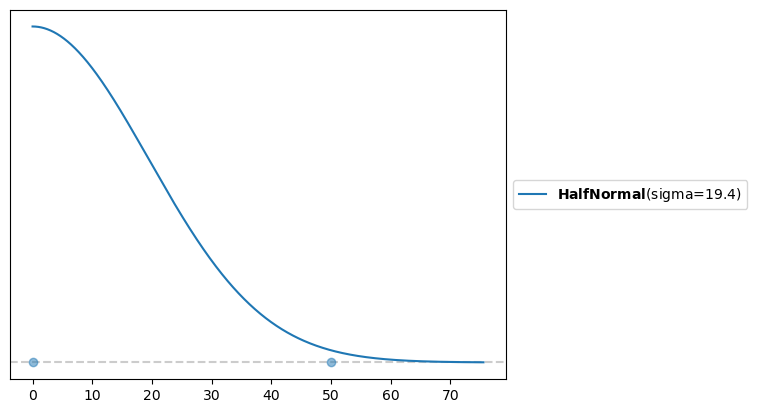

In [58]:
pz.maxent(pz.HalfNormal(), 0, 50, 0.99);

Pasando en limpio, este es nuestro modelo bayesiano:

$$
\begin{aligned}
\text{Altura hija}_i \mid \mu_i, \sigma &\sim \text{Normal}(\mu_i, \sigma^2) \\
    \mu_i &= \beta_0 + \beta_1 \text{Altura madre}_i \\
    \beta_0 &\sim \text{Normal}(0, 30^2) \\
    \beta_1 &\sim \text{Normal}(0, 4^2) \\
    \sigma &\sim \text{Normal}^+(20^2)
\end{aligned}
$$

con $i = 1, \dots, N = 5524$.

## Implementación en PyMC

Hay varias diferencias entre este modelo y el anterior que implementamos en PyMC. Señalémoslas de a una:

* Cantidad de parámetros desconocidos: antes solo había un parametro, la probabilidad de éxito $\theta$. Ahora tenemos 3 parámetros desconocidos. Todos escalares.
* Cantidad de observaciones: antes había una sola observación, un ensayo binomial con $N=115$ e $y=45$. Ahora tenemos 5524 observaciones para las cuales tenemos el par $(\text{Altura madre}_i, \text{Altura hija}_i)$.
* Modelo observacional o verosimilitud: antes usabamos un modelo binomial, ahora un modelo normal.

**¿Qué consecuencias tienen estas diferencias para nuestra implementación?**

La cantidad de parámetros no cambia sustancialmente como usamos PyMC. Simplemente creamos más distribuciones en nuestro modelo. 

El cambio en la cantidad de observaciones puede introducir modificaciones en cómo implementamos el modelo. Contamos con un vector de observaciones, y si bien no es estrictamente necesario registrarlo en el modelo con `pm.Data()`, sí es conveniente. Uno podría registrar el vector de manera similar a como lo hicimos en nuestro primer modelo y PyMC funcionaría bien. Sin embargo, PyMC explota el concepto de **dimensiones** y **coordenadas** que vimos en ArviZ. Esto resulta conveniente cuando se tienen que calcular cantidades de interés en un nuevo conjunto de datos.

Finalmente, al trabajar con una verosimilitud diferente, tenemos que procurar construir y pasar sus parámetros correctamente. En este caso, debemos asegurarnos calcular $\mu_i$ a partir de $\beta_0$, $\beta_1$ y $\text{Altura madre}_i$. El desvío estándar $\sigma$ es un simple parámetro escalar.

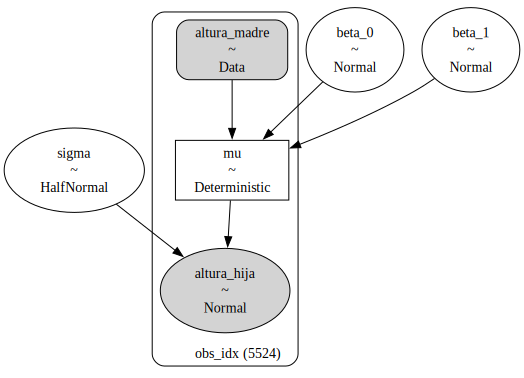

In [59]:
# Diccionario donde se guardan las coordenadas y sus valores
# "obs_idx" representa al índice de las observaciones
coords = {
    "obs_idx": np.arange(len(df_heights))
}

# Con 'coords=coords' le pasamos a PyMC las coordenadas a usar
with pm.Model(coords=coords) as model:
    # Registrar la altura de la madre en un data container
    # 'dims="obs_idx"' le dice a PyMC que "altura_madre" es un array unidimensional cuya longitud
    # está dada por las coordenadas en la dimensión "obs_idx"
    altura_madre_data = pm.Data("altura_madre", df_heights["mother_height_cm"], dims="obs_idx")

    # Priors para intercepto y pendiente
    beta_0 = pm.Normal("beta_0", 0, 30)
    beta_1 = pm.Normal("beta_1", 0, 4)

    # Calcular mu y registrarlo en el modelo con pm.Deterministic
    # También tiene una longitud dada por dims="obs_idx"
    mu = pm.Deterministic("mu", beta_0 + beta_1 * altura_madre_data, dims="obs_idx")

    # Prior para la variabilidad residual
    sigma = pm.HalfNormal("sigma", 20)

    # Likelihood (verosimilitud)
    # También tiene una longitud dada por dims="obs_idx"
    pm.Normal(
        "altura_hija", 
        mu=mu, 
        sigma=sigma, 
        observed=df_heights["daughter_height_cm"], 
        dims="obs_idx"
    )

# Crear graphviz
model.to_graphviz()

Este grafo es algo más complejo que el de nuestro primer modelo beta-binomial. Podemos reconocer los 3 parámetros escalares: `beta_0`, `beta_1` y `sigma`, así como aquellas cantidades específicas para cada observación: la altura de la madre `altura_madre`, el promedio de la normal `mu` y la altura de la hija `altura_hija`.

Sin más preámbulos, obtengamos muestras del _posterior_.

In [60]:
with model:
    idata = pm.sample(chains=4, random_seed=1234)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29 seconds.


## Diagnósticos

Veamos que el resumen del _posterior_ que tenemos con `az.summary()`. En este caso, especificamos de antemano los parámetros con `var_names`, ya que, de no hacerlo, también se incluiría  a `mu` y obtendríamos miles de filas en la salida.

In [61]:
az.summary(idata, var_names=["beta_0", "beta_1", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,75.449,2.028,71.774,79.372,0.061,0.043,1130.0,1394.0,1.0
beta_1,0.546,0.013,0.522,0.569,0.000,0.000,1132.0,1394.0,1.0
sigma,5.747,0.055,5.646,5.853,0.001,0.001,1634.0,1487.0,1.0


Una de las primeras columnas que uno debe mirar es `r_hat`. Si alguno de valores de $\hat{R}$ se encuentra muy por encima de `1`, no tiene sentido interpretar al resto de las cantidades en el resumen ya que las muestras podrían no ser representativas del _posterior_. 

En este caso, tenemos dos valores de `r_hat` que se reporatan como `1.01`. Mirémoslos más en detalle.

In [62]:
az.rhat(idata, var_names=["beta_0", "beta_1", "sigma"])

<xarray.Dataset> Size: 24B
Dimensions:  ()
Data variables:
    beta_0   float64 8B 1.003
    beta_1   float64 8B 1.004
    sigma    float64 8B 1.001

Podría pensarse que los valores en la salida de `az.summary()` son en realidad una falsa alarma, ya que los `1.01` son un efecto del redondeo y las estimaciones en realidad son menores a 1.01.

Independientemente de eso, sigamos investigando. Es el turno de los _traceplots_.

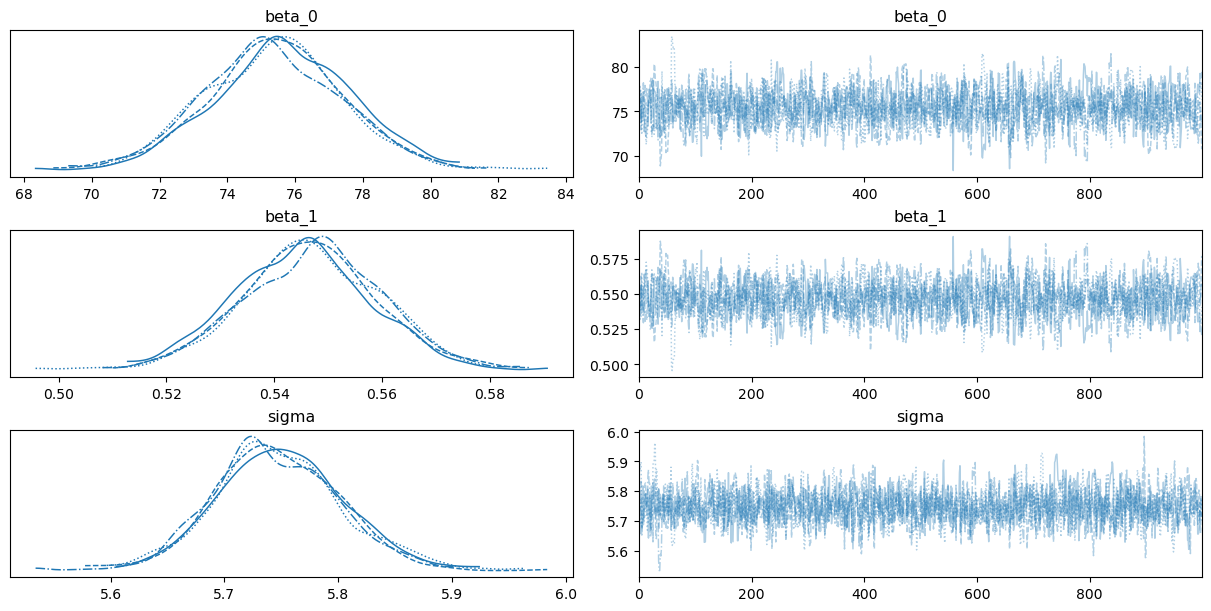

In [63]:
az.plot_trace(idata, var_names=["beta_0", "beta_1", "sigma"], backend_kwargs={"layout": "constrained"});

En los paneles de la izquierda, vemos que las densidades estimadas son parecidas en todos los casos. En la derecha, no se pueden observar desviaciones serías de un comportamiento de ruido blanco o falta de mezcla y convergencia.

Sin embargo, existe otra visualización que uno puede construir con este modelo que tiene más de un parámetro, el _pairplot_. 

Un _pairplot_ contiene gráficos de dispersión construidos a partir de las muestras del posterior. En cada panel del gráfico se puede observar la asociación entre dos parámetros. Para construirlo usamos la función `plot_pair()` de ArviZ.

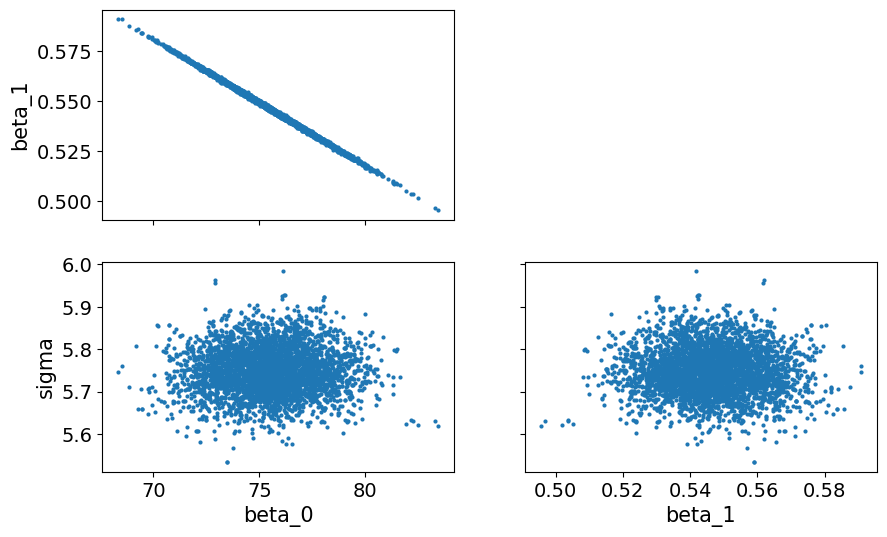

In [64]:
az.plot_pair(idata, var_names=["beta_0", "beta_1", "sigma"], figsize=(10, 6));

Acá sí hay algo que llama la atención. El panel superior izquierdo muestra la asociación en el _posterior_ de $\beta_0$ y $\beta_1$. La concentración de puntos en la diagonal indica una altísima correlación entre $\beta_0$ y $\beta_1$. ¿Es esto algo malo _per se_? La respuesta es que no. Dado el modelo y los datos, así resulta el _posterior_.

Sin embargo, dado que utilizamos un método de muestreo basado en cadenas de Markov, como NUTS, las correlaciones en el _posterior_ se vuelven relevantes, ya que pueden hacer que sea más difícil para nuestro algoritmo obtener muestras representativas. En general, regiones de alta curvatura en el _posterior_ resultan dificultosas para algoritmos como NUTS.

# Modelo centrado

Si bien podríamos haber continuado trabajando con el modelo anterior, el "problema" encontrado en aquel _posterior_ nos da pie a presentar una técnica que reduce la correlación _a posteriori_ y resulta en inferencias más rápidas y confiables. Además, en este caso particular, facilita la determinación de _priors_.

El truco es muy simple: centrar los valores del predictor en su media. Así, trabajamos con la altura de la madre centrada, en vez de la altura original de la madre.

$$
\text{Altura madre}_i^* = \text{Altura madre}_i - \text{media}({\text{Altura madre}})
$$

In [65]:
altura_hija = df_heights["daughter_height_cm"]
altura_madre_c = df_heights["mother_height_cm"] - df_heights["mother_height_cm"].mean()

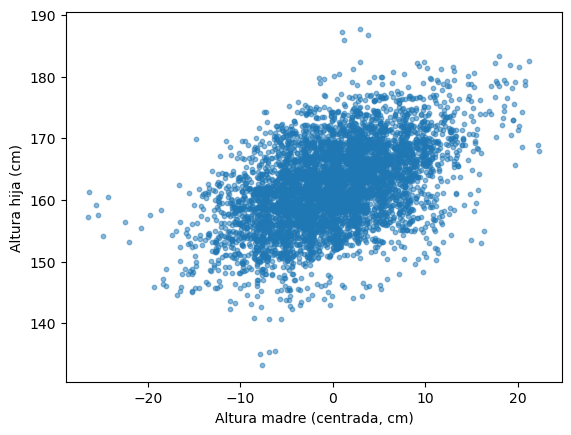

In [66]:
fig, ax = plt.subplots()

n = len(df_heights)
x = altura_madre_c + np.random.normal(size=n, scale=0.8)
y = altura_hija + np.random.normal(size=n, scale=0.8)

ax.scatter(x, y, s=10, alpha=0.5)
ax.set(xlabel="Altura madre (centrada, cm)", ylabel="Altura hija (cm)");

## _Priors_, nuevamente

Esta modificación no altera la pendiente, que refleja la asociación entre las alturas de las madres y las hijas, ni el desvío estándar residual. Lo que cambia es el significado del intercepto. Ahora, el intercepto no representa la altura promedio de hijas cuyas madres miden 0 centímetros, lo cual no tiene ningún sentido. En cambio, representa la altura promedio de hijas cuyas madres tienen la altura promedio, ¡una cantidad que sí tiene sentido!

En consecuencia, solo vamos a proponer un nuevo _prior_ para $\beta_0$. La pregunta que tenemos que hacernos es, ¿cuál es la altura promedio de mujeres cuyas madres tienen una altura promedio? No hace falta que nuestra respuesta sea la correcta al estilo de un certámen de preguntas y respuestas. Nos basta con proponer una distribución que represente un rango de valores razonable. ¿Cuál es este rango razonable? ¿Entre 0 y 300 centímetros? Eso es demasiado ancho. ¿Entre 155 y 165 centímetros? Tal vez sea demasiado informativo. Una respuesta poco informativa y razonable es entre 140 y 180 centímetros, que puede representar se con una $\text{Normal}(160, 10^2)$.

En consecuencia, nuestro modelo se define:

$$
\begin{aligned}
\text{Altura hija}_i \mid \mu_i, \sigma &\sim \text{Normal}(\mu_i, \sigma^2) \\
    \mu_i &= \beta_0 + \beta_1 \text{Altura madre}_i^* \\
    \beta_0 &\sim \text{Normal}(160, 10^2) \\
    \beta_1 &\sim \text{Normal}(0, 4^2) \\
    \sigma &\sim \text{Normal}^+(20^2)
\end{aligned}
$$

con $i = 1, \dots, N = 5524$.

## Implementación en PyMC

La implementación es casi idéntica a la anterior. Hay solamente dos diferencias:

* Usamos las alturas de las madres centradas, en vez de las originales.
* Actualizamos el _prior_ para $\beta_0$.

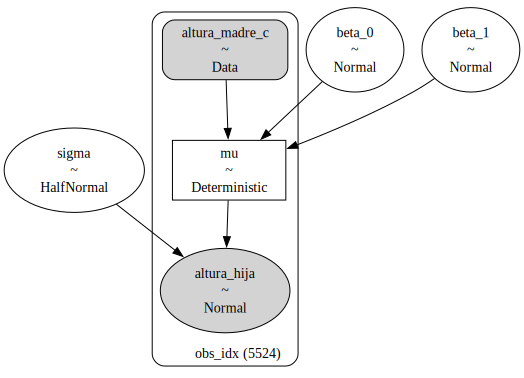

In [67]:
coords = {
    "obs_idx": np.arange(len(df_heights))
}

with pm.Model(coords=coords) as model_c:
    altura_madre_c_data = pm.Data("altura_madre_c", altura_madre_c, dims="obs_idx")

    beta_0 = pm.Normal("beta_0", 160, 10)
    beta_1 = pm.Normal("beta_1", 0, 4)

    mu = pm.Deterministic("mu", beta_0 + beta_1 * altura_madre_c_data, dims="obs_idx")
    sigma = pm.HalfNormal("sigma", 20)

    pm.Normal("altura_hija", mu=mu, sigma=sigma, observed=altura_hija, dims="obs_idx")

model_c.to_graphviz()

In [68]:
with model_c:
    idata_c = pm.sample(chains=4, random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


A simple vista se puede notar una gran diferencia entre este modelo y el anterior: el _sampler_ funcionó mucho más rápido. Esta información se guarda dentro del grupo `sample_stats` de nuestros `InferenceData`s.

In [69]:
print("Tiempo de muestreo modelo no centrado:", round(idata.sample_stats.sampling_time, 2), "segundos")
print("Tiempo de muestreo modelo centrado:", round(idata_c.sample_stats.sampling_time, 2), "segundos")

Tiempo de muestreo modelo no centrado: 29.19 segundos
Tiempo de muestreo modelo centrado: 3.15 segundos


## Diagnósticos

Echemos un vistazo a el resumen del _posterior_.

In [70]:
az.summary(idata_c, var_names=["beta_0", "beta_1", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,162.194,0.077,162.048,162.340,0.001,0.001,6195.0,3079.0,1.0
beta_1,0.545,0.013,0.519,0.569,0.000,0.000,5641.0,2620.0,1.0
sigma,5.747,0.054,5.650,5.852,0.001,0.001,5628.0,2682.0,1.0


Lo primero que notamos es que ya no hay valores de `r_hat` mayores a 1. Por otro lado, los tamaños efectivos de muestra son mayores a los que obtuvimos en el modelo anterior, indicando una mayor eficiencia del algoritmo de muestreo.

Podemos también repasar los _traceplots_. Las densidades se ven todas similares y las trayectorias de las cadenas son indistinguibles. Todas recorren el mismo rango y no se observan estancamientos o tendencias.

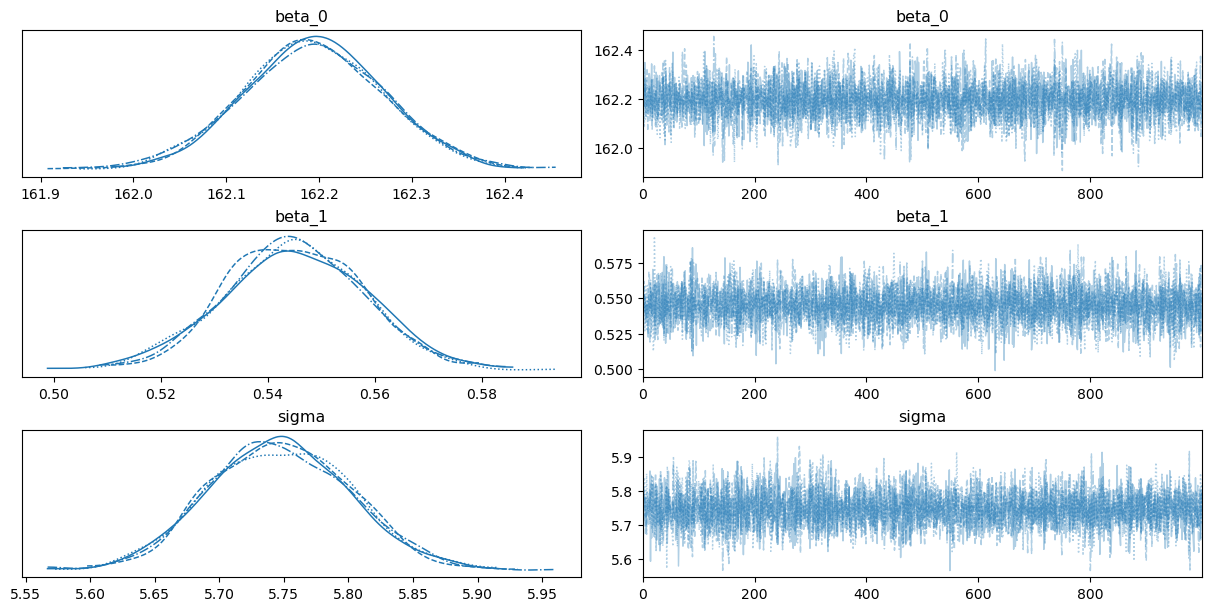

In [71]:
az.plot_trace(idata_c, var_names=["beta_0", "beta_1", "sigma"], backend_kwargs={"layout": "constrained"});

Para concluir esta parte de diagnósticos, obtengámos el _pairplot_ en base a las muestras del _posterior_ de este segundo modelo. 

Como podemos ver, ya no se encuentra ninguna correlación entre `beta_0` y `beta_1`. Esto tiene mucho que ver con que el algoritmo de muestreo haya funcionado más rápido. A _posteriors_ más suaves, mejor desempeño de NUTS.

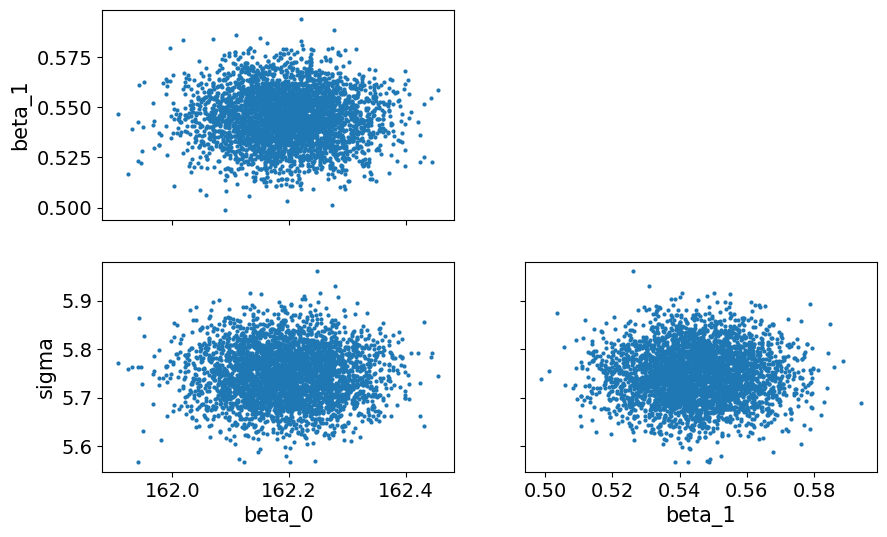

In [72]:
az.plot_pair(idata_c, var_names=["beta_0", "beta_1", "sigma"], figsize=(10, 6));

Finalmente, podemos interpretar los parámetros del modelo. La función `az.summary()` tiene un argumento `kind` que si le pasamos `"stats"` solo muestra estadísticas resumen de los parámetros y no incluye medidas de diagnóstico.

In [73]:
az.summary(idata_c, var_names=["beta_0", "beta_1", "sigma"], kind="stats")

,mean,sd,hdi_3%,hdi_97%
beta_0,162.194,0.077,162.048,162.340
beta_1,0.545,0.013,0.519,0.569
sigma,5.747,0.054,5.650,5.852


* `beta_0`: la altura promedio de hijas con madres de altura promedio está alrededor de 162 centímetros.
* `beta_1`: cada centímetro de incremento en la altura de la madre se asocia con un incremento de poco más de medio centímetro en la altura promedio de las hijas.
* `sigma`: Consdierando que es un modelo normal, podemos decir que, para una altura de madre determinada, la altura de las hijas se encuentran en general a $\pm 11$ centímetros de la media. El $\approx 11$ sale de multiplicar al desvío por $1.96$ que es el cuantil que resulta en un intervalo del 95% en familias normales.

# Respuestas

> Obtenga la distribución _a posteriori_ del peso medio de una hija cuya madre mide 58 pulgadas.

Podemos hacer:

$$
\mu^* = \beta_0 + \beta_1 \times [(58 \times 2.54) - \text{media}(\text{Altura madre})]
$$

utilizando muestras del _posterior_.

In [74]:
altura_madre_media = df_heights["mother_height_cm"].mean()
altura_madre = 58 * 2.54 - altura_madre_media

# Calcular 'mu' a partir de muestras del posterior de beta_0 y beta_1
mu = idata_c.posterior["beta_0"] + idata_c.posterior["beta_1"] * altura_madre
mu

<xarray.DataArray (chain: 4, draw: 1000)> Size: 32kB
array([[156.04408427, 155.92792344, 155.92366462, ..., 155.91493835,
        156.17898163, 155.93470241],
       [156.04304287, 155.92007769, 155.93421852, ..., 155.98748041,
        155.8543693 , 155.91922534],
       [155.89495581, 155.91875203, 155.84329143, ..., 156.24894903,
        156.01707354, 155.76933528],
       [156.05722233, 155.92802286, 155.88440235, ..., 156.35887367,
        155.49546145, 155.97004651]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

Como teníamos 4000 muestras para $(\beta_0, \beta_1)$, tenemos 4000 muestras para $\mu^*$. Visualizamos la distribución _a posteriori_ de $\mu^*$ debajo.

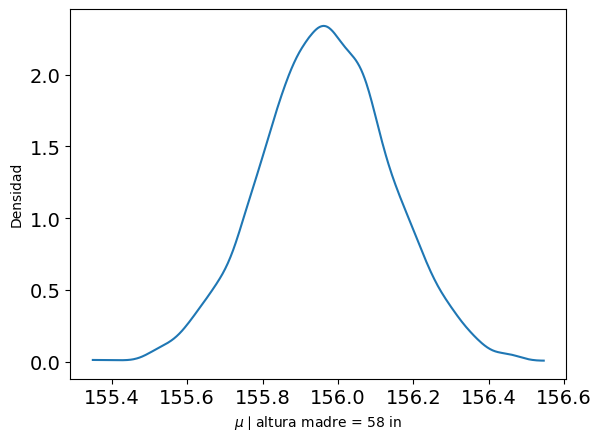

In [75]:
ax = az.plot_dist(mu)
ax.set(xlabel="$\\mu \\mid \\text{altura madre = 58 in}$", ylabel="Densidad");

> ¿Cuál es la probabilidad de que una hija mida más de 65 pulgadas cuando su madre mide 60 pulgadas?

In [76]:
60 * 2.54

152.4

En este caso, la pregunta habla sobre cuánto mide una hija en particular. No solo alcanza con obtener el _posterior_ de la media, necesitamos la distribución predictiva _a posteriori_ para cuando $\text{Altura madre} = 152.4 \text{ cm}$.

In [77]:
# Obtener muestras de la media
altura_madre = 152.4 - altura_madre_media
mu = idata_c.posterior["beta_0"] + idata_c.posterior["beta_1"] * altura_madre

# A partir de las muestras de la media y sigma, generar muestras de una normal
# Es decir, obtener muestras de la predictiva a posteriori.
y_rvs = np.random.normal(loc=mu, scale=idata_c.posterior["sigma"])

Podemos observarlas a ambas en un mismo gráfico.

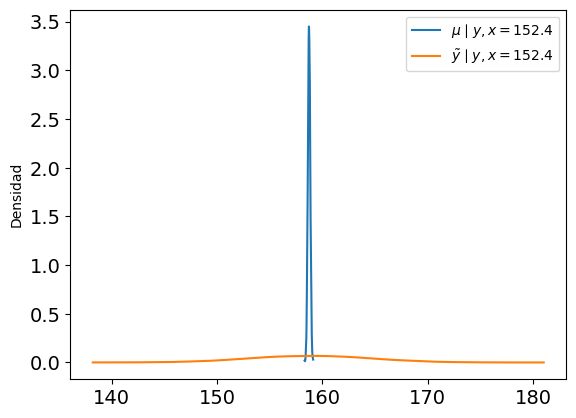

In [78]:
az.plot_dist(mu, label="$\\mu \\mid y, x = 152.4$", color="C0")
ax = az.plot_dist(y_rvs, label="$\\tilde{y} \\mid y, x = 152.4$", color="C1")
ax.set(ylabel="Densidad");

Tanto la distribución _a posteriori_ de la media como la distribución predictiva _a posteriori_ están centradas en el mismo valor. Pero difieren, considerablemente, en su dispersión. La distribución predictiva incorpora otra fuente de variabilidad, que es la representada por $\sigma$.

Debajo visualizamos solo la distribución predictiva.

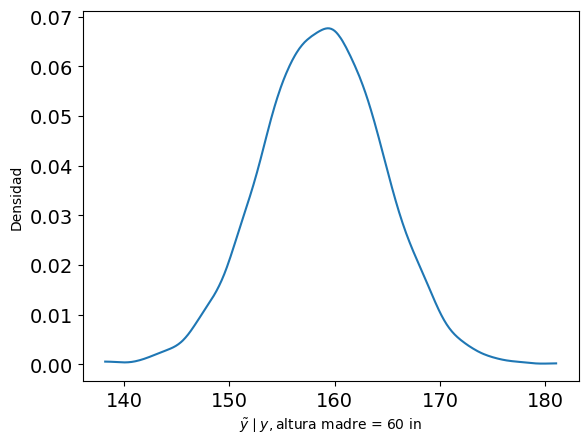

In [79]:
ax = az.plot_dist(y_rvs)
ax.set(xlabel="$\\tilde{y} \\mid y, \\text{altura madre = 60 in}$", ylabel="Densidad");

Para determinar la probabilidad de que la altura de la hija sea mayor a 65 pulgadas (165.1 centímetros), calculamos la proporción de muestras de la distribución predictiva que son mayores a 165.1.

In [80]:
(y_rvs > (65 * 2.54)).mean()

0.13275

Si estamos dispuestos a hacer un trabajo más manual, podemos obtener un gráfico como el siguiente, donde se resalta la probabilidad calculada.

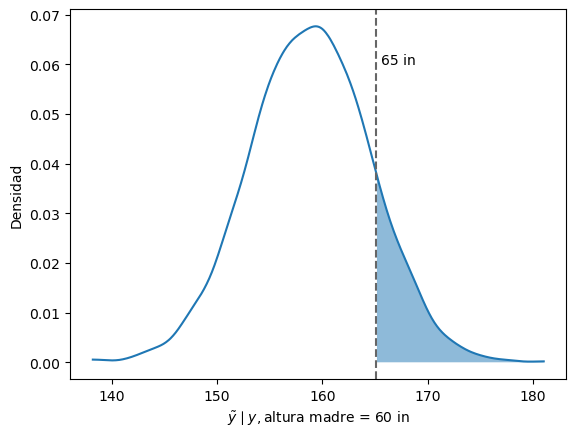

In [81]:
# Obtener estimacion de densidad (Kernel Density Estimate) con ArviZ.
# 'x' es una grilla de valores para el eje horizontal
# 'pdf' es la altura de la función de densidad
x, pdf = az.kde(y_rvs)

# Filtro para rellenar el área de interés
mask = x > (65 * 2.54)

fig, ax = plt.subplots()

ax.plot(x, pdf)
ax.fill_between(x[mask], pdf[mask], 0, alpha=0.5)
ax.axvline(x=65 * 2.54, ls="--", color="0.4")
ax.text(x=65 * 2.54 + 0.5, y=0.06, s="65 in")
ax.set(xlabel="$\\tilde{y} \\mid y, \\text{altura madre = 60 in}$", ylabel="Densidad");

> ¿Y si mide 65?

El proceso es idéntico al anterior, solo hay que cambiar el valor del predictor.

In [82]:
altura_madre = 65 * 2.54 - altura_madre_media
mu = idata_c.posterior["beta_0"] + idata_c.posterior["beta_1"] * altura_madre

y_rvs = np.random.normal(loc=mu, scale=idata.posterior["sigma"])

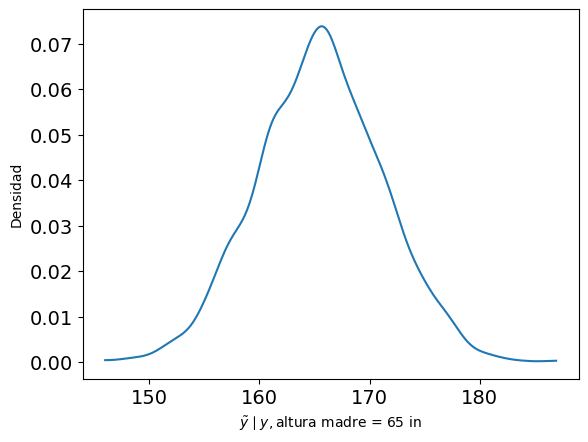

In [83]:
ax = az.plot_dist(y_rvs)
ax.set(xlabel="$\\tilde{y} \\mid y, \\text{altura madre = 65 in}$", ylabel="Densidad");

In [84]:
(y_rvs > 65 * 2.54).mean()

0.53175

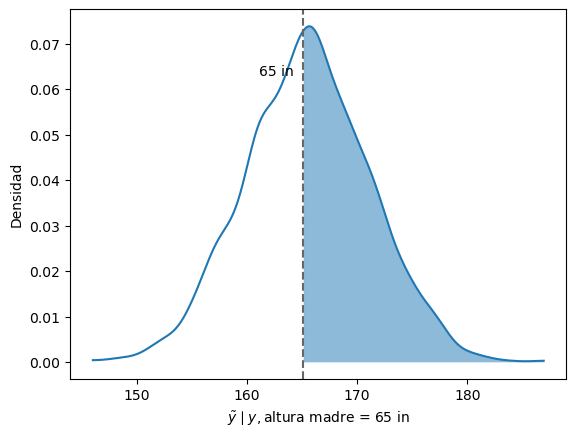

In [85]:
x, pdf = az.kde(y_rvs)
mask = x > (65 * 2.54)

fig, ax = plt.subplots()

ax.plot(x, pdf)
ax.fill_between(x[mask], pdf[mask], 0, alpha=0.5)
ax.axvline(x=65 * 2.54, ls="--", color="0.4")
ax.text(x=65 * 2.54 - 4, y=0.063, s="65 in")
ax.set(xlabel="$\\tilde{y} \\mid y, \\text{altura madre = 65 in}$", ylabel="Densidad");

# Respuestas _a la_ PyMC

El proceso anterior de muestreo de la distribución predictiva posibilita tener las respuestas a las preguntas deseadas pero es manual, engorroso y falible.

PyMC sabe como obtener muestras de la distribución predictiva _a posteriori_. Podemos hacerlo para el conjunto de datos observados, o para un conjunto de datos nuevos. En nuestro caso, estamos interesado en tres alturas de madre particulares: 58, 60 y 65 pulgadas. Esto nos ahorra todo el trabajo manual de antes, aunque hay que familiarizarse con la interface de PyMC.

Para obtener el _posterior_ de la media y la distribución predictiva dadas las alturas de madres deseadas seguimos los siguientes pasos:

* Fijar nuevos valores de `"altura_madre_c"`. Es un vector de longitud 3.
* Fijar las coordenadas para estos 3 valores. Podemos utilizar `[0, 1, 2]`. Acá podemos poner valores arbitrarios siempre y cuando sean distintos.
* Llamar a `pm.sample_posterior_predictive()` y guardar las muestras en `idata_c`.
    * Esto se conoce también como "correr el modelo hacia delante".

Otro detalle no menor en el siguiente bloque de código es el uso de `clone_model()` que importamos anteriormente desde `pymc.model.fgraph`. Esta función hace lo que indica su nombre, clona un modelo de PyMC, es decir, devuelve una copia. Probablemente nos preguntemos, ¿por qué clonar un modelo? La razón para clonar un modelo es que si no lo hacemos el uso del `pm.set_data()` modifica los datos en el modelo original. Si luego quisiéramos reutilizar el modelo original, ya no sería el mismo porque los datos en el grafo computacional no son los mismos que los usados para obtener el _posterior_. 

In [86]:
alturas_madres = np.array([58, 60, 65]) * 2.54 - altura_madre_media
idxs = np.array([0, 1, 2])

# Clonar modelo para no alterar el modelo original
with clone_model(model_c):
    
    # Fijar valores de los datos y las coordenadas
    pm.set_data(
        new_data={"altura_madre_c": alturas_madres},
        coords={"obs_idx": idxs}
    )

    # Obtener muestras de la distribución predictiva ("correr el modelo hacia delante")
    # * `var_names`: estamos pidiendo tanto los valores de 'mu' como los de 'altura_hija'
    # * `predictions=True`: que guarde los valores en un nuevo grupo llamado `predictions`
    idata_c.extend(
        pm.sample_posterior_predictive(
            idata_c, 
            var_names=["mu", "altura_hija"], 
            predictions=True
        )
    )

Sampling: [altura_hija]


Output()

Vemos que tenemos un nuevo grupo:

In [87]:
idata_c.predictions

<xarray.Dataset> Size: 200kB
Dimensions:      (chain: 4, draw: 1000, obs_idx: 3)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * obs_idx      (obs_idx) int64 24B 0 1 2
Data variables:
    altura_hija  (chain, draw, obs_idx) float64 96kB 149.6 166.2 ... 167.4 158.5
    mu           (chain, draw, obs_idx) float64 96kB 156.0 158.8 ... 158.7 165.7
Attributes:
    created_at:                 2024-09-02T13:45:05.905994+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

Aunque originalmente la longitud de `obs_idx` era 5524, en este nuevo grupo `predictions` es de longitud 3 por la interveción que hicimos a con `pm.set_data()`.

Debajo, los gráficos que generamos anteriormente.

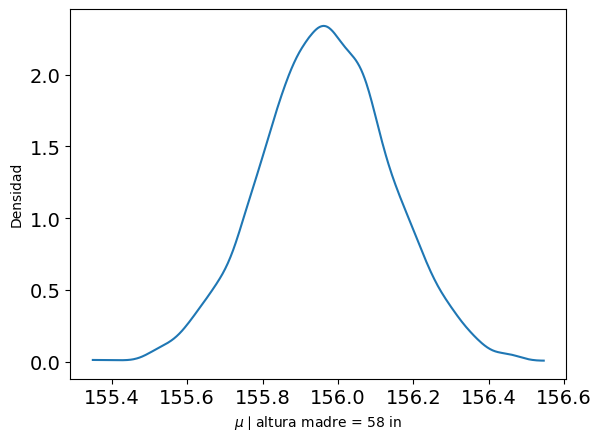

In [88]:
ax = az.plot_dist(idata_c.predictions.sel(obs_idx=0)["mu"])
ax.set(xlabel="$\\mu \\mid \\text{altura madre = 58 in}$", ylabel="Densidad");

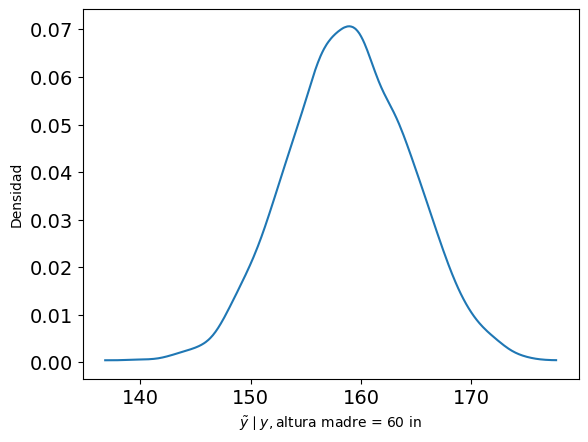

In [89]:
ax = az.plot_dist(idata_c.predictions.sel(obs_idx=1)["altura_hija"])
ax.set(xlabel="$\\tilde{y} \\mid y, \\text{altura madre = 60 in}$", ylabel="Densidad");

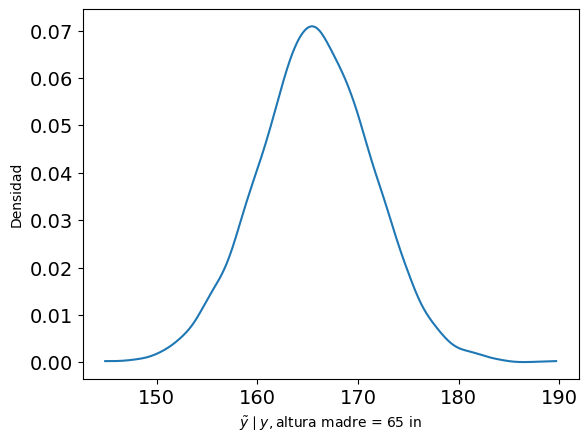

In [90]:
ax = az.plot_dist(idata_c.predictions.sel(obs_idx=2)["altura_hija"]);
ax.set(xlabel="$\\tilde{y} \\mid y, \\text{altura madre = 65 in}$", ylabel="Densidad");

Podemos hacer el cálculo de probabilidad de manera simultánea sin dejar la estructura de datos de xarray.

In [91]:
(idata_c.predictions.sel(obs_idx=[1, 2])["altura_hija"] > 65 * 2.54).mean(("chain", "draw"))

<xarray.DataArray 'altura_hija' (obs_idx: 2)> Size: 16B
array([0.13675, 0.544  ])
Coordinates:
  * obs_idx  (obs_idx) int64 16B 1 2

# Visualizaciones

Cuando trabajamos con modelos de regresión es muy común obtener visualizaciones que permitan resumir la recta que representa la media condicional (i.e. recta de regresión) y la que represta la distribución predictiva condicional. 

Para elaborar el gráfico que buscamos es necesario obtener la distribución de $\mu_i \mid x_i$ para una grilla de valores lo suficientemente densa de $X$ y lo mismo para la predictiva. Debajo obtenemos ambas con PyMC.

In [92]:
# Grilla de valores para 'x'
alturas_madres = np.linspace(52, 72, num=100)

# Grilla de valores para 'x' centrados 
alturas_madres_c = alturas_madres * 2.54 - altura_madre_media

# Nuevos indicies para las observaciones de la grilla
idxs = np.arange(100)

# Clonar modelo para no alterar el modelo original
with clone_model(model_c):
    # Fijar valores de los datos y las coordenadas
    pm.set_data(
        new_data={"altura_madre_c": alturas_madres_c},
        coords={"obs_idx": idxs}
    )

    # Muestrear tanto 'mu' como la respuesta 'altura_hija'
    preds = pm.sample_posterior_predictive(
        idata_c, 
        var_names=["mu", "altura_hija"], 
        predictions=True
    )

Sampling: [altura_hija]


Output()

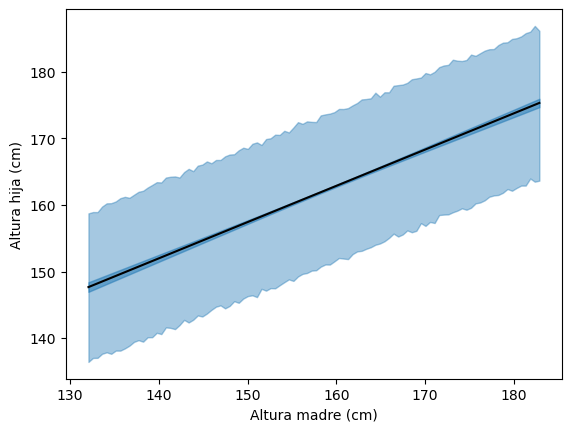

In [93]:
# Media e intervalo para mu
mu = preds.predictions["mu"].mean(("chain", "draw")).to_numpy()
mu_lower, mu_upper = preds.predictions["mu"].quantile((0.025, 0.975), ("chain", "draw")).to_numpy()

# Media e intervalo para la respuesta
y = preds.predictions["altura_hija"].mean(("chain", "draw")).to_numpy()
y_lower, y_upper = preds.predictions["altura_hija"].quantile((0.025, 0.975), ("chain", "draw")).to_numpy()

fig, ax = plt.subplots()

ax.plot(alturas_madres * 2.54, mu, color="0")
ax.fill_between(alturas_madres * 2.54, y_lower, y_upper, alpha=0.4, color="C0")
ax.fill_between(alturas_madres * 2.54, mu_lower, mu_upper, alpha=0.5, color="C0");

ax.set(xlabel="Altura madre (cm)", ylabel="Altura hija (cm)");

Podemos notar que la incertidumbre en la predicción de la alturas de hijas se debe principalmente a la incertidumbre que representa $\sigma$ y no tanto a la incertidumbre en $\mu_i$ (su banda de credibilidad es consiredablemente más estrecha).

También podemos superponer los valores observados.

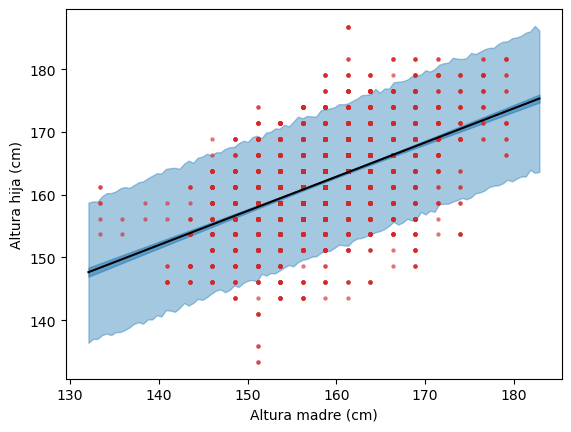

In [94]:
mu = preds.predictions["mu"].mean(("chain", "draw")).to_numpy()
mu_lower, mu_upper = preds.predictions["mu"].quantile((0.025, 0.975), ("chain", "draw")).to_numpy()

y = preds.predictions["altura_hija"].mean(("chain", "draw")).to_numpy()
y_lower, y_upper = preds.predictions["altura_hija"].quantile((0.025, 0.975), ("chain", "draw")).to_numpy()

fig, ax = plt.subplots()

ax.plot(alturas_madres * 2.54, mu, color="0")
ax.fill_between(alturas_madres * 2.54, y_lower, y_upper, alpha=0.4, color="C0")
ax.fill_between(alturas_madres * 2.54, mu_lower, mu_upper, alpha=0.5, color="C0")
ax.scatter(df_heights["mother_height_cm"], df_heights["daughter_height_cm"], s=5, color="C3", alpha=0.5)

ax.set(xlabel="Altura madre (cm)", ylabel="Altura hija (cm)");

# Ejercicios

### Ejercicio 1

El dataset `earnings` contiene los resultados de la encuesta realizada por Ross sobre Trabajo, Familia y Bienestar.

* Ajuste un modelo que prediga ingreso en función de altura e interprete los parámetros.
* ¿Qué transformación sería necesaria para interpretar el intercepto como el ingreso promedio de una persona con altura promedio?
* Ajuste un nuevo modelo utilizando la transformación propuesta en el punto anterior y compare los posteriors de los coeficientes.

### Ejercicio 2

Los !Kung son un pueblo que habita en el desierto de Kalahari entre Botsuana, Namibia y Angola. Hablan la lengua !Kung, que se destaca por su amplio uso de consonantes clic (chasquido consonántico). El !K del nombre ǃKung es un sonido como cuando sale un corcho de una botella.

El archivo `Howell1` contiene datos de un censo parcial realizado por Dobe Howell acerca de la población !Kung.

Considere un modelo de altura en función del peso.

* Determine e interprete las distribuciones a posteriori de los parámetros.
* Construya un gráfico de altura en función del peso, incluya las observaciones de los individuos, la recta de regresión media, el intervalo del 80% para la media y y el intervalo del 80% para la altura predicha.
* Realice predicciones para individuos cuyos pesos son: 46.95, 43.72, 64.78, 32.59 y 54.63. Calcule la altura esperada y el intervalo del 89%.

### Ejercicio 3

Una compañía pesquera de Comodoro Rivadavia se encuentra probando un nuevo método para estimar el peso de los peces que extrae del Mar Argentino. El objetivo de este método es obtener una estimación lo suficientemente buena del peso de cada pescado sin tener que pesarlos uno por uno, ya que es un proceso costoso en tiempo y labor. Para eso, seleccionaron una muestra de pescados, los pesaron y les midieron ciertos aspectos morfológicos (ancho, alto y largo). En el futuro, esperan recolectar estas mismas medidas morfológicas mediante una cámara especializada y utilizar un modelo para estimar el peso.

El modelo propuesto por el equipo de investigación es el siguiente:

$$
\begin{aligned}
\log(\text{Peso}_i) &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i               &= \beta_0 + \beta_1 \log(\text{Largo}_i) \\
\beta_0             &\sim \text{Normal} \\
\beta_1             &\sim \text{Normal} \\
\sigma              &\sim \text{Gamma}
\end{aligned}
$$

donde el peso se encuentra medido en gramos y la longitud en centímetros. Los datos se encuentran en el archivo `fish.csv`.

1. Implemente el modelo en PyMC luego de seleccionar hiperparámetros que crea razonables para los _priors_ de $\beta_0$, $\beta_1$ y $\sigma$. **Recomendación**: visualizar la relación entre $\text{Largo}$ y $\text{Peso}$ y entre $\log(\text{Largo})$ y $\log(\text{Peso})$.
2. Analice de manera gráfica y analítica los posteriors marginales de los parámetros del modelo. Realice las transformaciones de parámetros que crea conveniente para facilitar la comprensión del análisis.
3. Considere un pescado cuya longitud es de 30 centímetros.
    1. Obtenga y grafique la distribución _a posteriori_ del peso medio.
    2. Obtenga y grafique la distribución predictiva _a posteriori_ del peso.
    3. Interprete los resultados.
4. Grafique la curva de regresión junto a una banda de credibilidad del 95% en el plano de las variables originales y en el plano de las variables transformadas.
5. Agregue a los gráficos anteriores una banda de credibilidad del 95% para la distribución predictiva _a posteriori_. Interprete los resultados.

# Referencias

* [Are all slope coefficients correlated with the intercept in multiple linear regression?](https://stats.stackexchange.com/a/438302)
* [On the Laws of Inheritance in Man: Inheritance of Physical Characters](https://www.jstor.org/stable/2331507)